## Environment Setup

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# hack - https://github.com/googlecolab/colabtools/issues/3409#issuecomment-1446281277
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install -Uq ipdb
import ipdb

In [20]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
/content/rapidsai-csp-utils
Already on '22.12-patch'
Your branch is up to date with 'origin/22.12-patch'.
/content
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************

***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  error: subprocess-exited-with-error

  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.

  note: This error originates from a subprocess, and is likel

In [21]:
%%bash
# Install the Merlin Framework
pip install -Uq git+https://github.com/NVIDIA-Merlin/models.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/core.git@release-23.06
# pip install -Uq git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
# pip install -Uq git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.06
# pip install -Uq xgboost lightfm implicit

In [22]:
import logging

# Set the logging level to a higher value (e.g., CRITICAL)
logging.basicConfig(level=logging.ERROR)

## Load Data
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [23]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags
import merlin.io
import merlin.models.tf as mm

import nvtabular as nvt
import tensorflow as tf


from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

In [24]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

In [25]:
import glob

USE_AUGMENTED_DATASET= False
DATA_VERSION = 'v4'

_TRAIN,_VALID,_TEST = ('train_aug', 'valid_aug', 'test_aug') if USE_AUGMENTED_DATASET else ('train', 'valid', 'test')

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN + f'_{DATA_VERSION}', "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID + f'_{DATA_VERSION}', "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST + f'_{DATA_VERSION}', "*.parquet")))

# TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN , "*.parquet")))
# VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID , "*.parquet")))
# TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST , "*.parquet")))
TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test_v4/part_0.parquet'])

In [26]:
train = merlin.io.Dataset(
    TRAIN_PATHS, engine="parquet"
)
valid = merlin.io.Dataset(
    VALID_PATHS, engine="parquet"
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [27]:
schema = train.schema.select_by_tag([
    Tags.ITEM_ID,
    Tags.USER_ID,
    Tags.ITEM,
    Tags.USER,
    # Tags.TARGET,
    ])
schema

,name,tags,dtype,is_list,is_ragged,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.freq_threshold,properties.cat_path,properties.max_size,properties.start_index,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ID, Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,1665.0,102.0,None,0.0,.//categories/unique.movie_id.parquet,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.ID, Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,944.0,74.0,None,0.0,.//categories/unique.user_id.parquet,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,3.0,16.0,None,0.0,.//categories/unique.gender.parquet,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,22.0,16.0,None,0.0,.//categories/unique.occupation.parquet,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,20.0,16.0,None,0.0,.//categories/unique.genres.parquet,0.0,0.0,0,19,genres,0.0,NaN


In [28]:
# schema = schema.excluding_by_name('genres')

In [29]:
train.head()

,movie_id,movie_id_raw,user_id,gender,occupation,genres,rating
0,226,705,149,1,3,"[5, 13]",1
1,74,144,148,1,3,"[4, 3]",1
2,137,203,295,1,5,[15],1
3,9,300,761,1,3,"[4, 3]",1
4,43,25,212,2,7,[2],1


In [30]:
# missing from load
schema['movie_id'].tags._tags.add(Tags.ITEM_ID)
schema['user_id'].tags._tags.add(Tags.USER_ID)

In [31]:
# train = merlin.io.Dataset(train.to_ddf().compute().drop('rating', axis=1))
# valid = merlin.io.Dataset(valid.to_ddf().compute().drop('rating', axis=1))

In [32]:
# select only trainable features and exclude the target
train.schema = schema
valid.schema = schema

In [33]:
train.schema

,name,tags,dtype,is_list,is_ragged,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.freq_threshold,properties.cat_path,properties.max_size,properties.start_index,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ID, Tags.ITEM, Tags.CATEGORICAL, Tags.IT...","DType(name='int64', element_type=<ElementType....",False,False,1665.0,102.0,None,0.0,.//categories/unique.movie_id.parquet,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.ID, Tags.USER, Tags.CATEGORICAL, Tags.US...","DType(name='int64', element_type=<ElementType....",False,False,944.0,74.0,None,0.0,.//categories/unique.user_id.parquet,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,3.0,16.0,None,0.0,.//categories/unique.gender.parquet,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,22.0,16.0,None,0.0,.//categories/unique.occupation.parquet,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,20.0,16.0,None,0.0,.//categories/unique.genres.parquet,0.0,0.0,0,19,genres,0.0,NaN


In [34]:
assert len(train.schema.select_by_tag(Tags.TARGET).column_names) == 0

## Build Model
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb

### Model definition

In [103]:
from merlin.models.utils import schema_utils
from merlin.models.tf.transforms.bias import PopularityLogitsCorrection
from merlin.models.tf.outputs.base import DotProduct


def topKMetricsAggregator(top_ks: list = [100, 10]):
    return [
        tf.keras.metrics.AUC(from_logits=True, name="auc"),
        mm.TopKMetricsAggregator.default_metrics(top_ks=top_ks)
    ]


DEFAULT_LOSS = 'bpr-max'

def _build_contrastive_output(data, logq_sampling_correction = False, logits_temperature=1, negative_samplers=['in-batch'],
                              store_negative_ids=True):
    schema = data.schema
    item_id = schema.select_by_tag(Tags.ITEM_ID).column_names[0]
    post_logits = None
    if logq_sampling_correction:
        item_id_cardinality = schema_utils.categorical_cardinalities(schema)[item_id]

        items_frequencies = data.to_ddf().compute()[item_id].value_counts().sort_index()
        # hack, needed when workflow was fit on entire dataset
        if items_frequencies.shape[0] < item_id_cardinality:
            print('[INFO] hacked the logq correction to match item cardinality')
            items_frequencies = freq.reindex(range(item_id_cardinality), fill_value=0).values

        post_logits = PopularityLogitsCorrection(
            items_frequencies,
            schema=schema,
        )

    return mm.ContrastiveOutput(
        DotProduct(),
        logits_temperature=logits_temperature,
        post=post_logits,
        negative_samplers=negative_samplers,
        schema=schema.select_by_tag(Tags.ITEM_ID),
        store_negative_ids=True,
        # default_loss=default_loss,
    )


def build_towers(data, tower_dim = (128, 64),
                 neg_sampler=['in-batch'], embedding_dims=None,
                 loss=DEFAULT_LOSS, logq_sampling_correction= False):
    schema = data.schema
    if not neg_sampler:
        neg_sampler = ['in-batch']
    # create user schema using USER tag
    user_schema = schema.select_by_tag(Tags.USER)
    # create user (query) tower input block
    user_inputs = mm.InputBlockV2(user_schema)
    # create user (query) encoder block
    query = mm.Encoder(user_inputs, mm.MLPBlock(tower_dim, no_activation_last_layer=True))

    # create item schema using ITEM tag
    item_schema = schema.select_by_tag(Tags.ITEM)
    # create item (candidate) tower input block
    item_inputs = mm.InputBlockV2(item_schema)
    # create item (candidate) encoder block
    candidate = mm.Encoder(item_inputs, mm.MLPBlock(tower_dim, no_activation_last_layer=True))

    def _switch_emb_dims(block, features):
        for l in block.layers[0].layers:
            if l.table.name in features:
                l.table.output_dim = features[l.table.name]

    if embedding_dims:
        if embedding_dims.get('user'):
            _switch_emb_dims(user_inputs, embedding_dims.get('user'))
        if embedding_dims.get('item'):
            _switch_emb_dims(item_inputs, embedding_dims.get('user'))

    kwargs = {
        # 'default_loss': loss,
        'store_negative_ids': True,
        'logq_sampling_correction': logq_sampling_correction,
    }
    outputs = _build_contrastive_output(data, negative_samplers=neg_sampler, **kwargs)


    return mm.TwoTowerModelV2(query, candidate, outputs=outputs)


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import math

default_plot_metrics = {
    'Loss': 'loss',
    'Recall@10': 'recall_at_10',
    'Ndcg@10': 'ndcg_at_10',
    'AUC': 'auc'
}

def plot_metrics(train_history, val_history=None, metrics=default_plot_metrics, figsize=None, max_row=4):
    # Create a figure and axis
    X = math.ceil(len(metrics)/max_row)
    Y = max_row if len(metrics) > max_row else len(metrics)

    if figsize is None:
        figsize = (18, 3*X)

    fig, ax = plt.subplots(X, Y, figsize=figsize)
    metric_map = {}

    for i, (k, m) in enumerate(metrics.items()):
        _ax = ax
        if X > 1 :
            _ax = ax[i//max_row]
            i %= max_row
        train_metric = train_history[m]
        if val_history:
            val_metric = val_history[m]
        epochs = np.arange(1, len(train_metric) + 1)

        # Plot metric
        _ax[i].plot(epochs, train_metric, label=f'Train {k}', marker='o')
        if val_history:
            _ax[i].plot(epochs, val_metric, label=f'Validation {k}', marker='o')
        _ax[i].set_xlabel('Epochs')
        _ax[i].set_ylabel(k)
        _ax[i].set_title(f'{k} Over Epochs')
        _ax[i].legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [41]:
from collections import defaultdict
def merge_model_history(*history):
    _history = defaultdict(list)
    for _h in history:
        h = _h.history
        for k,v in h.items():
            _history[k].extend(v)
    return _history


In [42]:
# hack block, as Merlin top_k_encoder is broken
from merlin.models.tf.loader import Loader
from merlin.schema import ColumnSchema, Schema, Tags
def batch_predict(
        self,
        dataset: merlin.io.Dataset,
        batch_size: int,
        output_schema = None,
        index = None,
        **kwargs,
    ) -> merlin.io.Dataset:
        """Batched prediction using Dask.
        Parameters
        ----------
        dataset: merlin.io.Dataset
            Dataset to predict on.
        batch_size: int
            Batch size to use for prediction.
        Returns
        -------
        merlin.io.Dataset
        """

        if index:
            if isinstance(index, ColumnSchema):
                index = Schema([index])
            elif isinstance(index, str):
                index = Schema([self.schema[index]])
            elif isinstance(index, Tags):
                index = self.schema.select_by_tag(index)
            elif not isinstance(index, Schema):
                raise ValueError(f"Invalid index: {index}")

            if len(index) != 1:
                raise ValueError("Only one column can be used as index")
            index = index.first.name

        if hasattr(dataset, "schema"):
            if not set(self.schema.column_names).issubset(set(dataset.schema.column_names)):
                raise ValueError(
                    f"Model schema {self.schema.column_names} does not match dataset schema"
                    + f" {dataset.schema.column_names}"
                )

        # Check if merlin-dataset is passed
        if hasattr(dataset, "to_ddf"):
            # hack
            dataset = dataset.to_ddf().compute()

        from merlin.models.tf.utils.batch_utils import TFModelEncode

        model_encode = TFModelEncode(self, batch_size=batch_size, **kwargs)
        encode_kwargs = {}
        if output_schema:
            encode_kwargs["filter_input_columns"] = output_schema.column_names
        # hack
        predictions = model_encode(dataset, **encode_kwargs)
        if index:
            predictions = predictions.set_index(index)

        return merlin.io.Dataset(predictions)

from merlin.models.tf.core.encoder import TopKEncoder
def to_top_k_encoder(
        model,
        candidates: merlin.io.Dataset = None,
        candidate_id=Tags.ITEM_ID,
        strategy = "brute-force-topk",
        k: int = 10,
        batch_size = 512
):
    output_schema = model.schema.select_by_tag(candidate_id)

    # https://github.com/NVIDIA-Merlin/models/blob/stable/merlin/models/tf/models/base.py#L2479
    candidates_embeddings = batch_predict(
                model.candidate_encoder,
                candidates,
                batch_size=batch_size,
                output_schema=output_schema,
                index=candidate_id,
                output_concat_func=np.concatenate,
            )
    return TopKEncoder(
            model.query_encoder,
            topk_layer=strategy,
            k=k,
            candidates=candidates_embeddings,
            target=model.encoder._schema.select_by_tag(candidate_id).first.name,
        )

In [75]:
# Top-K evaluation
from merlin.models.utils.dataset import unique_rows_by_features
# from functools import cache


def get_candidates(data, tags=[Tags.ITEM, Tags.ITEM_ID]):
    candidate_features = unique_rows_by_features(data, *tags)
    print(f'Candidate set rows:', candidate_features.num_rows)
    return candidate_features


def recommendation_centric_metrics(topk_model, ds, catalog, batch_size=2048):
    candidate_features = get_candidates(ds, [Tags.USER, Tags.USER_ID])
    catalog_items = set(catalog.keys())

    novelty_scores = []
    eval_loader = mm.Loader(candidate_features, batch_size=batch_size, shuffle=False)
    _iter = iter(eval_loader)
    for batch, _ in _iter:
        recs = topk_model(batch)[1].numpy()
        # novelty
        rec_popularity = [catalog[item[0]] for item in recs if item[0] in catalog_items]
        if rec_popularity:
            novelty_scores.append(1 / np.mean(rec_popularity))
    # Calculate overall novelty
    overall_novelty = np.mean(novelty_scores)

    # Flatten the list of recommended items and convert it to a set
    unique_recommended_items = set(item for u_rec in recs for item in u_rec)

    # Calculate the intersection of unique recommended items and catalog items
    covered_items = unique_recommended_items.intersection(catalog_items)

    # Calculate the catalog coverage
    coverage = len(covered_items) / len(catalog)
    return dict(
        coverage=coverage,
        novelty=overall_novelty
    )


def evaluate_model(model, ds, topk=10, batch_size=1024, item_id='movie_id'):
    candidate_features = get_candidates(ds)

    topk_model = to_top_k_encoder(model, candidate_features, k=topk, batch_size=batch_size)
    topk_model.compile(run_eagerly=False, metrics=topKMetricsAggregator())

    eval_loader = mm.Loader(ds, batch_size=batch_size).map(mm.ToTarget(schema, item_id))
    catalog = ds.to_ddf().compute()[item_id].value_counts().to_dict()
    return topk_model.evaluate(eval_loader, return_dict=True) | recommendation_centric_metrics(topk_model, ds, catalog)

In [44]:
from tensorflow.keras.callbacks import Callback
from collections import defaultdict

class EvaluationCallback(Callback):
    def __init__(self, period, topk, data, type_):
        super(EvaluationCallback, self).__init__()
        self.period = period
        self.topk=topk
        self.data = data
        self.type_ = type_
        self.records = defaultdict(list)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            # Perform custom actions at the specified frequency
            res = evaluate_model(self.model, self.data, topk=self.topk)
            for k, m in res.items():
                k = 'auc' if k.startswith('auc') else k
                self.records[k].append(m)
            print(f"{self.type_} dataset topk evaluation {res}")

    def get_records(self):
        return self.records


### model_v3

In [46]:
# _tower_dim = (64, 128) # @param
_tower_dim = (64, 32) # @param
_learning_rate = 0.01 # @param
_batch_size = 128 # @param
_epochs = 50 # @param
_validation_batch_size = 256 # @param


In [47]:
model_v3 = build_towers(train.schema, tower_dim=_tower_dim)
TOP_K = [10]
model_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,
                                                            #  reduction=tf.keras.losses.Reduction.SUM # https://github.com/tensorflow/recommenders/blob/v0.7.3/tensorflow_recommenders/tasks/retrieval.py#L84
                                                             ),
)
history_v3 = []

#### model

In [48]:
history_v3.append(model_v3.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs, validation_batch_size=_validation_batch_size))

Epoch 1/50
  4/549 [..............................] - ETA: 8:02 - loss: 4.8493 - auc_3: 0.5001 - recall_at_10: 0.0675 - mrr_at_10: 0.0243 - ndcg_at_10: 0.0339 - map_at_10: 0.0243 - precision_at_10: 0.0068 - regularization_loss: 0.0000e+00 - loss_batch: 4.8493

KeyboardInterrupt: ignored

#### eval

In [ ]:
(model_v3.evaluate(train, batch_size=2048, return_dict=True),
 model_v3.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model_v3, train, topk=100)

In [ ]:
evaluate_model(model_v3, valid, topk=100)

#### analysis

In [ ]:
_history = merge_model_history(*history_v3)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': AUC_TERM})

### model_v4

In [ ]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = (512, 256) # @param

_learning_rate = 0.01 # @param
# _batch_size = 4096 # @param
_batch_size = 1024 # @param
_epochs = 150 # @param
_validation_batch_size = 256 # @param


In [ ]:
model_v4 = build_towers(train.schema, tower_dim=_tower_dim)
TOP_K = [10]
model_v4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,
                                                            #  reduction=tf.keras.losses.Reduction.SUM # https://github.com/tensorflow/recommenders/blob/v0.7.3/tensorflow_recommenders/tasks/retrieval.py#L84
                                                             ),
)
history_v4 = []

#### model

In [ ]:
history_v4.append(
    model_v4.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs, validation_batch_size=_validation_batch_size)
)

#### eval

In [ ]:
(model_v4.evaluate(train, batch_size=2048, return_dict=True),
 model_v4.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model_v4, train, topk=100)

In [ ]:
evaluate_model(model_v4, valid, topk=100)

#### analysis

In [ ]:
_history = merge_model_history(*history_v4)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': AUC_TERM})

### model_v5

In [ ]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = (512, 256) # @param

_learning_rate = 0.01 # @param
# _batch_size = 4096 # @param
_batch_size = 1024 # @param
_epochs = 30 # @param
_validation_batch_size = 256 # @param


In [ ]:
model_v5 = build_towers(train.schema, tower_dim=_tower_dim)
TOP_K = [10]
model_v5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
history_v5 = []

#### model

In [ ]:
history_v5.append(
    model_v5.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs, validation_batch_size=_validation_batch_size)
)

#### eval

In [ ]:
(model_v5.evaluate(train, batch_size=2048, return_dict=True),
 model_v5.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model_v5, train, topk=100)

In [ ]:
evaluate_model(model_v5, valid, topk=100)

#### analysis

In [ ]:
_history = merge_model_history(*history_v5)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': AUC_TERM})

### model_v6

In [72]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = [64, 64] # @param

_learning_rate = 0.01 # @param
# _batch_size = 4096 # @param
_batch_size = 2048 # @param
_epochs = 100 # @param
_validation_batch_size = 2048 # @param
_sample_neg = 1024 # @param
# _popularity_sampler = True
_validation_freq = 5 # @param


In [73]:
from tensorflow.keras.callbacks import Callback
from collections import defaultdict

class TrainEvaluationCallback(Callback):
    def __init__(self, period):
        super(TrainEvaluationCallback, self).__init__()
        self.period = period
        self.records = defaultdict(list)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            # Perform custom actions at the specified frequency
            res = evaluate_model(self.model, train, topk=100)
            for k, m in res.items():
                k = 'auc' if k.startswith('auc') else k
                self.records[k].append(m)
            print(f"Train dataset topk evaluation {res}")

    def get_records(self):
        return self.records

# def evaluate_train(period=5) :  print())
# def evaluate_valid(period=5) : print(evaluate_model(model_v6, valid, topk=100))

In [74]:
from merlin.models.tf.outputs.sampling.popularity import PopularityBasedSamplerV2

from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

# sampler = [PopularityBasedSamplerV2(
#     max_id=train.schema['movie_id'].properties['embedding_sizes']['cardinality'] - 1,
#     min_id=0, max_num_samples=_sample_neg
# )] if _popularity_sampler else []

sampler = [InBatchSamplerV2(_sample_neg)]
# sampler = []

model_v6 = build_towers(train.schema, tower_dim=_tower_dim,
                        neg_sampler=sampler)
TOP_K = [100, 10]
model_v6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
train_evaluation_clbk = TrainEvaluationCallback(period=5)
history_v6 = []


In [83]:
model_v6

RetrievalModelV2(
  (_should_compute_train_metrics_for_batch): <tf.Variable 'should_compute_train_metrics_for_batch:0' shape=() dtype=bool, numpy=True>
  (blocks): _TupleWrapper((ParallelBlock(
    (parallel_layers): Dict(
      (query): Encoder(
        (blocks): List(
          (0): ParallelBlock(
            (_aggregation): ConcatFeatures(
              (_feature_shapes): Dict(
                (movie_id): TensorShape([2048])
                (user_id): TensorShape([2048])
                (gender): TensorShape([2048])
                (occupation): TensorShape([2048])
                (genres__values): TensorShape([4382])
                (genres__offsets): TensorShape([2049])
              )
              (_feature_dtypes): Dict(
                (movie_id): tf.int64
                (user_id): tf.int64
                (gender): tf.int64
                (occupation): tf.int64
                (genres__values): tf.int64
                (genres__offsets): tf.int64
              )
           

#### model

In [76]:
# %pdb on
history_v6.append(
    model_v6.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk], verbose=1)
)

Epoch 1/100
35/35 [==============================] - 5s 97ms/step - loss: 6.9790 - auc_6: 0.6327 - recall_at_100: 0.2465 - mrr_at_100: 0.0269 - ndcg_at_100: 0.0651 - map_at_100: 0.0269 - precision_at_100: 0.0025 - recall_at_10: 0.0519 - mrr_at_10: 0.0212 - ndcg_at_10: 0.0283 - map_at_10: 0.0212 - precision_at_10: 0.0052 - regularization_loss: 0.0000e+00 - loss_batch: 6.9067
Epoch 2/100
35/35 [==============================] - 6s 112ms/step - loss: 6.9626 - auc_6: 0.6416 - recall_at_100: 0.2503 - mrr_at_100: 0.0285 - ndcg_at_100: 0.0672 - map_at_100: 0.0285 - precision_at_100: 0.0025 - recall_at_10: 0.0553 - mrr_at_10: 0.0228 - ndcg_at_10: 0.0303 - map_at_10: 0.0228 - precision_at_10: 0.0055 - regularization_loss: 0.0000e+00 - loss_batch: 6.8894
Epoch 3/100
35/35 [==============================] - 3s 60ms/step - loss: 6.9493 - auc_6: 0.6422 - recall_at_100: 0.2558 - mrr_at_100: 0.0289 - ndcg_at_100: 0.0685 - map_at_100: 0.0289 - precision_at_100: 0.0026 - recall_at_10: 0.0559 - mrr_at_1

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 16ms/step - loss: 1.5476 - auc_8: 0.4827 - recall_at_100: 0.3306 - mrr_at_100: 0.0213 - ndcg_at_100: 0.0738 - map_at_100: 0.0213 - precision_at_100: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 1.5566
Train dataset topk evaluation {'loss': 1.5476322174072266, 'auc_8': 0.48265451192855835, 'recall_at_100': 0.3324834108352661, 'mrr_at_100': 0.021794499829411507, 'ndcg_at_100': 0.0746169164776802, 'map_at_100': 0.021794499829411507, 'precision_at_100': 0.0033248336985707283, 'regularization_loss': 0.0, 'loss_batch': 1.9849566221237183}
35/35 [==============================] - 13s 343ms/step - loss: 6.9240 - auc_6: 0.6471 - recall_at_100: 0.2645 - mrr_at_100: 0.0306 - ndcg_at_100: 0.0715 - map_at_100: 0.0306 - precision_at_100: 0.0026 - recall_at_10: 0.0590 - mrr_at_10: 0.0246 - ndcg_at_10: 0.0326 - map_at_10: 0.0246 - precision_at_10: 0.0059 - regularization_loss: 0.0000e+00 - loss_batch: 6.8488 - val_loss: 7.5264 - val_auc_6: 0.5768 -

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 1.6638 - auc_9: 0.4982 - recall_at_100: 0.3563 - mrr_at_100: 0.0249 - ndcg_at_100: 0.0814 - map_at_100: 0.0249 - precision_at_100: 0.0036 - regularization_loss: 0.0000e+00 - loss_batch: 1.6737
Train dataset topk evaluation {'loss': 1.6637895107269287, 'auc_9': 0.49819642305374146, 'recall_at_100': 0.35637161135673523, 'mrr_at_100': 0.025041459128260612, 'ndcg_at_100': 0.08158279210329056, 'map_at_100': 0.025041459128260612, 'precision_at_100': 0.003563716309145093, 'regularization_loss': 0.0, 'loss_batch': 2.1431796550750732}
35/35 [==============================] - 10s 281ms/step - loss: 6.8729 - auc_6: 0.6714 - recall_at_100: 0.2781 - mrr_at_100: 0.0352 - ndcg_at_100: 0.0779 - map_at_100: 0.0352 - precision_at_100: 0.0028 - recall_at_10: 0.0661 - mrr_at_10: 0.0290 - ndcg_at_10: 0.0376 - map_at_10: 0.0290 - precision_at_10: 0.0066 - regularization_loss: 0.0000e+00 - loss_batch: 6.7951 - val_loss: 7.5392 - val_auc_6: 0.5912 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 24ms/step - loss: 1.7914 - auc_10: 0.5012 - recall_at_100: 0.3857 - mrr_at_100: 0.0284 - ndcg_at_100: 0.0898 - map_at_100: 0.0284 - precision_at_100: 0.0039 - regularization_loss: 0.0000e+00 - loss_batch: 1.8015
Train dataset topk evaluation {'loss': 1.791447639465332, 'auc_10': 0.5012489557266235, 'recall_at_100': 0.38535937666893005, 'mrr_at_100': 0.029056010767817497, 'ndcg_at_100': 0.09034650772809982, 'map_at_100': 0.029056010767817497, 'precision_at_100': 0.003853593487292528, 'regularization_loss': 0.0, 'loss_batch': 2.279817819595337}
35/35 [==============================] - 10s 270ms/step - loss: 6.8384 - auc_6: 0.6812 - recall_at_100: 0.2877 - mrr_at_100: 0.0389 - ndcg_at_100: 0.0827 - map_at_100: 0.0389 - precision_at_100: 0.0029 - recall_at_10: 0.0729 - mrr_at_10: 0.0327 - ndcg_at_10: 0.0420 - map_at_10: 0.0327 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 6.7559 - val_loss: 7.6462 - val_auc_6: 0.5955 -

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 1.8268 - auc_11: 0.5097 - recall_at_100: 0.3897 - mrr_at_100: 0.0296 - ndcg_at_100: 0.0915 - map_at_100: 0.0296 - precision_at_100: 0.0039 - regularization_loss: 0.0000e+00 - loss_batch: 1.8380
Train dataset topk evaluation {'loss': 1.8268206119537354, 'auc_11': 0.5097026228904724, 'recall_at_100': 0.3898179531097412, 'mrr_at_100': 0.029891865327954292, 'ndcg_at_100': 0.09175241738557816, 'map_at_100': 0.029891865327954292, 'precision_at_100': 0.003898178692907095, 'regularization_loss': 0.0, 'loss_batch': 2.370304822921753}
35/35 [==============================] - 13s 344ms/step - loss: 6.8134 - auc_6: 0.6870 - recall_at_100: 0.2947 - mrr_at_100: 0.0409 - ndcg_at_100: 0.0857 - map_at_100: 0.0409 - precision_at_100: 0.0029 - recall_at_10: 0.0761 - mrr_at_10: 0.0344 - ndcg_at_10: 0.0441 - map_at_10: 0.0344 - precision_at_10: 0.0076 - regularization_loss: 0.0000e+00 - loss_batch: 6.7285 - val_loss: 7.6913 - val_auc_6: 0.5956 -

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 1.8749 - auc_12: 0.5155 - recall_at_100: 0.4011 - mrr_at_100: 0.0314 - ndcg_at_100: 0.0952 - map_at_100: 0.0314 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.8855
Train dataset topk evaluation {'loss': 1.8749096393585205, 'auc_12': 0.5155465006828308, 'recall_at_100': 0.4003732204437256, 'mrr_at_100': 0.03144015371799469, 'ndcg_at_100': 0.09509562700986862, 'map_at_100': 0.03144015371799469, 'precision_at_100': 0.004003732465207577, 'regularization_loss': 0.0, 'loss_batch': 2.3885109424591064}
35/35 [==============================] - 10s 274ms/step - loss: 6.7940 - auc_6: 0.6948 - recall_at_100: 0.3012 - mrr_at_100: 0.0429 - ndcg_at_100: 0.0885 - map_at_100: 0.0429 - precision_at_100: 0.0030 - recall_at_10: 0.0788 - mrr_at_10: 0.0363 - ndcg_at_10: 0.0462 - map_at_10: 0.0363 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 6.7075 - val_loss: 7.7448 - val_auc_6: 0.6043 - 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 24ms/step - loss: 1.9147 - auc_13: 0.5167 - recall_at_100: 0.4083 - mrr_at_100: 0.0320 - ndcg_at_100: 0.0970 - map_at_100: 0.0320 - precision_at_100: 0.0041 - regularization_loss: 0.0000e+00 - loss_batch: 1.9259
Train dataset topk evaluation {'loss': 1.9147284030914307, 'auc_13': 0.5166581869125366, 'recall_at_100': 0.40937578678131104, 'mrr_at_100': 0.03264318034052849, 'ndcg_at_100': 0.09777175635099411, 'map_at_100': 0.03264318034052849, 'precision_at_100': 0.004093757830560207, 'regularization_loss': 0.0, 'loss_batch': 2.4586424827575684}
35/35 [==============================] - 10s 278ms/step - loss: 6.7764 - auc_6: 0.6942 - recall_at_100: 0.3063 - mrr_at_100: 0.0439 - ndcg_at_100: 0.0902 - map_at_100: 0.0439 - precision_at_100: 0.0031 - recall_at_10: 0.0802 - mrr_at_10: 0.0372 - ndcg_at_10: 0.0472 - map_at_10: 0.0372 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 6.6887 - val_loss: 7.7456 - val_auc_6: 0.6056 -

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 16ms/step - loss: 1.9253 - auc_14: 0.5181 - recall_at_100: 0.4141 - mrr_at_100: 0.0335 - ndcg_at_100: 0.0995 - map_at_100: 0.0335 - precision_at_100: 0.0041 - regularization_loss: 0.0000e+00 - loss_batch: 1.9359
Train dataset topk evaluation {'loss': 1.9253395795822144, 'auc_14': 0.5181019306182861, 'recall_at_100': 0.4122247099876404, 'mrr_at_100': 0.03412275016307831, 'ndcg_at_100': 0.09977878630161285, 'map_at_100': 0.03412275016307831, 'precision_at_100': 0.004122246988117695, 'regularization_loss': 0.0, 'loss_batch': 2.435365915298462}
35/35 [==============================] - 12s 338ms/step - loss: 6.7650 - auc_6: 0.6907 - recall_at_100: 0.3090 - mrr_at_100: 0.0457 - ndcg_at_100: 0.0923 - map_at_100: 0.0457 - precision_at_100: 0.0031 - recall_at_10: 0.0844 - mrr_at_10: 0.0390 - ndcg_at_10: 0.0495 - map_at_10: 0.0390 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 6.6766 - val_loss: 7.7965 - val_auc_6: 0.6114 - v

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 2.0373 - auc_15: 0.5206 - recall_at_100: 0.4322 - mrr_at_100: 0.0339 - ndcg_at_100: 0.1028 - map_at_100: 0.0339 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0489
Train dataset topk evaluation {'loss': 2.0372612476348877, 'auc_15': 0.5206336975097656, 'recall_at_100': 0.43380531668663025, 'mrr_at_100': 0.034751757979393005, 'ndcg_at_100': 0.1038280576467514, 'map_at_100': 0.034751757979393005, 'precision_at_100': 0.004338052589446306, 'regularization_loss': 0.0, 'loss_batch': 2.6018450260162354}
35/35 [==============================] - 11s 290ms/step - loss: 6.7530 - auc_6: 0.6897 - recall_at_100: 0.3117 - mrr_at_100: 0.0454 - ndcg_at_100: 0.0925 - map_at_100: 0.0454 - precision_at_100: 0.0031 - recall_at_10: 0.0838 - mrr_at_10: 0.0386 - ndcg_at_10: 0.0491 - map_at_10: 0.0386 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 6.6631 - val_loss: 7.8686 - val_auc_6: 0.6098 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 24ms/step - loss: 2.0014 - auc_16: 0.5149 - recall_at_100: 0.4262 - mrr_at_100: 0.0351 - ndcg_at_100: 0.1030 - map_at_100: 0.0351 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0120
Train dataset topk evaluation {'loss': 2.001370906829834, 'auc_16': 0.5149217844009399, 'recall_at_100': 0.4273097515106201, 'mrr_at_100': 0.035504937171936035, 'ndcg_at_100': 0.1036100834608078, 'map_at_100': 0.035504937171936035, 'precision_at_100': 0.004273098427802324, 'regularization_loss': 0.0, 'loss_batch': 2.5154452323913574}
35/35 [==============================] - 14s 393ms/step - loss: 6.7433 - auc_6: 0.6828 - recall_at_100: 0.3143 - mrr_at_100: 0.0466 - ndcg_at_100: 0.0940 - map_at_100: 0.0466 - precision_at_100: 0.0031 - recall_at_10: 0.0855 - mrr_at_10: 0.0397 - ndcg_at_10: 0.0503 - map_at_10: 0.0397 - precision_at_10: 0.0085 - regularization_loss: 0.0000e+00 - loss_batch: 6.6535 - val_loss: 7.8663 - val_auc_6: 0.6128 - 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 16ms/step - loss: 2.0043 - auc_17: 0.5142 - recall_at_100: 0.4236 - mrr_at_100: 0.0349 - ndcg_at_100: 0.1023 - map_at_100: 0.0349 - precision_at_100: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 2.0164
Train dataset topk evaluation {'loss': 2.0042686462402344, 'auc_17': 0.5142039656639099, 'recall_at_100': 0.4250876009464264, 'mrr_at_100': 0.03545539081096649, 'ndcg_at_100': 0.10312521457672119, 'map_at_100': 0.03545539081096649, 'precision_at_100': 0.004250876139849424, 'regularization_loss': 0.0, 'loss_batch': 2.5934226512908936}
35/35 [==============================] - 13s 357ms/step - loss: 6.7353 - auc_6: 0.6710 - recall_at_100: 0.3188 - mrr_at_100: 0.0482 - ndcg_at_100: 0.0962 - map_at_100: 0.0482 - precision_at_100: 0.0032 - recall_at_10: 0.0888 - mrr_at_10: 0.0413 - ndcg_at_10: 0.0524 - map_at_10: 0.0413 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 6.6435 - val_loss: 7.8863 - val_auc_6: 0.6119 - 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 2.0332 - auc_18: 0.5127 - recall_at_100: 0.4265 - mrr_at_100: 0.0345 - ndcg_at_100: 0.1025 - map_at_100: 0.0345 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0473
Train dataset topk evaluation {'loss': 2.0331549644470215, 'auc_18': 0.5126726627349854, 'recall_at_100': 0.4298880398273468, 'mrr_at_100': 0.03560413792729378, 'ndcg_at_100': 0.10395968705415726, 'map_at_100': 0.03560413792729378, 'precision_at_100': 0.004298880696296692, 'regularization_loss': 0.0, 'loss_batch': 2.7176125049591064}
35/35 [==============================] - 28s 795ms/step - loss: 6.7291 - auc_6: 0.6602 - recall_at_100: 0.3212 - mrr_at_100: 0.0479 - ndcg_at_100: 0.0964 - map_at_100: 0.0479 - precision_at_100: 0.0032 - recall_at_10: 0.0889 - mrr_at_10: 0.0409 - ndcg_at_10: 0.0520 - map_at_10: 0.0409 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 6.6362 - val_loss: 7.8947 - val_auc_6: 0.6043 - 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 25ms/step - loss: 2.0533 - auc_19: 0.5126 - recall_at_100: 0.4349 - mrr_at_100: 0.0356 - ndcg_at_100: 0.1049 - map_at_100: 0.0356 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0655
Train dataset topk evaluation {'loss': 2.0532631874084473, 'auc_19': 0.5125557780265808, 'recall_at_100': 0.4359135031700134, 'mrr_at_100': 0.03648790717124939, 'ndcg_at_100': 0.10587884485721588, 'map_at_100': 0.03648790717124939, 'precision_at_100': 0.004359134938567877, 'regularization_loss': 0.0, 'loss_batch': 2.647646903991699}
35/35 [==============================] - 9s 262ms/step - loss: 6.7206 - auc_6: 0.6451 - recall_at_100: 0.3231 - mrr_at_100: 0.0488 - ndcg_at_100: 0.0976 - map_at_100: 0.0488 - precision_at_100: 0.0032 - recall_at_10: 0.0907 - mrr_at_10: 0.0418 - ndcg_at_10: 0.0532 - map_at_10: 0.0418 - precision_at_10: 0.0091 - regularization_loss: 0.0000e+00 - loss_batch: 6.6290 - val_loss: 7.9077 - val_auc_6: 0.5968 - va

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 2.0497 - auc_20: 0.5131 - recall_at_100: 0.4332 - mrr_at_100: 0.0360 - ndcg_at_100: 0.1050 - map_at_100: 0.0360 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0622
Train dataset topk evaluation {'loss': 2.049652338027954, 'auc_20': 0.513113260269165, 'recall_at_100': 0.4333779811859131, 'mrr_at_100': 0.03682258725166321, 'ndcg_at_100': 0.1058003306388855, 'map_at_100': 0.03682258725166321, 'precision_at_100': 0.0043337782844901085, 'regularization_loss': 0.0, 'loss_batch': 2.6592960357666016}
35/35 [==============================] - 31s 893ms/step - loss: 6.7146 - auc_6: 0.6344 - recall_at_100: 0.3251 - mrr_at_100: 0.0497 - ndcg_at_100: 0.0987 - map_at_100: 0.0497 - precision_at_100: 0.0033 - recall_at_10: 0.0921 - mrr_at_10: 0.0427 - ndcg_at_10: 0.0542 - map_at_10: 0.0427 - precision_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 6.6228 - val_loss: 7.9007 - val_auc_6: 0.5900 - va

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 15ms/step - loss: 2.0817 - auc_21: 0.5135 - recall_at_100: 0.4413 - mrr_at_100: 0.0362 - ndcg_at_100: 0.1064 - map_at_100: 0.0362 - precision_at_100: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 2.0947
Train dataset topk evaluation {'loss': 2.081726551055908, 'auc_21': 0.5134793519973755, 'recall_at_100': 0.43974530696868896, 'mrr_at_100': 0.03704635053873062, 'ndcg_at_100': 0.1069866344332695, 'map_at_100': 0.03704635053873062, 'precision_at_100': 0.004397453274577856, 'regularization_loss': 0.0, 'loss_batch': 2.712500810623169}
35/35 [==============================] - 10s 268ms/step - loss: 6.7101 - auc_6: 0.6210 - recall_at_100: 0.3274 - mrr_at_100: 0.0490 - ndcg_at_100: 0.0986 - map_at_100: 0.0490 - precision_at_100: 0.0033 - recall_at_10: 0.0924 - mrr_at_10: 0.0419 - ndcg_at_10: 0.0536 - map_at_10: 0.0419 - precision_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 6.6177 - val_loss: 7.9375 - val_auc_6: 0.5790 - va

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 25ms/step - loss: 2.1099 - auc_22: 0.5123 - recall_at_100: 0.4430 - mrr_at_100: 0.0379 - ndcg_at_100: 0.1085 - map_at_100: 0.0379 - precision_at_100: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 2.1226
Train dataset topk evaluation {'loss': 2.109934091567993, 'auc_22': 0.512294590473175, 'recall_at_100': 0.44879063963890076, 'mrr_at_100': 0.03835025802254677, 'ndcg_at_100': 0.10988060384988785, 'map_at_100': 0.03835025802254677, 'precision_at_100': 0.004487906116992235, 'regularization_loss': 0.0, 'loss_batch': 2.7224574089050293}
35/35 [==============================] - 10s 272ms/step - loss: 6.7054 - auc_6: 0.6098 - recall_at_100: 0.3296 - mrr_at_100: 0.0500 - ndcg_at_100: 0.0997 - map_at_100: 0.0500 - precision_at_100: 0.0033 - recall_at_10: 0.0931 - mrr_at_10: 0.0429 - ndcg_at_10: 0.0545 - map_at_10: 0.0429 - precision_at_10: 0.0093 - regularization_loss: 0.0000e+00 - loss_batch: 6.6120 - val_loss: 7.9783 - val_auc_6: 0.5728 - v

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 27ms/step - loss: 2.0797 - auc_23: 0.5115 - recall_at_100: 0.4371 - mrr_at_100: 0.0373 - ndcg_at_100: 0.1068 - map_at_100: 0.0373 - precision_at_100: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 2.0948
Train dataset topk evaluation {'loss': 2.0796875953674316, 'auc_23': 0.5114754438400269, 'recall_at_100': 0.439987450838089, 'mrr_at_100': 0.037538766860961914, 'ndcg_at_100': 0.10758288949728012, 'map_at_100': 0.037538766860961914, 'precision_at_100': 0.004399875178933144, 'regularization_loss': 0.0, 'loss_batch': 2.811436891555786}
35/35 [==============================] - 15s 416ms/step - loss: 6.7012 - auc_6: 0.5979 - recall_at_100: 0.3302 - mrr_at_100: 0.0503 - ndcg_at_100: 0.1001 - map_at_100: 0.0503 - precision_at_100: 0.0033 - recall_at_10: 0.0929 - mrr_at_10: 0.0431 - ndcg_at_10: 0.0546 - map_at_10: 0.0431 - precision_at_10: 0.0093 - regularization_loss: 0.0000e+00 - loss_batch: 6.6077 - val_loss: 7.9550 - val_auc_6: 0.5688 - 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 15ms/step - loss: 2.1221 - auc_24: 0.5113 - recall_at_100: 0.4447 - mrr_at_100: 0.0371 - ndcg_at_100: 0.1079 - map_at_100: 0.0371 - precision_at_100: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 2.1352
Train dataset topk evaluation {'loss': 2.122124195098877, 'auc_24': 0.5112738609313965, 'recall_at_100': 0.4465257525444031, 'mrr_at_100': 0.037561193108558655, 'ndcg_at_100': 0.10869485884904861, 'map_at_100': 0.037561193108558655, 'precision_at_100': 0.004465256351977587, 'regularization_loss': 0.0, 'loss_batch': 2.758265972137451}
35/35 [==============================] - 27s 786ms/step - loss: 6.6986 - auc_6: 0.5872 - recall_at_100: 0.3279 - mrr_at_100: 0.0504 - ndcg_at_100: 0.0997 - map_at_100: 0.0504 - precision_at_100: 0.0033 - recall_at_10: 0.0939 - mrr_at_10: 0.0434 - ndcg_at_10: 0.0551 - map_at_10: 0.0434 - precision_at_10: 0.0094 - regularization_loss: 0.0000e+00 - loss_batch: 6.6042 - val_loss: 7.9865 - val_auc_6: 0.5569 - 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 16ms/step - loss: 2.0984 - auc_25: 0.5101 - recall_at_100: 0.4444 - mrr_at_100: 0.0379 - ndcg_at_100: 0.1088 - map_at_100: 0.0379 - precision_at_100: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 2.1112
Train dataset topk evaluation {'loss': 2.0983872413635254, 'auc_25': 0.5101361274719238, 'recall_at_100': 0.44528645277023315, 'mrr_at_100': 0.038373153656721115, 'ndcg_at_100': 0.10935432463884354, 'map_at_100': 0.038373153656721115, 'precision_at_100': 0.0044528646394610405, 'regularization_loss': 0.0, 'loss_batch': 2.719882011413574}
35/35 [==============================] - 54s 2s/step - loss: 6.6912 - auc_6: 0.5811 - recall_at_100: 0.3325 - mrr_at_100: 0.0501 - ndcg_at_100: 0.1004 - map_at_100: 0.0501 - precision_at_100: 0.0033 - recall_at_10: 0.0947 - mrr_at_10: 0.0429 - ndcg_at_10: 0.0550 - map_at_10: 0.0429 - precision_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 6.5974 - val_loss: 7.9658 - val_auc_6: 0.5478 - 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 2.1076 - auc_26: 0.5088 - recall_at_100: 0.4459 - mrr_at_100: 0.0380 - ndcg_at_100: 0.1091 - map_at_100: 0.0380 - precision_at_100: 0.0045 - regularization_loss: 0.0000e+00 - loss_batch: 2.1219
Train dataset topk evaluation {'loss': 2.107553005218506, 'auc_26': 0.5088129043579102, 'recall_at_100': 0.4472379684448242, 'mrr_at_100': 0.03829120844602585, 'ndcg_at_100': 0.10963285714387894, 'map_at_100': 0.03829120844602585, 'precision_at_100': 0.004472379572689533, 'regularization_loss': 0.0, 'loss_batch': 2.803004026412964}
35/35 [==============================] - 27s 767ms/step - loss: 6.6911 - auc_6: 0.5710 - recall_at_100: 0.3301 - mrr_at_100: 0.0503 - ndcg_at_100: 0.1002 - map_at_100: 0.0503 - precision_at_100: 0.0033 - recall_at_10: 0.0939 - mrr_at_10: 0.0431 - ndcg_at_10: 0.0549 - map_at_10: 0.0431 - precision_at_10: 0.0094 - regularization_loss: 0.0000e+00 - loss_batch: 6.5964 - val_loss: 7.9791 - val_auc_6: 0.5440 - va

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 2.1021 - auc_27: 0.5081 - recall_at_100: 0.4448 - mrr_at_100: 0.0376 - ndcg_at_100: 0.1087 - map_at_100: 0.0376 - precision_at_100: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 2.1153
Train dataset topk evaluation {'loss': 2.1020750999450684, 'auc_27': 0.5081413984298706, 'recall_at_100': 0.44588473439216614, 'mrr_at_100': 0.038819894194602966, 'ndcg_at_100': 0.10989054292440414, 'map_at_100': 0.038819894194602966, 'precision_at_100': 0.00445884745568037, 'regularization_loss': 0.0, 'loss_batch': 2.7448911666870117}
35/35 [==============================] - 10s 272ms/step - loss: 6.6875 - auc_6: 0.5644 - recall_at_100: 0.3328 - mrr_at_100: 0.0503 - ndcg_at_100: 0.1006 - map_at_100: 0.0503 - precision_at_100: 0.0033 - recall_at_10: 0.0948 - mrr_at_10: 0.0432 - ndcg_at_10: 0.0551 - map_at_10: 0.0432 - precision_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 6.5916 - val_loss: 8.0124 - val_auc_6: 0.5389 

#### analysis

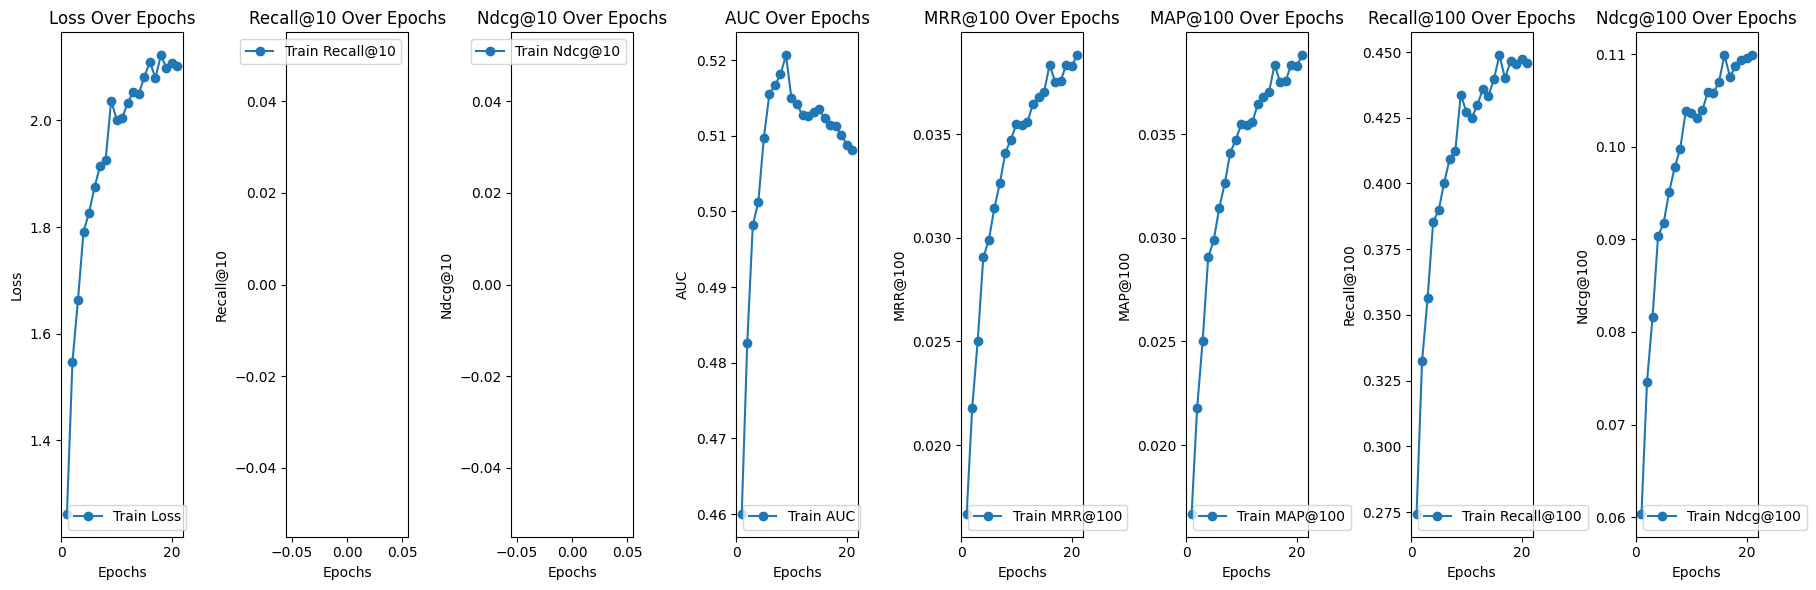

In [77]:
_history = train_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
# train_evaluation_clbk.get_records()
plot_metrics(_history, None, default_plot_metrics | {'AUC': AUC_TERM, 'MRR@100': 'mrr_at_100', 'MAP@100':'map_at_100', **METRIC_AT})


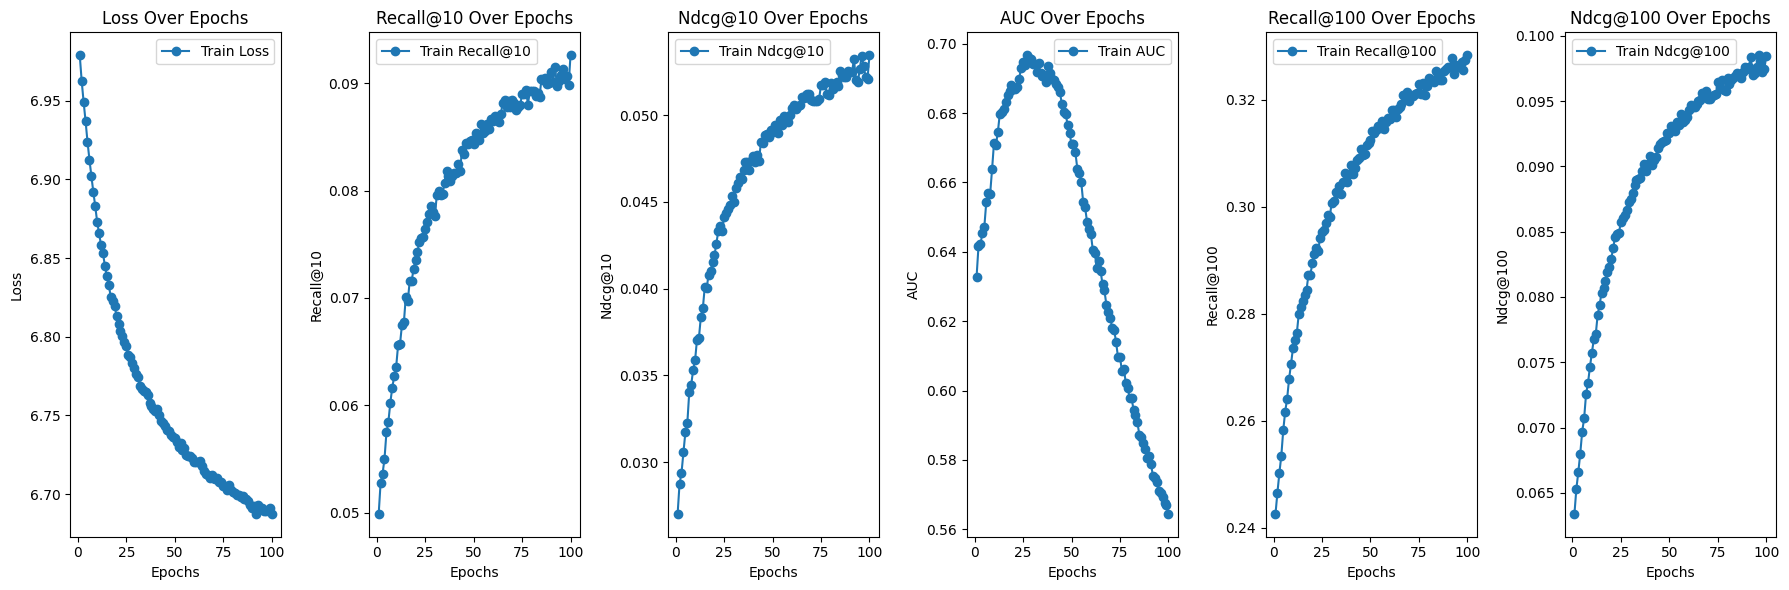

In [78]:
_history = merge_model_history(*history_v6)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': AUC_TERM, **METRIC_AT})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

In [79]:
def catalog_coverage(recommended_items_list, catalog_items):
    # Flatten the list of recommended items and convert it to a set
    unique_recommended_items = set(item for sublist in recommended_items_list for item in sublist)

    # Calculate the intersection of unique recommended items and catalog items
    covered_items = unique_recommended_items.intersection(catalog_items)

    # Calculate the catalog coverage
    coverage = len(covered_items) / len(catalog_items)
    return coverage

#### eval

In [80]:
(model_v6.evaluate(train, batch_size=2048, return_dict=True),
 model_v6.evaluate(valid, batch_size=2048, return_dict=True))

8/8 [==============================] - 1s 52ms/step - loss: 8.0147 - auc_6: 0.5387 - recall_at_100: 0.1059 - mrr_at_100: 0.0163 - ndcg_at_100: 0.0310 - map_at_100: 0.0163 - precision_at_100: 0.0011 - recall_at_10: 0.0191 - mrr_at_10: 0.0142 - ndcg_at_10: 0.0153 - map_at_10: 0.0142 - precision_at_10: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 7.9873


({'loss': 6.61877965927124,
  'auc_6': 0.5631539821624756,
  'recall_at_100': 0.34621521830558777,
  'mrr_at_100': 0.05748311057686806,
  'ndcg_at_100': 0.10916952788829803,
  'map_at_100': 0.05748311057686806,
  'precision_at_100': 0.003462152322754264,
  'recall_at_10': 0.10449844598770142,
  'mrr_at_10': 0.05002818629145622,
  'ndcg_at_10': 0.06271590292453766,
  'map_at_10': 0.05002818629145622,
  'precision_at_10': 0.010449844412505627,
  'regularization_loss': 0.0,
  'loss_batch': 4.596968650817871},
 {'loss': 8.014735221862793,
  'auc_6': 0.5387187004089355,
  'recall_at_100': 0.11936605721712112,
  'mrr_at_100': 0.013859840109944344,
  'ndcg_at_100': 0.03125910460948944,
  'map_at_100': 0.013859840109944344,
  'precision_at_100': 0.001193660544231534,
  'recall_at_10': 0.017854753881692886,
  'mrr_at_10': 0.011341606266796589,
  'ndcg_at_10': 0.01279793307185173,
  'map_at_10': 0.011341606266796589,
  'precision_at_10': 0.0017854755278676748,
  'regularization_loss': 0.0,
  'lo

In [81]:
evaluate_model(model_v6, train, topk=100)

Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 3s 16ms/step - loss: 2.1021 - auc_28: 0.5081 - recall_at_100: 0.4446 - mrr_at_100: 0.0378 - ndcg_at_100: 0.1088 - map_at_100: 0.0378 - precision_at_100: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 2.1153


{'loss': 2.102074384689331,
 'auc_28': 0.5081413984298706,
 'recall_at_100': 0.44588473439216614,
 'mrr_at_100': 0.03881990909576416,
 'ndcg_at_100': 0.10989055782556534,
 'map_at_100': 0.03881990909576416,
 'precision_at_100': 0.004458846990019083,
 'regularization_loss': 0.0,
 'loss_batch': 2.7448911666870117}

In [82]:
evaluate_model(model_v6, valid, topk=100)

Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 27ms/step - loss: 1.0052 - auc_29: 0.5075 - recall_at_100: 0.1919 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0360 - map_at_100: 0.0058 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0471


{'loss': 1.0051841735839844,
 'auc_29': 0.5074682235717773,
 'recall_at_100': 0.19372743368148804,
 'mrr_at_100': 0.005915628746151924,
 'ndcg_at_100': 0.03638595715165138,
 'map_at_100': 0.005915628746151924,
 'precision_at_100': 0.0019372743554413319,
 'regularization_loss': 0.0,
 'loss_batch': 1.4852039813995361}

### model_v7

In [106]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = [64, 64] # @param

_learning_rate = 0.01 # @param
# _batch_size = 4096 # @param
_batch_size = 1024 * 2# @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = 1024 * 2# @param
# _popularity_sampler = True
_validation_freq = 5 # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [107]:
from merlin.models.tf.outputs.sampling.popularity import PopularityBasedSamplerV2
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

# sampler = [PopularityBasedSamplerV2(
#     max_id=train.schema['movie_id'].properties['embedding_sizes']['cardinality'] - 1,
#     min_id=0, max_num_samples=_sample_neg
# )] if _popularity_sampler else []

sampler = [InBatchSamplerV2(_sample_neg)]

model_v7 = build_towers(train.schema, tower_dim=_tower_dim,
                        neg_sampler=sampler, embedding_dims=embedding_dims)
TOP_K = [100, 10]
model_v7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
train_evaluation_clbk_v7 = EvaluationCallback(period=5, topk=100, data=train, type_='Train')
valid_evaluation_clbk_v7 = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation')
history_v7 = []


#### model

In [108]:
# %pdb on
# _epochs = 10
history_v7.append(
    model_v7.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk_v7, valid_evaluation_clbk_v7], verbose=1)
)

Epoch 1/50
35/35 [==============================] - 30s 348ms/step - loss: 7.5116 - auc_198: 0.5792 - recall_at_100: 0.0675 - mrr_at_100: 0.0049 - ndcg_at_100: 0.0153 - map_at_100: 0.0049 - precision_at_100: 6.7465e-04 - recall_at_10: 0.0076 - mrr_at_10: 0.0033 - ndcg_at_10: 0.0043 - map_at_10: 0.0033 - precision_at_10: 7.6053e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4420
Epoch 2/50
35/35 [==============================] - 7s 169ms/step - loss: 7.2342 - auc_198: 0.6148 - recall_at_100: 0.1550 - mrr_at_100: 0.0109 - ndcg_at_100: 0.0352 - map_at_100: 0.0109 - precision_at_100: 0.0015 - recall_at_10: 0.0204 - mrr_at_10: 0.0073 - ndcg_at_10: 0.0103 - map_at_10: 0.0073 - precision_at_10: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 7.1694
Epoch 3/50
35/35 [==============================] - 5s 114ms/step - loss: 7.1384 - auc_198: 0.6209 - recall_at_100: 0.1864 - mrr_at_100: 0.0145 - ndcg_at_100: 0.0439 - map_at_100: 0.0145 - precision_at_100: 0.0019 - recall_at_10: 0.0

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.2990 - auc_199: 0.4505 - recall_at_100: 0.2796 - mrr_at_100: 0.0171 - ndcg_at_100: 0.0613 - map_at_100: 0.0171 - precision_at_100: 0.0028 - regularization_loss: 0.0000e+00 - loss_batch: 1.3063
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.298954963684082, 'auc_199': 0.4505051374435425, 'recall_at_100': 0.28027692437171936, 'mrr_at_100': 0.016938675194978714, 'ndcg_at_100': 0.06132299080491066, 'map_at_100': 0.016938675194978714, 'precision_at_100': 0.0028027694206684828, 'regularization_loss': 0.0, 'loss_batch': 1.655164361000061, 'coverage': 0.9987187700192185, 'novelty': 0.031245858184227964}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 31ms/step - loss: 0.8814 - auc_200: 0.4534 - recall_at_100: 0.1814 - mrr_at_100: 0.0082 - ndcg_at_100: 0.0367 - map_at_100: 0.0082 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9504
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8813524842262268, 'auc_200': 0.4534108638763428, 'recall_at_100': 0.18683964014053345, 'mrr_at_100': 0.008745070546865463, 'ndcg_at_100': 0.03811110556125641, 'map_at_100': 0.008745070546865463, 'precision_at_100': 0.0018683962989598513, 'regularization_loss': 0.0, 'loss_batch': 1.6728843450546265, 'coverage': 1.0, 'novelty': 0.15172968624296057}
35/35 [==============================] - 28s 798ms/step - loss: 7.0339 - auc_198: 0.6287 - recall_at_100: 0.2277 - mrr_at_100: 0.0218 - ndcg_at_100: 0.0575 - map_at_100: 0.0218 - precision_at_100: 0.0023 - recall_at_10: 0.0443 - mrr_at_10: 0.0166 - ndcg_at_10: 0.0230 - map_at_10: 0.0166 - precision_at_10: 0.0044 - regulari

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 94ms/step - loss: 7.0066 - auc_198: 0.6374 - recall_at_100: 0.2393 - mrr_at_100: 0.0249 - ndcg_at_100: 0.0621 - map_at_100: 0.0249 - precision_at_100: 0.0024 - recall_at_10: 0.0492 - mrr_at_10: 0.0194 - ndcg_at_10: 0.0263 - map_at_10: 0.0194 - precision_at_10: 0.0049 - regularization_loss: 0.0000e+00 - loss_batch: 6.9356
Epoch 7/50
35/35 [==============================] - 3s 59ms/step - loss: 6.9821 - auc_198: 0.6447 - recall_at_100: 0.2443 - mrr_at_100: 0.0264 - ndcg_at_100: 0.0643 - map_at_100: 0.0264 - precision_at_100: 0.0024 - recall_at_10: 0.0512 - mrr_at_10: 0.0208 - ndcg_at_10: 0.0278 - map_at_10: 0.0208 - precision_at_10: 0.0051 - regularization_loss: 0.0000e+00 - loss_batch: 6.9095
Epoch 8/50
35/35 [==============================] - 2s 46ms/step - loss: 6.9615 - auc_198: 0.6580 - recall_at_100: 0.2531 - mrr_at_100: 0.0281 - ndcg_at_100: 0.0673 - map_at_100: 0.0281 - precision_at_100: 0.0025 - recall_at_10: 0.0541 - mrr_at_10: 0.0222

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 25ms/step - loss: 1.5335 - auc_201: 0.4856 - recall_at_100: 0.3317 - mrr_at_100: 0.0228 - ndcg_at_100: 0.0756 - map_at_100: 0.0228 - precision_at_100: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 1.5449


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.5334762334823608, 'auc_201': 0.485598087310791, 'recall_at_100': 0.33142930269241333, 'mrr_at_100': 0.02302197553217411, 'ndcg_at_100': 0.07569928467273712, 'map_at_100': 0.02302197553217411, 'precision_at_100': 0.0033142929896712303, 'regularization_loss': 0.0, 'loss_batch': 2.0892581939697266, 'coverage': 1.0, 'novelty': 0.03681867874433859}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 23ms/step - loss: 0.9273 - auc_202: 0.4758 - recall_at_100: 0.1844 - mrr_at_100: 0.0074 - ndcg_at_100: 0.0366 - map_at_100: 0.0074 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9818
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9272767305374146, 'auc_202': 0.47583693265914917, 'recall_at_100': 0.19359368085861206, 'mrr_at_100': 0.008268868550658226, 'ndcg_at_100': 0.038851551711559296, 'map_at_100': 0.008268868550658226, 'precision_at_100': 0.0019359367433935404, 'regularization_loss': 0.0, 'loss_batch': 1.552233338356018, 'coverage': 1.0, 'novelty': 0.16690265486725664}
35/35 [==============================] - 61s 2s/step - loss: 6.9270 - auc_198: 0.6704 - recall_at_100: 0.2607 - mrr_at_100: 0.0310 - ndcg_at_100: 0.0712 - map_at_100: 0.0310 - precision_at_100: 0.0026 - recall_at_10: 0.0596 - mrr_at_10: 0.0251 - ndcg_at_10: 0.0330 - map_at_10: 0.0251 - precision_at_10: 0.0060 - regulariza

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 67ms/step - loss: 6.9123 - auc_198: 0.6703 - recall_at_100: 0.2686 - mrr_at_100: 0.0326 - ndcg_at_100: 0.0739 - map_at_100: 0.0326 - precision_at_100: 0.0027 - recall_at_10: 0.0619 - mrr_at_10: 0.0266 - ndcg_at_10: 0.0347 - map_at_10: 0.0266 - precision_at_10: 0.0062 - regularization_loss: 0.0000e+00 - loss_batch: 6.8357
Epoch 12/50
35/35 [==============================] - 2s 50ms/step - loss: 6.8969 - auc_198: 0.6729 - recall_at_100: 0.2734 - mrr_at_100: 0.0345 - ndcg_at_100: 0.0763 - map_at_100: 0.0345 - precision_at_100: 0.0027 - recall_at_10: 0.0647 - mrr_at_10: 0.0284 - ndcg_at_10: 0.0368 - map_at_10: 0.0284 - precision_at_10: 0.0065 - regularization_loss: 0.0000e+00 - loss_batch: 6.8193
Epoch 13/50
35/35 [==============================] - 3s 69ms/step - loss: 6.8857 - auc_198: 0.6701 - recall_at_100: 0.2777 - mrr_at_100: 0.0346 - ndcg_at_100: 0.0772 - map_at_100: 0.0346 - precision_at_100: 0.0028 - recall_at_10: 0.0649 - mrr_at_10: 0.02

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 32ms/step - loss: 1.7056 - auc_203: 0.5203 - recall_at_100: 0.3702 - mrr_at_100: 0.0275 - ndcg_at_100: 0.0865 - map_at_100: 0.0275 - precision_at_100: 0.0037 - regularization_loss: 0.0000e+00 - loss_batch: 1.7167


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7056020498275757, 'auc_203': 0.5202908515930176, 'recall_at_100': 0.36833709478378296, 'mrr_at_100': 0.0277907345443964, 'ndcg_at_100': 0.08633054792881012, 'map_at_100': 0.0277907345443964, 'precision_at_100': 0.0036833705380558968, 'regularization_loss': 0.0, 'loss_batch': 2.242225408554077, 'coverage': 1.0, 'novelty': 0.036539057656540606}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 22ms/step - loss: 0.9845 - auc_204: 0.5253 - recall_at_100: 0.2005 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0390 - map_at_100: 0.0073 - precision_at_100: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 1.0239
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.984454333782196, 'auc_204': 0.5252748727798462, 'recall_at_100': 0.20295573770999908, 'mrr_at_100': 0.007691763341426849, 'ndcg_at_100': 0.03983089327812195, 'map_at_100': 0.007691763341426849, 'precision_at_100': 0.0020295572467148304, 'regularization_loss': 0.0, 'loss_batch': 1.4367209672927856, 'coverage': 1.0, 'novelty': 0.1585406859448554}
35/35 [==============================] - 21s 600ms/step - loss: 6.8643 - auc_198: 0.6723 - recall_at_100: 0.2830 - mrr_at_100: 0.0363 - ndcg_at_100: 0.0797 - map_at_100: 0.0363 - precision_at_100: 0.0028 - recall_at_10: 0.0706 - mrr_at_10: 0.0301 - ndcg_at_10: 0.0394 - map_at_10: 0.0301 - precision_at_10: 0.0071 - regulariza

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 48ms/step - loss: 6.8519 - auc_198: 0.6712 - recall_at_100: 0.2891 - mrr_at_100: 0.0371 - ndcg_at_100: 0.0814 - map_at_100: 0.0371 - precision_at_100: 0.0029 - recall_at_10: 0.0705 - mrr_at_10: 0.0307 - ndcg_at_10: 0.0399 - map_at_10: 0.0307 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 6.7699
Epoch 17/50
35/35 [==============================] - 2s 51ms/step - loss: 6.8451 - auc_198: 0.6694 - recall_at_100: 0.2858 - mrr_at_100: 0.0384 - ndcg_at_100: 0.0819 - map_at_100: 0.0384 - precision_at_100: 0.0029 - recall_at_10: 0.0702 - mrr_at_10: 0.0320 - ndcg_at_10: 0.0409 - map_at_10: 0.0320 - precision_at_10: 0.0070 - regularization_loss: 0.0000e+00 - loss_batch: 6.7624
Epoch 18/50
35/35 [==============================] - 4s 92ms/step - loss: 6.8360 - auc_198: 0.6729 - recall_at_100: 0.2912 - mrr_at_100: 0.0400 - ndcg_at_100: 0.0842 - map_at_100: 0.0400 - precision_at_100: 0.0029 - recall_at_10: 0.0740 - mrr_at_10: 0.03

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 8s 33ms/step - loss: 1.7775 - auc_205: 0.5331 - recall_at_100: 0.3754 - mrr_at_100: 0.0285 - ndcg_at_100: 0.0881 - map_at_100: 0.0285 - precision_at_100: 0.0038 - regularization_loss: 0.0000e+00 - loss_batch: 1.7916
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7774816751480103, 'auc_205': 0.5331145524978638, 'recall_at_100': 0.378849595785141, 'mrr_at_100': 0.028685087338089943, 'ndcg_at_100': 0.08885210007429123, 'map_at_100': 0.028685087338089943, 'precision_at_100': 0.003788495436310768, 'regularization_loss': 0.0, 'loss_batch': 2.460714101791382, 'coverage': 1.0, 'novelty': 0.04900228642693826}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 25ms/step - loss: 0.9595 - auc_206: 0.5427 - recall_at_100: 0.1874 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0359 - map_at_100: 0.0063 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0151
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9594569802284241, 'auc_206': 0.5426599979400635, 'recall_at_100': 0.19285809993743896, 'mrr_at_100': 0.0071177007630467415, 'ndcg_at_100': 0.03762444108724594, 'map_at_100': 0.0071177007630467415, 'precision_at_100': 0.0019285808084532619, 'regularization_loss': 0.0, 'loss_batch': 1.5975112915039062, 'coverage': 1.0, 'novelty': 0.1989031849820713}
35/35 [==============================] - 22s 631ms/step - loss: 6.8220 - auc_198: 0.6743 - recall_at_100: 0.2962 - mrr_at_100: 0.0402 - ndcg_at_100: 0.0853 - map_at_100: 0.0402 - precision_at_100: 0.0030 - recall_at_10: 0.0743 - mrr_at_10: 0.0336 - ndcg_at_10: 0.0430 - map_at_10: 0.0336 - precision_at_10: 0.0074 - regular

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 49ms/step - loss: 6.8184 - auc_198: 0.6780 - recall_at_100: 0.2975 - mrr_at_100: 0.0400 - ndcg_at_100: 0.0853 - map_at_100: 0.0400 - precision_at_100: 0.0030 - recall_at_10: 0.0751 - mrr_at_10: 0.0334 - ndcg_at_10: 0.0431 - map_at_10: 0.0334 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 6.7326
Epoch 22/50
35/35 [==============================] - 2s 50ms/step - loss: 6.8091 - auc_198: 0.6768 - recall_at_100: 0.3016 - mrr_at_100: 0.0407 - ndcg_at_100: 0.0866 - map_at_100: 0.0407 - precision_at_100: 0.0030 - recall_at_10: 0.0756 - mrr_at_10: 0.0341 - ndcg_at_10: 0.0437 - map_at_10: 0.0341 - precision_at_10: 0.0076 - regularization_loss: 0.0000e+00 - loss_batch: 6.7230
Epoch 23/50
35/35 [==============================] - 3s 78ms/step - loss: 6.8045 - auc_198: 0.6753 - recall_at_100: 0.2983 - mrr_at_100: 0.0413 - ndcg_at_100: 0.0866 - map_at_100: 0.0413 - precision_at_100: 0.0030 - recall_at_10: 0.0768 - mrr_at_10: 0.03

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 33ms/step - loss: 1.8138 - auc_207: 0.5301 - recall_at_100: 0.3856 - mrr_at_100: 0.0296 - ndcg_at_100: 0.0910 - map_at_100: 0.0296 - precision_at_100: 0.0039 - regularization_loss: 0.0000e+00 - loss_batch: 1.8270
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8138413429260254, 'auc_207': 0.5300570130348206, 'recall_at_100': 0.3872966468334198, 'mrr_at_100': 0.031174596399068832, 'ndcg_at_100': 0.09267285466194153, 'map_at_100': 0.031174596399068832, 'precision_at_100': 0.003872966393828392, 'regularization_loss': 0.0, 'loss_batch': 2.4509434700012207, 'coverage': 1.0, 'novelty': 0.03980078504199553}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 22ms/step - loss: 0.9661 - auc_208: 0.5465 - recall_at_100: 0.1860 - mrr_at_100: 0.0070 - ndcg_at_100: 0.0364 - map_at_100: 0.0070 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0221
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.966052770614624, 'auc_208': 0.5465431213378906, 'recall_at_100': 0.19305871427059174, 'mrr_at_100': 0.007173918187618256, 'ndcg_at_100': 0.037651192396879196, 'map_at_100': 0.007173918187618256, 'precision_at_100': 0.0019305871101096272, 'regularization_loss': 0.0, 'loss_batch': 1.6083283424377441, 'coverage': 1.0, 'novelty': 0.17055525411466813}
35/35 [==============================] - 20s 579ms/step - loss: 6.7950 - auc_198: 0.6767 - recall_at_100: 0.3005 - mrr_at_100: 0.0417 - ndcg_at_100: 0.0874 - map_at_100: 0.0417 - precision_at_100: 0.0030 - recall_at_10: 0.0771 - mrr_at_10: 0.0351 - ndcg_at_10: 0.0448 - map_at_10: 0.0351 - precision_at_10: 0.0077 - regulari

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 52ms/step - loss: 6.7879 - auc_198: 0.6741 - recall_at_100: 0.3047 - mrr_at_100: 0.0429 - ndcg_at_100: 0.0892 - map_at_100: 0.0429 - precision_at_100: 0.0030 - recall_at_10: 0.0805 - mrr_at_10: 0.0362 - ndcg_at_10: 0.0465 - map_at_10: 0.0362 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 6.6996
Epoch 27/50
35/35 [==============================] - 2s 45ms/step - loss: 6.7855 - auc_198: 0.6719 - recall_at_100: 0.3044 - mrr_at_100: 0.0428 - ndcg_at_100: 0.0891 - map_at_100: 0.0428 - precision_at_100: 0.0030 - recall_at_10: 0.0805 - mrr_at_10: 0.0361 - ndcg_at_10: 0.0465 - map_at_10: 0.0361 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 6.6965
Epoch 28/50
35/35 [==============================] - 3s 56ms/step - loss: 6.7793 - auc_198: 0.6701 - recall_at_100: 0.3056 - mrr_at_100: 0.0430 - ndcg_at_100: 0.0893 - map_at_100: 0.0430 - precision_at_100: 0.0031 - recall_at_10: 0.0790 - mrr_at_10: 0.03

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 26ms/step - loss: 1.8836 - auc_209: 0.5359 - recall_at_100: 0.4007 - mrr_at_100: 0.0333 - ndcg_at_100: 0.0968 - map_at_100: 0.0333 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.8982


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8836113214492798, 'auc_209': 0.5358928442001343, 'recall_at_100': 0.40178343653678894, 'mrr_at_100': 0.03353896737098694, 'ndcg_at_100': 0.09730035811662674, 'map_at_100': 0.03353896737098694, 'precision_at_100': 0.004017834085971117, 'regularization_loss': 0.0, 'loss_batch': 2.5927510261535645, 'coverage': 1.0, 'novelty': 0.04051209348283714}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 35ms/step - loss: 0.9375 - auc_210: 0.5491 - recall_at_100: 0.1801 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0348 - map_at_100: 0.0065 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9831
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9374731183052063, 'auc_210': 0.5490848422050476, 'recall_at_100': 0.18530158698558807, 'mrr_at_100': 0.00650352519005537, 'ndcg_at_100': 0.035687804222106934, 'map_at_100': 0.00650352519005537, 'precision_at_100': 0.0018530158558860421, 'regularization_loss': 0.0, 'loss_batch': 1.4603477716445923, 'coverage': 1.0, 'novelty': 0.17975600457491422}
35/35 [==============================] - 26s 741ms/step - loss: 6.7732 - auc_198: 0.6636 - recall_at_100: 0.3101 - mrr_at_100: 0.0448 - ndcg_at_100: 0.0916 - map_at_100: 0.0448 - precision_at_100: 0.0031 - recall_at_10: 0.0823 - mrr_at_10: 0.0380 - ndcg_at_10: 0.0483 - map_at_10: 0.0380 - precision_at_10: 0.0082 - regulariz

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Epoch 31/50
35/35 [==============================] - 3s 54ms/step - loss: 6.7675 - auc_198: 0.6624 - recall_at_100: 0.3118 - mrr_at_100: 0.0439 - ndcg_at_100: 0.0912 - map_at_100: 0.0439 - precision_at_100: 0.0031 - recall_at_10: 0.0819 - mrr_at_10: 0.0370 - ndcg_at_10: 0.0474 - map_at_10: 0.0370 - precision_at_10: 0.0082 - regularization_loss: 0.0000e+00 - loss_batch: 6.6771
Epoch 32/50
35/35 [==============================] - 2s 50ms/step - loss: 6.7630 - auc_198: 0.6612 - recall_at_100: 0.3126 - mrr_at_100: 0.0450 - ndcg_at_100: 0.0924 - map_at_100: 0.0450 - precision_at_100: 0.0031 - recall_at_10: 0.0840 - mrr_at_10: 0.0382 - ndcg_at_10: 0.0488 - map_at_10: 0.0382 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 6.6729
Epoch 33/50
35/35 [==============================] - 2s 44ms/step - loss: 6.7584 - auc_198: 0.6593 - recall_at_100: 0.3112 - mrr_at_100: 0.0449 - ndcg_at_100: 0.0920 - map_at_100: 0.0449 - precision_at_100: 0.0031 - recall_at_10: 0.0826 - mrr

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 21ms/step - loss: 1.9368 - auc_211: 0.5414 - recall_at_100: 0.4158 - mrr_at_100: 0.0352 - ndcg_at_100: 0.1015 - map_at_100: 0.0352 - precision_at_100: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 1.9508


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9367942810058594, 'auc_211': 0.541359543800354, 'recall_at_100': 0.41753795742988586, 'mrr_at_100': 0.03578941524028778, 'ndcg_at_100': 0.10231344401836395, 'map_at_100': 0.03578941524028778, 'precision_at_100': 0.0041753798723220825, 'regularization_loss': 0.0, 'loss_batch': 2.6162304878234863, 'coverage': 1.0, 'novelty': 0.03797672264508075}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 34ms/step - loss: 0.9218 - auc_212: 0.5528 - recall_at_100: 0.1783 - mrr_at_100: 0.0060 - ndcg_at_100: 0.0340 - map_at_100: 0.0060 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9711
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9217783212661743, 'auc_212': 0.5528431534767151, 'recall_at_100': 0.1830279529094696, 'mrr_at_100': 0.006421639118343592, 'ndcg_at_100': 0.035173360258340836, 'map_at_100': 0.006421639118343592, 'precision_at_100': 0.0018302794778719544, 'regularization_loss': 0.0, 'loss_batch': 1.4867924451828003, 'coverage': 1.0, 'novelty': 0.17685671417854462}
35/35 [==============================] - 24s 675ms/step - loss: 6.7542 - auc_198: 0.6508 - recall_at_100: 0.3158 - mrr_at_100: 0.0460 - ndcg_at_100: 0.0938 - map_at_100: 0.0460 - precision_at_100: 0.0032 - recall_at_10: 0.0860 - mrr_at_10: 0.0391 - ndcg_at_10: 0.0500 - map_at_10: 0.0391 - precision_at_10: 0.0086 - regulari

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 71ms/step - loss: 6.7501 - auc_198: 0.6454 - recall_at_100: 0.3197 - mrr_at_100: 0.0458 - ndcg_at_100: 0.0944 - map_at_100: 0.0458 - precision_at_100: 0.0032 - recall_at_10: 0.0861 - mrr_at_10: 0.0387 - ndcg_at_10: 0.0497 - map_at_10: 0.0387 - precision_at_10: 0.0086 - regularization_loss: 0.0000e+00 - loss_batch: 6.6588
Epoch 37/50
35/35 [==============================] - 2s 45ms/step - loss: 6.7463 - auc_198: 0.6433 - recall_at_100: 0.3178 - mrr_at_100: 0.0460 - ndcg_at_100: 0.0941 - map_at_100: 0.0460 - precision_at_100: 0.0032 - recall_at_10: 0.0860 - mrr_at_10: 0.0392 - ndcg_at_10: 0.0500 - map_at_10: 0.0392 - precision_at_10: 0.0086 - regularization_loss: 0.0000e+00 - loss_batch: 6.6551
Epoch 38/50
35/35 [==============================] - 2s 46ms/step - loss: 6.7441 - auc_198: 0.6399 - recall_at_100: 0.3214 - mrr_at_100: 0.0468 - ndcg_at_100: 0.0955 - map_at_100: 0.0468 - precision_at_100: 0.0032 - recall_at_10: 0.0869 - mrr_at_10: 0.03

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 21ms/step - loss: 1.9705 - auc_213: 0.5404 - recall_at_100: 0.4158 - mrr_at_100: 0.0349 - ndcg_at_100: 0.1012 - map_at_100: 0.0349 - precision_at_100: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 1.9843
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9704533815383911, 'auc_213': 0.5403853058815002, 'recall_at_100': 0.4184211194515228, 'mrr_at_100': 0.035848457366228104, 'ndcg_at_100': 0.10242088884115219, 'map_at_100': 0.035848457366228104, 'precision_at_100': 0.004184212069958448, 'regularization_loss': 0.0, 'loss_batch': 2.6409366130828857, 'coverage': 1.0, 'novelty': 0.0450743272310119}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 22ms/step - loss: 0.9421 - auc_214: 0.5455 - recall_at_100: 0.1761 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0332 - map_at_100: 0.0056 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9902
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9420998096466064, 'auc_214': 0.5454734563827515, 'recall_at_100': 0.18262672424316406, 'mrr_at_100': 0.005956735927611589, 'ndcg_at_100': 0.03459654375910759, 'map_at_100': 0.005956735927611589, 'precision_at_100': 0.0018262672238051891, 'regularization_loss': 0.0, 'loss_batch': 1.4928243160247803, 'coverage': 1.0, 'novelty': 0.18425166080500194}
35/35 [==============================] - 20s 564ms/step - loss: 6.7373 - auc_198: 0.6315 - recall_at_100: 0.3199 - mrr_at_100: 0.0470 - ndcg_at_100: 0.0953 - map_at_100: 0.0470 - precision_at_100: 0.0032 - recall_at_10: 0.0869 - mrr_at_10: 0.0401 - ndcg_at_10: 0.0509 - map_at_10: 0.0401 - precision_at_10: 0.0087 - regulari

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 68ms/step - loss: 6.7360 - auc_198: 0.6319 - recall_at_100: 0.3246 - mrr_at_100: 0.0480 - ndcg_at_100: 0.0970 - map_at_100: 0.0480 - precision_at_100: 0.0032 - recall_at_10: 0.0886 - mrr_at_10: 0.0408 - ndcg_at_10: 0.0519 - map_at_10: 0.0408 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 6.6440
Epoch 42/50
35/35 [==============================] - 4s 68ms/step - loss: 6.7326 - auc_198: 0.6251 - recall_at_100: 0.3226 - mrr_at_100: 0.0471 - ndcg_at_100: 0.0958 - map_at_100: 0.0471 - precision_at_100: 0.0032 - recall_at_10: 0.0858 - mrr_at_10: 0.0401 - ndcg_at_10: 0.0507 - map_at_10: 0.0401 - precision_at_10: 0.0086 - regularization_loss: 0.0000e+00 - loss_batch: 6.6391
Epoch 43/50
35/35 [==============================] - 3s 62ms/step - loss: 6.7335 - auc_198: 0.6231 - recall_at_100: 0.3222 - mrr_at_100: 0.0471 - ndcg_at_100: 0.0959 - map_at_100: 0.0471 - precision_at_100: 0.0032 - recall_at_10: 0.0887 - mrr_at_10: 0.04

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 7s 33ms/step - loss: 2.0283 - auc_215: 0.5369 - recall_at_100: 0.4262 - mrr_at_100: 0.0367 - ndcg_at_100: 0.1044 - map_at_100: 0.0367 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0420


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.028308391571045, 'auc_215': 0.5369393825531006, 'recall_at_100': 0.43098488450050354, 'mrr_at_100': 0.03675824776291847, 'ndcg_at_100': 0.10539339482784271, 'map_at_100': 0.03675824776291847, 'precision_at_100': 0.004309849347919226, 'regularization_loss': 0.0, 'loss_batch': 2.6900181770324707, 'coverage': 1.0, 'novelty': 0.04477895436630419}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 23ms/step - loss: 0.9057 - auc_216: 0.5409 - recall_at_100: 0.1722 - mrr_at_100: 0.0054 - ndcg_at_100: 0.0323 - map_at_100: 0.0054 - precision_at_100: 0.0017 - regularization_loss: 0.0000e+00 - loss_batch: 0.9491
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.905724048614502, 'auc_216': 0.540865421295166, 'recall_at_100': 0.17527082562446594, 'mrr_at_100': 0.005783258005976677, 'ndcg_at_100': 0.03330904245376587, 'map_at_100': 0.005783258005976677, 'precision_at_100': 0.0017527081072330475, 'regularization_loss': 0.0, 'loss_batch': 1.4027488231658936, 'coverage': 1.0, 'novelty': 0.18732618196265396}
35/35 [==============================] - 24s 676ms/step - loss: 6.7261 - auc_198: 0.6157 - recall_at_100: 0.3245 - mrr_at_100: 0.0475 - ndcg_at_100: 0.0967 - map_at_100: 0.0475 - precision_at_100: 0.0032 - recall_at_10: 0.0896 - mrr_at_10: 0.0405 - ndcg_at_10: 0.0519 - map_at_10: 0.0405 - precision_at_10: 0.0090 - regulariza

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 58ms/step - loss: 6.7243 - auc_198: 0.6116 - recall_at_100: 0.3238 - mrr_at_100: 0.0475 - ndcg_at_100: 0.0966 - map_at_100: 0.0475 - precision_at_100: 0.0032 - recall_at_10: 0.0894 - mrr_at_10: 0.0404 - ndcg_at_10: 0.0517 - map_at_10: 0.0404 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 6.6306
Epoch 47/50
35/35 [==============================] - 3s 67ms/step - loss: 6.7219 - auc_198: 0.6074 - recall_at_100: 0.3234 - mrr_at_100: 0.0481 - ndcg_at_100: 0.0970 - map_at_100: 0.0481 - precision_at_100: 0.0032 - recall_at_10: 0.0898 - mrr_at_10: 0.0411 - ndcg_at_10: 0.0524 - map_at_10: 0.0411 - precision_at_10: 0.0090 - regularization_loss: 0.0000e+00 - loss_batch: 6.6284
Epoch 48/50
35/35 [==============================] - 2s 44ms/step - loss: 6.7227 - auc_198: 0.6037 - recall_at_100: 0.3260 - mrr_at_100: 0.0491 - ndcg_at_100: 0.0983 - map_at_100: 0.0491 - precision_at_100: 0.0033 - recall_at_10: 0.0907 - mrr_at_10: 0.04

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 21ms/step - loss: 2.0516 - auc_217: 0.5385 - recall_at_100: 0.4321 - mrr_at_100: 0.0363 - ndcg_at_100: 0.1051 - map_at_100: 0.0363 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0668
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0516183376312256, 'auc_217': 0.5384596586227417, 'recall_at_100': 0.4346172511577606, 'mrr_at_100': 0.037011850625276566, 'ndcg_at_100': 0.1061888113617897, 'map_at_100': 0.037011850625276566, 'precision_at_100': 0.004346171859651804, 'regularization_loss': 0.0, 'loss_batch': 2.790243625640869, 'coverage': 1.0, 'novelty': 0.047261063499223176}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 24ms/step - loss: 0.9492 - auc_218: 0.5387 - recall_at_100: 0.1785 - mrr_at_100: 0.0054 - ndcg_at_100: 0.0333 - map_at_100: 0.0054 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 1.0016
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.949222207069397, 'auc_218': 0.5387023091316223, 'recall_at_100': 0.1824261099100113, 'mrr_at_100': 0.005646600387990475, 'ndcg_at_100': 0.03429585322737694, 'map_at_100': 0.005646600387990475, 'precision_at_100': 0.0018242611549794674, 'regularization_loss': 0.0, 'loss_batch': 1.5491994619369507, 'coverage': 1.0, 'novelty': 0.18662180882643972}
35/35 [==============================] - 21s 612ms/step - loss: 6.7160 - auc_198: 0.6000 - recall_at_100: 0.3254 - mrr_at_100: 0.0485 - ndcg_at_100: 0.0975 - map_at_100: 0.0485 - precision_at_100: 0.0033 - recall_at_10: 0.0885 - mrr_at_10: 0.0414 - ndcg_at_10: 0.0523 - map_at_10: 0.0414 - precision_at_10: 0.0089 - regulariza

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


#### analysis

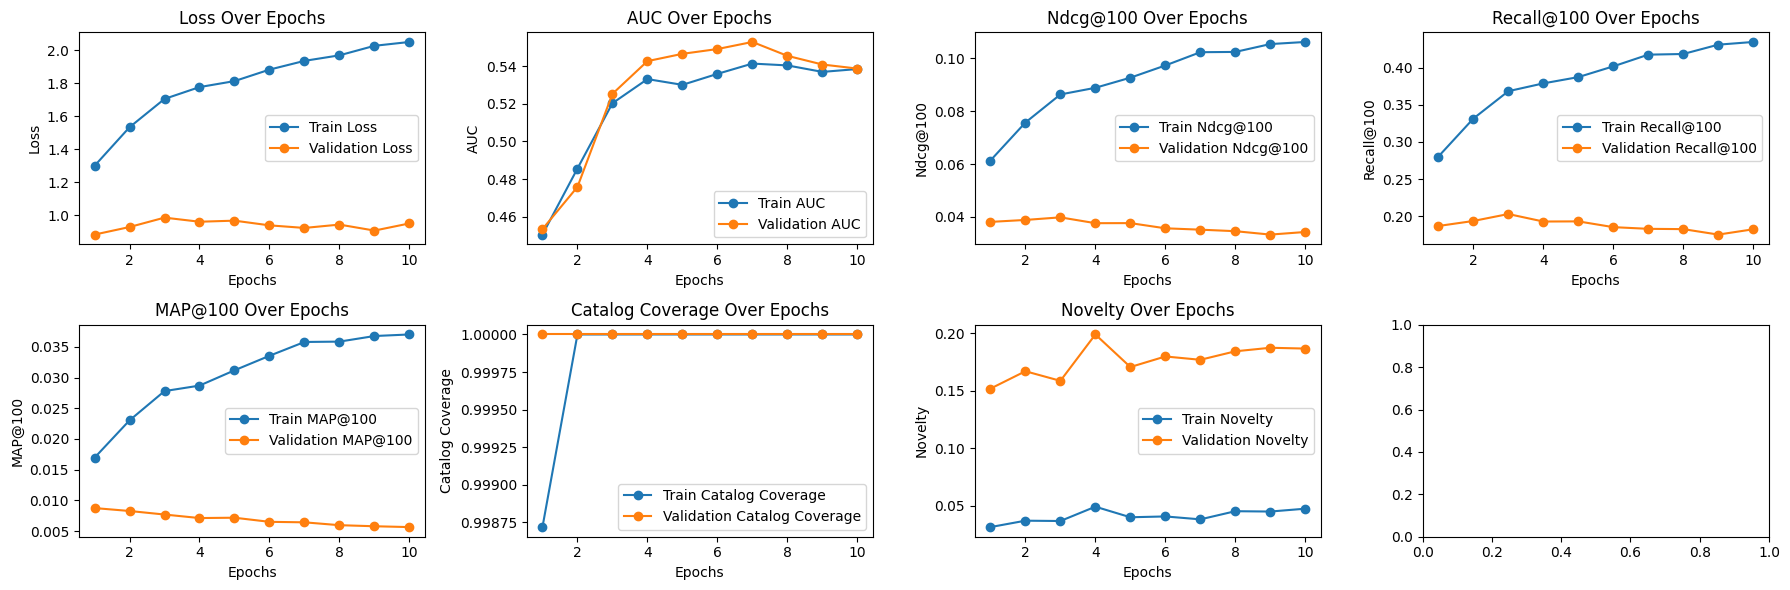

In [109]:
_history = train_evaluation_clbk_v7.get_records()
_history_val = valid_evaluation_clbk_v7.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
plot_metrics(_history, _history_val, _metrics)


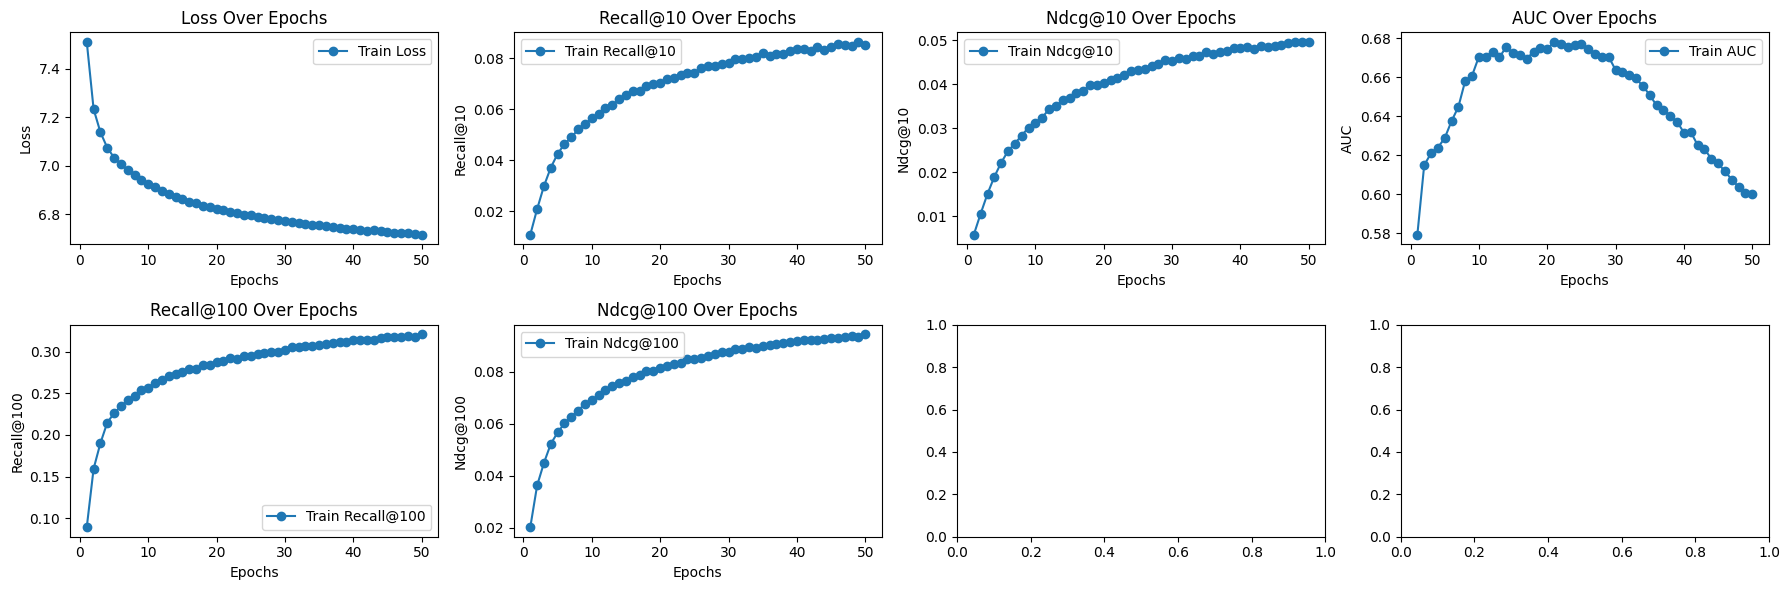

In [110]:
_history = merge_model_history(*history_v7)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': AUC_TERM, **METRIC_AT})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [30]:
(model_v7.evaluate(train, batch_size=2048, return_dict=True),
 model_v7.evaluate(valid, batch_size=2048, return_dict=True))

8/8 [==============================] - 1s 70ms/step - loss: 7.8620 - auc: 0.5681 - recall_at_100: 0.1212 - mrr_at_100: 0.0186 - ndcg_at_100: 0.0356 - map_at_100: 0.0186 - precision_at_100: 0.0012 - recall_at_10: 0.0227 - mrr_at_10: 0.0161 - ndcg_at_10: 0.0176 - map_at_10: 0.0161 - precision_at_10: 0.0023 - regularization_loss: 0.0000e+00 - loss_batch: 7.8307


({'loss': 6.699263095855713,
  'auc': 0.668052077293396,
  'recall_at_100': 0.3233526051044464,
  'mrr_at_100': 0.05222870782017708,
  'ndcg_at_100': 0.10056475549936295,
  'map_at_100': 0.05222870782017708,
  'precision_at_100': 0.0032335256692022085,
  'recall_at_10': 0.095282182097435,
  'mrr_at_10': 0.04530993476510048,
  'ndcg_at_10': 0.056927017867565155,
  'map_at_10': 0.04530993476510048,
  'precision_at_10': 0.00952821783721447,
  'regularization_loss': 0.0,
  'loss_batch': 4.1432576179504395},
 {'loss': 7.861959934234619,
  'auc': 0.5680776238441467,
  'recall_at_100': 0.13334225118160248,
  'mrr_at_100': 0.01585257612168789,
  'ndcg_at_100': 0.03536121919751167,
  'map_at_100': 0.01585257612168789,
  'precision_at_100': 0.0013334223767742515,
  'recall_at_10': 0.020997727289795876,
  'mrr_at_10': 0.012997585348784924,
  'ndcg_at_10': 0.014806998893618584,
  'map_at_10': 0.012997585348784924,
  'precision_at_10': 0.0020997729152441025,
  'regularization_loss': 0.0,
  'loss_ba

In [31]:
evaluate_model(model_v7, train, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.8865 - auc_21: 0.4858 - recall_at_100: 0.3987 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0950 - map_at_100: 0.0316 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9057
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 1.8864508867263794,
 'auc_21': 0.4857785701751709,
 'recall_at_100': 0.3994045853614807,
 'mrr_at_100': 0.03349835425615311,
 'ndcg_at_100': 0.09687190502882004,
 'map_at_100': 0.03349835425615311,
 'precision_at_100': 0.003994045313447714,
 'regularization_loss': 0.0,
 'loss_batch': 2.818242073059082,
 'coverage': 1.0,
 'novelty': 0.04531693017444375}

In [32]:
evaluate_model(model_v7, valid, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.9953 - auc_22: 0.4727 - recall_at_100: 0.1899 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0358 - map_at_100: 0.0059 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0450
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 0.9952747225761414,
 'auc_22': 0.4727213978767395,
 'recall_at_100': 0.19292497634887695,
 'mrr_at_100': 0.006211184896528721,
 'ndcg_at_100': 0.0365414135158062,
 'map_at_100': 0.006211184896528721,
 'precision_at_100': 0.0019292497308924794,
 'regularization_loss': 0.0,
 'loss_batch': 1.5650469064712524,
 'coverage': 1.0,
 'novelty': 0.18732618196265396}

### model_v8

In [35]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = [64, 32] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = 1024 # @param
# _popularity_sampler = True
_validation_freq = 5 # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [36]:
from merlin.models.tf.outputs.sampling.popularity import PopularityBasedSamplerV2
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

# sampler = [PopularityBasedSamplerV2(
#     max_id=train.schema['movie_id'].properties['embedding_sizes']['cardinality'] - 1,
#     min_id=0, max_num_samples=_sample_neg
# )] if _popularity_sampler else []

sampler = [InBatchSamplerV2(_sample_neg)]

model_v8 = build_towers(train.schema, tower_dim=_tower_dim,
                        neg_sampler=sampler, embedding_dims=embedding_dims)
TOP_K = [100, 10]
model_v8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
train_evaluation_clbk_v8 = EvaluationCallback(period=5, topk=100, data=train, type_='Train')
valid_evaluation_clbk_v8 = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation')
history_v8 = []


#### model

In [37]:
# %pdb on
# _epochs = 10
history_v8.append(
    model_v8.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk_v8,
                            valid_evaluation_clbk_v8],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 22s 345ms/step - loss: 7.5023 - auc_42: 0.5869 - recall_at_100: 0.0672 - mrr_at_100: 0.0047 - ndcg_at_100: 0.0151 - map_at_100: 0.0047 - precision_at_100: 6.7183e-04 - recall_at_10: 0.0077 - mrr_at_10: 0.0032 - ndcg_at_10: 0.0042 - map_at_10: 0.0032 - precision_at_10: 7.7126e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4335
Epoch 2/50
35/35 [==============================] - 5s 112ms/step - loss: 7.2374 - auc_42: 0.6032 - recall_at_100: 0.1566 - mrr_at_100: 0.0112 - ndcg_at_100: 0.0358 - map_at_100: 0.0112 - precision_at_100: 0.0016 - recall_at_10: 0.0216 - mrr_at_10: 0.0076 - ndcg_at_10: 0.0108 - map_at_10: 0.0076 - precision_at_10: 0.0022 - regularization_loss: 0.0000e+00 - loss_batch: 7.1725
Epoch 3/50
35/35 [==============================] - 4s 104ms/step - loss: 7.1536 - auc_42: 0.6034 - recall_at_100: 0.1861 - mrr_at_100: 0.0146 - ndcg_at_100: 0.0439 - map_at_100: 0.0146 - precision_at_100: 0.0019 - recall_at_10: 0.0287

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 29ms/step - loss: 1.2486 - auc_43: 0.4420 - recall_at_100: 0.2672 - mrr_at_100: 0.0165 - ndcg_at_100: 0.0590 - map_at_100: 0.0165 - precision_at_100: 0.0027 - regularization_loss: 0.0000e+00 - loss_batch: 1.2557


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.2485849857330322, 'auc_43': 0.4419519901275635, 'recall_at_100': 0.2702059745788574, 'mrr_at_100': 0.016973963007330894, 'ndcg_at_100': 0.05982879549264908, 'map_at_100': 0.016973963007330894, 'precision_at_100': 0.0027020589914172888, 'regularization_loss': 0.0, 'loss_batch': 1.5940184593200684, 'coverage': 0.9987187700192185, 'novelty': 0.028585286004425718}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 19ms/step - loss: 0.8809 - auc_44: 0.4605 - recall_at_100: 0.1795 - mrr_at_100: 0.0079 - ndcg_at_100: 0.0362 - map_at_100: 0.0079 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9424
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8809221982955933, 'auc_44': 0.46052438020706177, 'recall_at_100': 0.187240868806839, 'mrr_at_100': 0.008273077197372913, 'ndcg_at_100': 0.03783709183335304, 'map_at_100': 0.008273077197372913, 'precision_at_100': 0.0018724086694419384, 'regularization_loss': 0.0, 'loss_batch': 1.5855352878570557, 'coverage': 0.9992790194664743, 'novelty': 0.14316077121603157}
35/35 [==============================] - 27s 763ms/step - loss: 7.0549 - auc_42: 0.6118 - recall_at_100: 0.2258 - mrr_at_100: 0.0219 - ndcg_at_100: 0.0570 - map_at_100: 0.0219 - precision_at_100: 0.0023 - recall_at_10: 0.0422 - mrr_at_10: 0.0167 - ndcg_at_10: 0.0226 - map_at_10: 0.0167 - precision_at_10: 0.0042

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 65ms/step - loss: 7.0184 - auc_42: 0.6194 - recall_at_100: 0.2345 - mrr_at_100: 0.0238 - ndcg_at_100: 0.0604 - map_at_100: 0.0238 - precision_at_100: 0.0023 - recall_at_10: 0.0469 - mrr_at_10: 0.0183 - ndcg_at_10: 0.0249 - map_at_10: 0.0183 - precision_at_10: 0.0047 - regularization_loss: 0.0000e+00 - loss_batch: 6.9467
Epoch 7/50
35/35 [==============================] - 5s 114ms/step - loss: 6.9924 - auc_42: 0.6291 - recall_at_100: 0.2443 - mrr_at_100: 0.0256 - ndcg_at_100: 0.0636 - map_at_100: 0.0256 - precision_at_100: 0.0024 - recall_at_10: 0.0501 - mrr_at_10: 0.0200 - ndcg_at_10: 0.0269 - map_at_10: 0.0200 - precision_at_10: 0.0050 - regularization_loss: 0.0000e+00 - loss_batch: 6.9197
Epoch 8/50
35/35 [==============================] - 3s 52ms/step - loss: 6.9699 - auc_42: 0.6323 - recall_at_100: 0.2506 - mrr_at_100: 0.0277 - ndcg_at_100: 0.0666 - map_at_100: 0.0277 - precision_at_100: 0.0025 - recall_at_10: 0.0546 - mrr_at_10: 0.0220 -

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 37ms/step - loss: 1.5278 - auc_45: 0.4878 - recall_at_100: 0.3303 - mrr_at_100: 0.0219 - ndcg_at_100: 0.0744 - map_at_100: 0.0219 - precision_at_100: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 1.5377


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.5278249979019165, 'auc_45': 0.48780983686447144, 'recall_at_100': 0.32892224192619324, 'mrr_at_100': 0.02205696329474449, 'ndcg_at_100': 0.07427631318569183, 'map_at_100': 0.02205696329474449, 'precision_at_100': 0.0032892224844545126, 'regularization_loss': 0.0, 'loss_batch': 2.0052895545959473, 'coverage': 1.0, 'novelty': 0.03940330937656694}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 21ms/step - loss: 0.9051 - auc_46: 0.4859 - recall_at_100: 0.1822 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0357 - map_at_100: 0.0069 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9668
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9051327705383301, 'auc_46': 0.48590150475502014, 'recall_at_100': 0.18891265988349915, 'mrr_at_100': 0.007607698440551758, 'ndcg_at_100': 0.03746328875422478, 'map_at_100': 0.007607698440551758, 'precision_at_100': 0.0018891266081482172, 'regularization_loss': 0.0, 'loss_batch': 1.611951231956482, 'coverage': 1.0, 'novelty': 0.1723948811700183}
35/35 [==============================] - 22s 624ms/step - loss: 6.9323 - auc_42: 0.6479 - recall_at_100: 0.2599 - mrr_at_100: 0.0313 - ndcg_at_100: 0.0713 - map_at_100: 0.0313 - precision_at_100: 0.0026 - recall_at_10: 0.0596 - mrr_at_10: 0.0254 - ndcg_at_10: 0.0333 - map_at_10: 0.0254 - precision_at_10: 0.0060 - regularizati

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 63ms/step - loss: 6.9160 - auc_42: 0.6493 - recall_at_100: 0.2662 - mrr_at_100: 0.0329 - ndcg_at_100: 0.0738 - map_at_100: 0.0329 - precision_at_100: 0.0027 - recall_at_10: 0.0632 - mrr_at_10: 0.0270 - ndcg_at_10: 0.0354 - map_at_10: 0.0270 - precision_at_10: 0.0063 - regularization_loss: 0.0000e+00 - loss_batch: 6.8384
Epoch 12/50
35/35 [==============================] - 3s 65ms/step - loss: 6.9011 - auc_42: 0.6543 - recall_at_100: 0.2683 - mrr_at_100: 0.0335 - ndcg_at_100: 0.0745 - map_at_100: 0.0335 - precision_at_100: 0.0027 - recall_at_10: 0.0622 - mrr_at_10: 0.0275 - ndcg_at_10: 0.0355 - map_at_10: 0.0275 - precision_at_10: 0.0062 - regularization_loss: 0.0000e+00 - loss_batch: 6.8226
Epoch 13/50
35/35 [==============================] - 2s 53ms/step - loss: 6.8905 - auc_42: 0.6582 - recall_at_100: 0.2745 - mrr_at_100: 0.0343 - ndcg_at_100: 0.0764 - map_at_100: 0.0343 - precision_at_100: 0.0027 - recall_at_10: 0.0653 - mrr_at_10: 0.0281 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 17ms/step - loss: 1.6609 - auc_47: 0.5133 - recall_at_100: 0.3551 - mrr_at_100: 0.0255 - ndcg_at_100: 0.0819 - map_at_100: 0.0255 - precision_at_100: 0.0036 - regularization_loss: 0.0000e+00 - loss_batch: 1.6701


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6608848571777344, 'auc_47': 0.5132938623428345, 'recall_at_100': 0.3567847013473511, 'mrr_at_100': 0.026288963854312897, 'ndcg_at_100': 0.08296941965818405, 'map_at_100': 0.026288963854312897, 'precision_at_100': 0.0035678471904248, 'regularization_loss': 0.0, 'loss_batch': 2.1079864501953125, 'coverage': 1.0, 'novelty': 0.042791668557426145}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 28ms/step - loss: 0.9411 - auc_48: 0.4976 - recall_at_100: 0.1856 - mrr_at_100: 0.0068 - ndcg_at_100: 0.0361 - map_at_100: 0.0068 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0020
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9410751461982727, 'auc_48': 0.4975830316543579, 'recall_at_100': 0.1925906091928482, 'mrr_at_100': 0.007446210365742445, 'ndcg_at_100': 0.03785115107893944, 'map_at_100': 0.007446210365742445, 'precision_at_100': 0.0019259060500189662, 'regularization_loss': 0.0, 'loss_batch': 1.6386444568634033, 'coverage': 1.0, 'novelty': 0.18610617722518255}
35/35 [==============================] - 20s 557ms/step - loss: 6.8665 - auc_42: 0.6637 - recall_at_100: 0.2799 - mrr_at_100: 0.0357 - ndcg_at_100: 0.0786 - map_at_100: 0.0357 - precision_at_100: 0.0028 - recall_at_10: 0.0689 - mrr_at_10: 0.0296 - ndcg_at_10: 0.0387 - map_at_10: 0.0296 - precision_at_10: 0.0069 - regularizati

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 65ms/step - loss: 6.8564 - auc_42: 0.6648 - recall_at_100: 0.2864 - mrr_at_100: 0.0366 - ndcg_at_100: 0.0806 - map_at_100: 0.0366 - precision_at_100: 0.0029 - recall_at_10: 0.0707 - mrr_at_10: 0.0302 - ndcg_at_10: 0.0396 - map_at_10: 0.0302 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 6.7747
Epoch 17/50
35/35 [==============================] - 3s 45ms/step - loss: 6.8503 - auc_42: 0.6682 - recall_at_100: 0.2859 - mrr_at_100: 0.0371 - ndcg_at_100: 0.0809 - map_at_100: 0.0371 - precision_at_100: 0.0029 - recall_at_10: 0.0695 - mrr_at_10: 0.0307 - ndcg_at_10: 0.0397 - map_at_10: 0.0307 - precision_at_10: 0.0069 - regularization_loss: 0.0000e+00 - loss_batch: 6.7673
Epoch 18/50
35/35 [==============================] - 2s 45ms/step - loss: 6.8393 - auc_42: 0.6702 - recall_at_100: 0.2902 - mrr_at_100: 0.0394 - ndcg_at_100: 0.0838 - map_at_100: 0.0394 - precision_at_100: 0.0029 - recall_at_10: 0.0750 - mrr_at_10: 0.0330 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 26ms/step - loss: 1.7547 - auc_49: 0.5178 - recall_at_100: 0.3719 - mrr_at_100: 0.0279 - ndcg_at_100: 0.0870 - map_at_100: 0.0279 - precision_at_100: 0.0037 - regularization_loss: 0.0000e+00 - loss_batch: 1.7648


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7547118663787842, 'auc_49': 0.5178048014640808, 'recall_at_100': 0.3729238510131836, 'mrr_at_100': 0.02838161587715149, 'ndcg_at_100': 0.08757813274860382, 'map_at_100': 0.02838161587715149, 'precision_at_100': 0.0037292379420250654, 'regularization_loss': 0.0, 'loss_batch': 2.2448408603668213, 'coverage': 1.0, 'novelty': 0.04973628691983122}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.9394 - auc_50: 0.5130 - recall_at_100: 0.1848 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0350 - map_at_100: 0.0059 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9969
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9394319653511047, 'auc_50': 0.5130121111869812, 'recall_at_100': 0.18804332613945007, 'mrr_at_100': 0.006313685327768326, 'ndcg_at_100': 0.03600520268082619, 'map_at_100': 0.006313685327768326, 'precision_at_100': 0.0018804335268214345, 'regularization_loss': 0.0, 'loss_batch': 1.5977139472961426, 'coverage': 1.0, 'novelty': 0.20904455774772776}
35/35 [==============================] - 28s 797ms/step - loss: 6.8236 - auc_42: 0.6720 - recall_at_100: 0.2931 - mrr_at_100: 0.0395 - ndcg_at_100: 0.0843 - map_at_100: 0.0395 - precision_at_100: 0.0029 - recall_at_10: 0.0760 - mrr_at_10: 0.0331 - ndcg_at_10: 0.0430 - map_at_10: 0.0331 - precision_at_10: 0.0076 - regularizat

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 44ms/step - loss: 6.8157 - auc_42: 0.6720 - recall_at_100: 0.2970 - mrr_at_100: 0.0405 - ndcg_at_100: 0.0856 - map_at_100: 0.0405 - precision_at_100: 0.0030 - recall_at_10: 0.0736 - mrr_at_10: 0.0338 - ndcg_at_10: 0.0431 - map_at_10: 0.0338 - precision_at_10: 0.0074 - regularization_loss: 0.0000e+00 - loss_batch: 6.7312
Epoch 22/50
35/35 [==============================] - 2s 41ms/step - loss: 6.8101 - auc_42: 0.6711 - recall_at_100: 0.3002 - mrr_at_100: 0.0413 - ndcg_at_100: 0.0869 - map_at_100: 0.0413 - precision_at_100: 0.0030 - recall_at_10: 0.0769 - mrr_at_10: 0.0346 - ndcg_at_10: 0.0444 - map_at_10: 0.0346 - precision_at_10: 0.0077 - regularization_loss: 0.0000e+00 - loss_batch: 6.7244
Epoch 23/50
35/35 [==============================] - 2s 41ms/step - loss: 6.8024 - auc_42: 0.6757 - recall_at_100: 0.3010 - mrr_at_100: 0.0418 - ndcg_at_100: 0.0876 - map_at_100: 0.0418 - precision_at_100: 0.0030 - recall_at_10: 0.0786 - mrr_at_10: 0.0352 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 18ms/step - loss: 1.8903 - auc_51: 0.5319 - recall_at_100: 0.4048 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0960 - map_at_100: 0.0316 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9013


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.890257477760315, 'auc_51': 0.5319007635116577, 'recall_at_100': 0.404261976480484, 'mrr_at_100': 0.03237195312976837, 'ndcg_at_100': 0.09659463167190552, 'map_at_100': 0.03237195312976837, 'precision_at_100': 0.004042620770633221, 'regularization_loss': 0.0, 'loss_batch': 2.4264769554138184, 'coverage': 1.0, 'novelty': 0.04504203286205579}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 31ms/step - loss: 0.9312 - auc_52: 0.5383 - recall_at_100: 0.1804 - mrr_at_100: 0.0055 - ndcg_at_100: 0.0336 - map_at_100: 0.0055 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9838
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.931164026260376, 'auc_52': 0.5382539629936218, 'recall_at_100': 0.18483349680900574, 'mrr_at_100': 0.006168152671307325, 'ndcg_at_100': 0.03518993780016899, 'map_at_100': 0.006168152671307325, 'precision_at_100': 0.001848334795795381, 'regularization_loss': 0.0, 'loss_batch': 1.533836841583252, 'coverage': 1.0, 'novelty': 0.19280310774892662}
35/35 [==============================] - 22s 640ms/step - loss: 6.7939 - auc_42: 0.6697 - recall_at_100: 0.3043 - mrr_at_100: 0.0424 - ndcg_at_100: 0.0887 - map_at_100: 0.0424 - precision_at_100: 0.0030 - recall_at_10: 0.0799 - mrr_at_10: 0.0357 - ndcg_at_10: 0.0460 - map_at_10: 0.0357 - precision_at_10: 0.0080 - regularization

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 65ms/step - loss: 6.7899 - auc_42: 0.6699 - recall_at_100: 0.3056 - mrr_at_100: 0.0431 - ndcg_at_100: 0.0894 - map_at_100: 0.0431 - precision_at_100: 0.0031 - recall_at_10: 0.0798 - mrr_at_10: 0.0364 - ndcg_at_10: 0.0464 - map_at_10: 0.0364 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 6.7021
Epoch 27/50
35/35 [==============================] - 2s 46ms/step - loss: 6.7818 - auc_42: 0.6686 - recall_at_100: 0.3083 - mrr_at_100: 0.0439 - ndcg_at_100: 0.0906 - map_at_100: 0.0439 - precision_at_100: 0.0031 - recall_at_10: 0.0822 - mrr_at_10: 0.0372 - ndcg_at_10: 0.0477 - map_at_10: 0.0372 - precision_at_10: 0.0082 - regularization_loss: 0.0000e+00 - loss_batch: 6.6942
Epoch 28/50
35/35 [==============================] - 2s 40ms/step - loss: 6.7808 - auc_42: 0.6670 - recall_at_100: 0.3042 - mrr_at_100: 0.0444 - ndcg_at_100: 0.0904 - map_at_100: 0.0444 - precision_at_100: 0.0030 - recall_at_10: 0.0834 - mrr_at_10: 0.0378 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 18ms/step - loss: 1.8900 - auc_53: 0.5407 - recall_at_100: 0.3981 - mrr_at_100: 0.0317 - ndcg_at_100: 0.0950 - map_at_100: 0.0317 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9018
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.890019178390503, 'auc_53': 0.5406531691551208, 'recall_at_100': 0.4023674428462982, 'mrr_at_100': 0.0332176573574543, 'ndcg_at_100': 0.09710532426834106, 'map_at_100': 0.0332176573574543, 'precision_at_100': 0.004023674409836531, 'regularization_loss': 0.0, 'loss_batch': 2.4622693061828613, 'coverage': 1.0, 'novelty': 0.04762145237854762}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 20ms/step - loss: 0.9693 - auc_54: 0.5419 - recall_at_100: 0.1880 - mrr_at_100: 0.0064 - ndcg_at_100: 0.0359 - map_at_100: 0.0064 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0245
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9692807793617249, 'auc_54': 0.541894793510437, 'recall_at_100': 0.19145378470420837, 'mrr_at_100': 0.006816008128225803, 'ndcg_at_100': 0.03698648884892464, 'map_at_100': 0.006816008128225803, 'precision_at_100': 0.0019145379774272442, 'regularization_loss': 0.0, 'loss_batch': 1.6020771265029907, 'coverage': 1.0, 'novelty': 0.1892434276540237}
35/35 [==============================] - 18s 516ms/step - loss: 6.7708 - auc_42: 0.6635 - recall_at_100: 0.3109 - mrr_at_100: 0.0452 - ndcg_at_100: 0.0923 - map_at_100: 0.0452 - precision_at_100: 0.0031 - recall_at_10: 0.0836 - mrr_at_10: 0.0383 - ndcg_at_10: 0.0488 - map_at_10: 0.0383 - precision_at_10: 0.0084 - regularizatio

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 41ms/step - loss: 6.7679 - auc_42: 0.6620 - recall_at_100: 0.3126 - mrr_at_100: 0.0450 - ndcg_at_100: 0.0924 - map_at_100: 0.0450 - precision_at_100: 0.0031 - recall_at_10: 0.0838 - mrr_at_10: 0.0382 - ndcg_at_10: 0.0488 - map_at_10: 0.0382 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 6.6784
Epoch 32/50
35/35 [==============================] - 3s 61ms/step - loss: 6.7623 - auc_42: 0.6566 - recall_at_100: 0.3140 - mrr_at_100: 0.0459 - ndcg_at_100: 0.0933 - map_at_100: 0.0459 - precision_at_100: 0.0031 - recall_at_10: 0.0848 - mrr_at_10: 0.0391 - ndcg_at_10: 0.0496 - map_at_10: 0.0391 - precision_at_10: 0.0085 - regularization_loss: 0.0000e+00 - loss_batch: 6.6729
Epoch 33/50
35/35 [==============================] - 3s 45ms/step - loss: 6.7577 - auc_42: 0.6545 - recall_at_100: 0.3126 - mrr_at_100: 0.0458 - ndcg_at_100: 0.0931 - map_at_100: 0.0458 - precision_at_100: 0.0031 - recall_at_10: 0.0844 - mrr_at_10: 0.0389 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 29ms/step - loss: 1.9407 - auc_55: 0.5421 - recall_at_100: 0.4133 - mrr_at_100: 0.0338 - ndcg_at_100: 0.0998 - map_at_100: 0.0338 - precision_at_100: 0.0041 - regularization_loss: 0.0000e+00 - loss_batch: 1.9536


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.940704345703125, 'auc_55': 0.5420739650726318, 'recall_at_100': 0.4152730703353882, 'mrr_at_100': 0.035239193588495255, 'ndcg_at_100': 0.10133810341358185, 'map_at_100': 0.035239193588495255, 'precision_at_100': 0.004152730572968721, 'regularization_loss': 0.0, 'loss_batch': 2.5666825771331787, 'coverage': 1.0, 'novelty': 0.04540639445300462}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 20ms/step - loss: 0.9578 - auc_56: 0.5349 - recall_at_100: 0.1839 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0347 - map_at_100: 0.0059 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 1.0113
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9577966332435608, 'auc_56': 0.5349476337432861, 'recall_at_100': 0.18804332613945007, 'mrr_at_100': 0.006296793930232525, 'ndcg_at_100': 0.035812344402074814, 'map_at_100': 0.006296793930232525, 'precision_at_100': 0.001880433177575469, 'regularization_loss': 0.0, 'loss_batch': 1.5705457925796509, 'coverage': 1.0, 'novelty': 0.195440414507772}
35/35 [==============================] - 21s 598ms/step - loss: 6.7520 - auc_42: 0.6468 - recall_at_100: 0.3141 - mrr_at_100: 0.0457 - ndcg_at_100: 0.0933 - map_at_100: 0.0457 - precision_at_100: 0.0031 - recall_at_10: 0.0856 - mrr_at_10: 0.0389 - ndcg_at_10: 0.0497 - map_at_10: 0.0389 - precision_at_10: 0.0086 - regularizatio

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 41ms/step - loss: 6.7502 - auc_42: 0.6419 - recall_at_100: 0.3173 - mrr_at_100: 0.0473 - ndcg_at_100: 0.0952 - map_at_100: 0.0473 - precision_at_100: 0.0032 - recall_at_10: 0.0880 - mrr_at_10: 0.0404 - ndcg_at_10: 0.0515 - map_at_10: 0.0404 - precision_at_10: 0.0088 - regularization_loss: 0.0000e+00 - loss_batch: 6.6602
Epoch 37/50
35/35 [==============================] - 2s 49ms/step - loss: 6.7473 - auc_42: 0.6418 - recall_at_100: 0.3196 - mrr_at_100: 0.0467 - ndcg_at_100: 0.0951 - map_at_100: 0.0467 - precision_at_100: 0.0032 - recall_at_10: 0.0866 - mrr_at_10: 0.0397 - ndcg_at_10: 0.0506 - map_at_10: 0.0397 - precision_at_10: 0.0087 - regularization_loss: 0.0000e+00 - loss_batch: 6.6563
Epoch 38/50
35/35 [==============================] - 3s 66ms/step - loss: 6.7411 - auc_42: 0.6385 - recall_at_100: 0.3178 - mrr_at_100: 0.0474 - ndcg_at_100: 0.0953 - map_at_100: 0.0474 - precision_at_100: 0.0032 - recall_at_10: 0.0884 - mrr_at_10: 0.0405 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 7s 31ms/step - loss: 1.9590 - auc_57: 0.5401 - recall_at_100: 0.4174 - mrr_at_100: 0.0347 - ndcg_at_100: 0.1012 - map_at_100: 0.0347 - precision_at_100: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 1.9718


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.958958387374878, 'auc_57': 0.5400530099868774, 'recall_at_100': 0.417167603969574, 'mrr_at_100': 0.035491056740283966, 'ndcg_at_100': 0.10182087868452072, 'map_at_100': 0.035491056740283966, 'precision_at_100': 0.004171676002442837, 'regularization_loss': 0.0, 'loss_batch': 2.582228899002075, 'coverage': 1.0, 'novelty': 0.047931279861746466}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 20ms/step - loss: 0.9683 - auc_58: 0.5367 - recall_at_100: 0.1883 - mrr_at_100: 0.0062 - ndcg_at_100: 0.0359 - map_at_100: 0.0062 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0173
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9682596325874329, 'auc_58': 0.5366830825805664, 'recall_at_100': 0.1892470270395279, 'mrr_at_100': 0.006342672742903233, 'ndcg_at_100': 0.036111097782850266, 'map_at_100': 0.006342672742903233, 'precision_at_100': 0.0018924701726064086, 'regularization_loss': 0.0, 'loss_batch': 1.5300596952438354, 'coverage': 1.0, 'novelty': 0.19225280326197758}
35/35 [==============================] - 21s 589ms/step - loss: 6.7377 - auc_42: 0.6278 - recall_at_100: 0.3207 - mrr_at_100: 0.0470 - ndcg_at_100: 0.0955 - map_at_100: 0.0470 - precision_at_100: 0.0032 - recall_at_10: 0.0869 - mrr_at_10: 0.0400 - ndcg_at_10: 0.0509 - map_at_10: 0.0400 - precision_at_10: 0.0087 - regularizat

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 39ms/step - loss: 6.7337 - auc_42: 0.6250 - recall_at_100: 0.3211 - mrr_at_100: 0.0486 - ndcg_at_100: 0.0970 - map_at_100: 0.0486 - precision_at_100: 0.0032 - recall_at_10: 0.0902 - mrr_at_10: 0.0416 - ndcg_at_10: 0.0529 - map_at_10: 0.0416 - precision_at_10: 0.0090 - regularization_loss: 0.0000e+00 - loss_batch: 6.6423
Epoch 42/50
35/35 [==============================] - 2s 46ms/step - loss: 6.7324 - auc_42: 0.6204 - recall_at_100: 0.3220 - mrr_at_100: 0.0478 - ndcg_at_100: 0.0964 - map_at_100: 0.0478 - precision_at_100: 0.0032 - recall_at_10: 0.0886 - mrr_at_10: 0.0408 - ndcg_at_10: 0.0519 - map_at_10: 0.0408 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 6.6406
Epoch 43/50
35/35 [==============================] - 3s 66ms/step - loss: 6.7292 - auc_42: 0.6165 - recall_at_100: 0.3219 - mrr_at_100: 0.0483 - ndcg_at_100: 0.0968 - map_at_100: 0.0483 - precision_at_100: 0.0032 - recall_at_10: 0.0885 - mrr_at_10: 0.0412 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 28ms/step - loss: 2.0096 - auc_59: 0.5498 - recall_at_100: 0.4257 - mrr_at_100: 0.0362 - ndcg_at_100: 0.1040 - map_at_100: 0.0362 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0240
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0095932483673096, 'auc_59': 0.5497686266899109, 'recall_at_100': 0.42984530329704285, 'mrr_at_100': 0.037558168172836304, 'ndcg_at_100': 0.10598021000623703, 'map_at_100': 0.037558168172836304, 'precision_at_100': 0.004298453219234943, 'regularization_loss': 0.0, 'loss_batch': 2.7089998722076416, 'coverage': 1.0, 'novelty': 0.04334038054968287}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 21ms/step - loss: 0.9608 - auc_60: 0.5404 - recall_at_100: 0.1844 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0348 - map_at_100: 0.0058 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 1.0055
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9608088731765747, 'auc_60': 0.5403829216957092, 'recall_at_100': 0.18683964014053345, 'mrr_at_100': 0.006070460192859173, 'ndcg_at_100': 0.035418495535850525, 'map_at_100': 0.006070460192859173, 'precision_at_100': 0.001868396415375173, 'regularization_loss': 0.0, 'loss_batch': 1.472948431968689, 'coverage': 1.0, 'novelty': 0.19487497416821656}
35/35 [==============================] - 19s 554ms/step - loss: 6.7233 - auc_42: 0.6124 - recall_at_100: 0.3234 - mrr_at_100: 0.0480 - ndcg_at_100: 0.0971 - map_at_100: 0.0480 - precision_at_100: 0.0032 - recall_at_10: 0.0917 - mrr_at_10: 0.0410 - ndcg_at_10: 0.0528 - map_at_10: 0.0410 - precision_at_10: 0.0092 - regularizati

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 45ms/step - loss: 6.7221 - auc_42: 0.6064 - recall_at_100: 0.3245 - mrr_at_100: 0.0478 - ndcg_at_100: 0.0969 - map_at_100: 0.0478 - precision_at_100: 0.0032 - recall_at_10: 0.0890 - mrr_at_10: 0.0406 - ndcg_at_10: 0.0518 - map_at_10: 0.0406 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 6.6303
Epoch 47/50
35/35 [==============================] - 2s 37ms/step - loss: 6.7208 - auc_42: 0.6043 - recall_at_100: 0.3278 - mrr_at_100: 0.0488 - ndcg_at_100: 0.0985 - map_at_100: 0.0488 - precision_at_100: 0.0033 - recall_at_10: 0.0913 - mrr_at_10: 0.0416 - ndcg_at_10: 0.0532 - map_at_10: 0.0416 - precision_at_10: 0.0091 - regularization_loss: 0.0000e+00 - loss_batch: 6.6303
Epoch 48/50
35/35 [==============================] - 2s 36ms/step - loss: 6.7171 - auc_42: 0.6022 - recall_at_100: 0.3244 - mrr_at_100: 0.0481 - ndcg_at_100: 0.0973 - map_at_100: 0.0481 - precision_at_100: 0.0032 - recall_at_10: 0.0903 - mrr_at_10: 0.0410 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 26ms/step - loss: 1.9895 - auc_61: 0.5454 - recall_at_100: 0.4220 - mrr_at_100: 0.0367 - ndcg_at_100: 0.1039 - map_at_100: 0.0367 - precision_at_100: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 2.0040


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9894994497299194, 'auc_61': 0.5453746914863586, 'recall_at_100': 0.4234209954738617, 'mrr_at_100': 0.03683049976825714, 'ndcg_at_100': 0.10426503419876099, 'map_at_100': 0.03683049976825714, 'precision_at_100': 0.00423421012237668, 'regularization_loss': 0.0, 'loss_batch': 2.6904876232147217, 'coverage': 1.0, 'novelty': 0.0499285222639911}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 21ms/step - loss: 0.9340 - auc_62: 0.5403 - recall_at_100: 0.1778 - mrr_at_100: 0.0057 - ndcg_at_100: 0.0336 - map_at_100: 0.0057 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9941
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9339832067489624, 'auc_62': 0.5402778387069702, 'recall_at_100': 0.18055370450019836, 'mrr_at_100': 0.006032933946698904, 'ndcg_at_100': 0.0343526229262352, 'map_at_100': 0.006032933946698904, 'precision_at_100': 0.001805537031032145, 'regularization_loss': 0.0, 'loss_batch': 1.6225272417068481, 'coverage': 1.0, 'novelty': 0.19699185293503238}
35/35 [==============================] - 30s 863ms/step - loss: 6.7191 - auc_42: 0.5990 - recall_at_100: 0.3274 - mrr_at_100: 0.0485 - ndcg_at_100: 0.0981 - map_at_100: 0.0485 - precision_at_100: 0.0033 - recall_at_10: 0.0917 - mrr_at_10: 0.0414 - ndcg_at_10: 0.0531 - map_at_10: 0.0414 - precision_at_10: 0.0092 - regularizatio

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


#### analysis

In [38]:
history = history_v8
train_evaluation_clbk = train_evaluation_clbk_v8
valid_evaluation_clbk = valid_evaluation_clbk_v8
model = model_v8

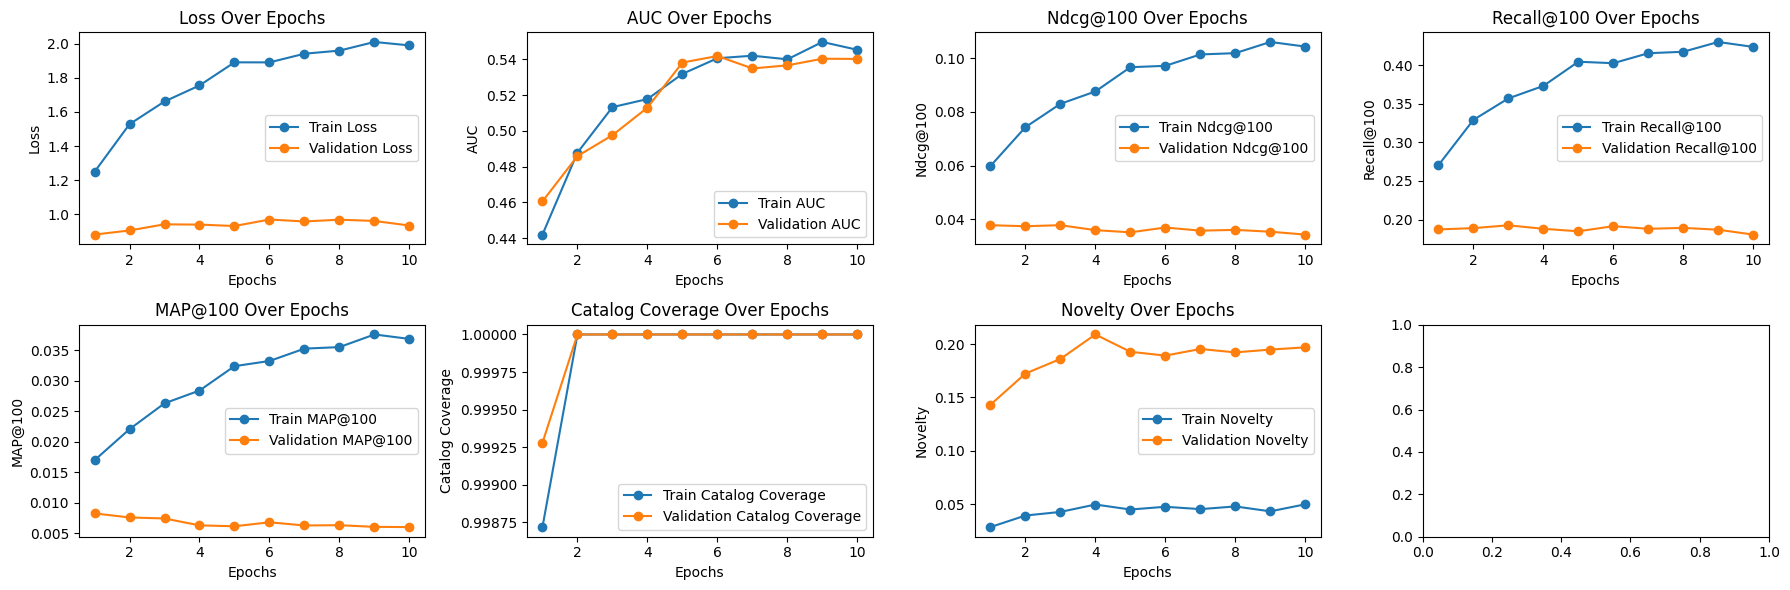

In [39]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
plot_metrics(_history, _history_val, _metrics)


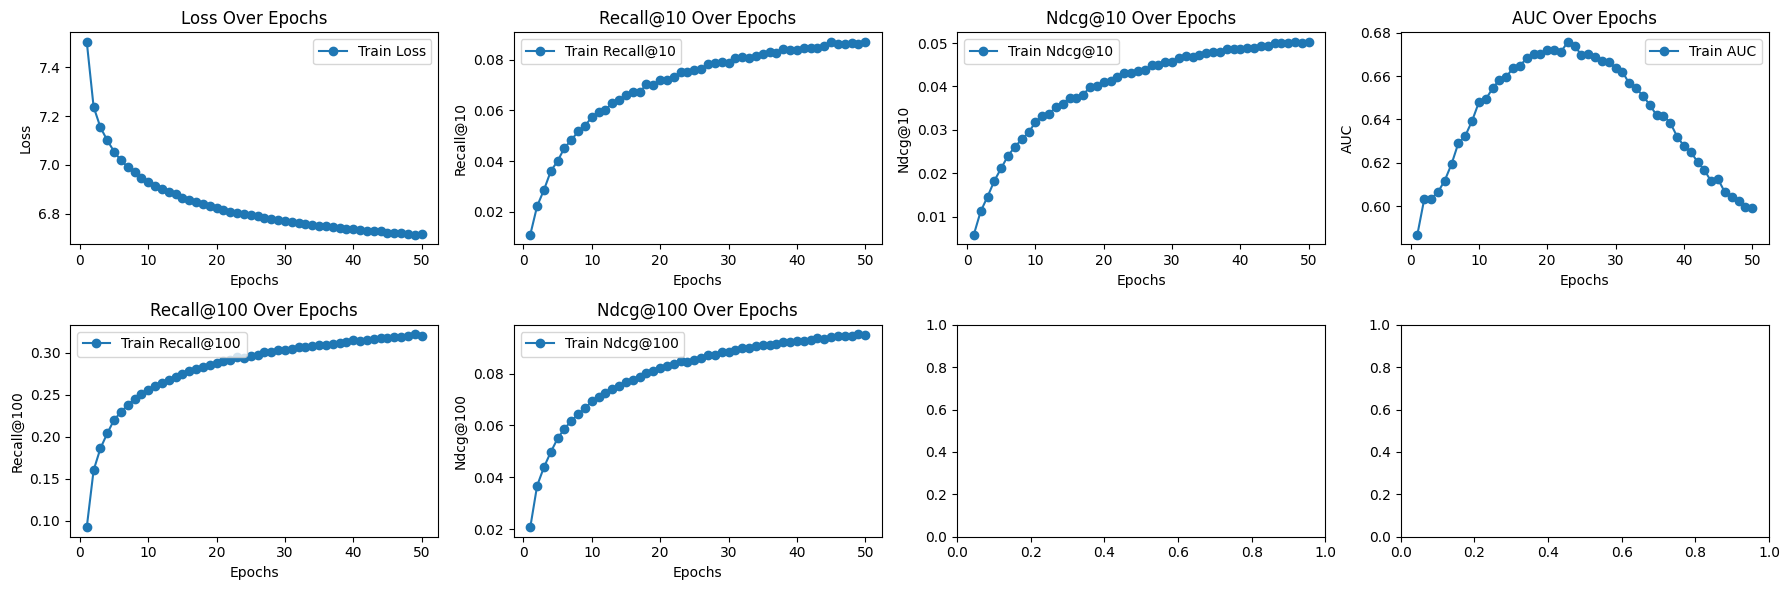

In [40]:
_history = merge_model_history(*history)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': AUC_TERM, **METRIC_AT})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [34]:
# (model.evaluate(train, batch_size=2048, return_dict=True),
#  model.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model, train, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.8865 - auc_21: 0.4858 - recall_at_100: 0.3987 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0950 - map_at_100: 0.0316 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9057
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 1.8864508867263794,
 'auc_21': 0.4857785701751709,
 'recall_at_100': 0.3994045853614807,
 'mrr_at_100': 0.03349835425615311,
 'ndcg_at_100': 0.09687190502882004,
 'map_at_100': 0.03349835425615311,
 'precision_at_100': 0.003994045313447714,
 'regularization_loss': 0.0,
 'loss_batch': 2.818242073059082,
 'coverage': 1.0,
 'novelty': 0.04531693017444375}

In [ ]:
evaluate_model(model, valid, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.9953 - auc_22: 0.4727 - recall_at_100: 0.1899 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0358 - map_at_100: 0.0059 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0450
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 0.9952747225761414,
 'auc_22': 0.4727213978767395,
 'recall_at_100': 0.19292497634887695,
 'mrr_at_100': 0.006211184896528721,
 'ndcg_at_100': 0.0365414135158062,
 'map_at_100': 0.006211184896528721,
 'precision_at_100': 0.0019292497308924794,
 'regularization_loss': 0.0,
 'loss_batch': 1.5650469064712524,
 'coverage': 1.0,
 'novelty': 0.18732618196265396}

### model_v9

In [41]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = [128, 64] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = 1024 # @param
# _popularity_sampler = True
_validation_freq = 5 # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [44]:
from merlin.models.tf.outputs.sampling.popularity import PopularityBasedSamplerV2
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2


sampler = [InBatchSamplerV2(_sample_neg)]

###
model_v9 = model = build_towers(train.schema, tower_dim=_tower_dim,
                        neg_sampler=sampler, embedding_dims=embedding_dims)
train_evaluation_clbk_v9 = EvaluationCallback(period=5, topk=100, data=train, type_='Train')
valid_evaluation_clbk_v9 = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation')
history_v9 = []
###

TOP_K = [100, 50, 10]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)



In [58]:
VERSION = 'v9'

#### model

In [57]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

In [47]:
# %pdb on
# _epochs = 10
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 32s 243ms/step - loss: 7.5021 - auc_64: 0.5725 - recall_at_100: 0.0697 - mrr_at_100: 0.0049 - ndcg_at_100: 0.0157 - map_at_100: 0.0049 - precision_at_100: 6.9667e-04 - recall_at_50: 0.0361 - mrr_at_50: 0.0044 - ndcg_at_50: 0.0103 - map_at_50: 0.0044 - precision_at_50: 7.2193e-04 - recall_at_25: 0.0189 - mrr_at_25: 0.0039 - ndcg_at_25: 0.0070 - map_at_25: 0.0039 - precision_at_25: 7.5460e-04 - recall_at_10: 0.0086 - mrr_at_10: 0.0033 - ndcg_at_10: 0.0045 - map_at_10: 0.0033 - precision_at_10: 8.5642e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4341
Epoch 2/50
35/35 [==============================] - 8s 228ms/step - loss: 7.2264 - auc_64: 0.6265 - recall_at_100: 0.1568 - mrr_at_100: 0.0116 - ndcg_at_100: 0.0361 - map_at_100: 0.0116 - precision_at_100: 0.0016 - recall_at_50: 0.0883 - mrr_at_50: 0.0106 - ndcg_at_50: 0.0251 - map_at_50: 0.0106 - precision_at_50: 0.0018 - recall_at_25: 0.0487 - mrr_at_25: 0.0095 - ndcg_at_25: 0.017

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 27ms/step - loss: 1.3187 - auc_65: 0.4355 - recall_at_100: 0.2843 - mrr_at_100: 0.0184 - ndcg_at_100: 0.0635 - map_at_100: 0.0184 - precision_at_100: 0.0028 - regularization_loss: 0.0000e+00 - loss_batch: 1.3267
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.3186674118041992, 'auc_65': 0.4355281591415405, 'recall_at_100': 0.28583231568336487, 'mrr_at_100': 0.018384287133812904, 'ndcg_at_100': 0.06377897411584854, 'map_at_100': 0.018384287133812904, 'precision_at_100': 0.0028583225794136524, 'regularization_loss': 0.0, 'loss_batch': 1.709019422531128, 'coverage': 0.9987187700192185, 'novelty': 0.02580239144115796}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 20ms/step - loss: 0.9061 - auc_66: 0.4415 - recall_at_100: 0.1887 - mrr_at_100: 0.0081 - ndcg_at_100: 0.0379 - map_at_100: 0.0081 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 0.9717
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9060923457145691, 'auc_66': 0.4415132403373718, 'recall_at_100': 0.19238999485969543, 'mrr_at_100': 0.008532561361789703, 'ndcg_at_100': 0.038908496499061584, 'map_at_100': 0.008532561361789703, 'precision_at_100': 0.0019238999811932445, 'regularization_loss': 0.0, 'loss_batch': 1.657576560974121, 'coverage': 0.9992790194664743, 'novelty': 0.1521704050346942}
35/35 [==============================] - 28s 800ms/step - loss: 7.0347 - auc_64: 0.6454 - recall_at_100: 0.2305 - mrr_at_100: 0.0230 - ndcg_at_100: 0.0589 - map_at_100: 0.0230 - precision_at_100: 0.0023 - recall_at_50: 0.1413 - mrr_at_50: 0.0218 - ndcg_at_50: 0.0444 - map_at_50: 0.0218 - precision_at_50: 0.0028

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 65ms/step - loss: 7.0027 - auc_64: 0.6508 - recall_at_100: 0.2409 - mrr_at_100: 0.0248 - ndcg_at_100: 0.0623 - map_at_100: 0.0248 - precision_at_100: 0.0024 - recall_at_50: 0.1507 - mrr_at_50: 0.0235 - ndcg_at_50: 0.0477 - map_at_50: 0.0235 - precision_at_50: 0.0030 - recall_at_25: 0.0915 - mrr_at_25: 0.0219 - ndcg_at_25: 0.0364 - map_at_25: 0.0219 - precision_at_25: 0.0037 - recall_at_10: 0.0494 - mrr_at_10: 0.0194 - ndcg_at_10: 0.0263 - map_at_10: 0.0194 - precision_at_10: 0.0049 - regularization_loss: 0.0000e+00 - loss_batch: 6.9316
Epoch 7/50
35/35 [==============================] - 3s 65ms/step - loss: 6.9759 - auc_64: 0.6539 - recall_at_100: 0.2506 - mrr_at_100: 0.0283 - ndcg_at_100: 0.0670 - map_at_100: 0.0283 - precision_at_100: 0.0025 - recall_at_50: 0.1584 - mrr_at_50: 0.0270 - ndcg_at_50: 0.0521 - map_at_50: 0.0270 - precision_at_50: 0.0032 - recall_at_25: 0.0995 - mrr_at_25: 0.0254 - ndcg_at_25: 0.0408 - map_at_25: 0.0254 - precis

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 29ms/step - loss: 1.5601 - auc_67: 0.4815 - recall_at_100: 0.3341 - mrr_at_100: 0.0226 - ndcg_at_100: 0.0757 - map_at_100: 0.0226 - precision_at_100: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 1.5689
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.560090184211731, 'auc_67': 0.4815482199192047, 'recall_at_100': 0.33463433384895325, 'mrr_at_100': 0.022749759256839752, 'ndcg_at_100': 0.07583745568990707, 'map_at_100': 0.022749759256839752, 'precision_at_100': 0.0033463435247540474, 'regularization_loss': 0.0, 'loss_batch': 1.9866688251495361, 'coverage': 0.9987187700192185, 'novelty': 0.03791564472679024}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 20ms/step - loss: 0.9381 - auc_68: 0.4780 - recall_at_100: 0.1935 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0378 - map_at_100: 0.0073 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0025
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9380600452423096, 'auc_68': 0.4779946208000183, 'recall_at_100': 0.19439615309238434, 'mrr_at_100': 0.007859953679144382, 'ndcg_at_100': 0.03855700045824051, 'map_at_100': 0.007859953679144382, 'precision_at_100': 0.0019439613679423928, 'regularization_loss': 0.0, 'loss_batch': 1.6761177778244019, 'coverage': 1.0, 'novelty': 0.17334558823529414}
35/35 [==============================] - 21s 610ms/step - loss: 6.9202 - auc_64: 0.6633 - recall_at_100: 0.2639 - mrr_at_100: 0.0319 - ndcg_at_100: 0.0724 - map_at_100: 0.0319 - precision_at_100: 0.0026 - recall_at_50: 0.1680 - mrr_at_50: 0.0306 - ndcg_at_50: 0.0569 - map_at_50: 0.0306 - precision_at_50: 0.0034 - recall_at_2

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 50ms/step - loss: 6.9045 - auc_64: 0.6671 - recall_at_100: 0.2704 - mrr_at_100: 0.0328 - ndcg_at_100: 0.0743 - map_at_100: 0.0328 - precision_at_100: 0.0027 - recall_at_50: 0.1747 - mrr_at_50: 0.0314 - ndcg_at_50: 0.0589 - map_at_50: 0.0314 - precision_at_50: 0.0035 - recall_at_25: 0.1125 - mrr_at_25: 0.0297 - ndcg_at_25: 0.0470 - map_at_25: 0.0297 - precision_at_25: 0.0045 - recall_at_10: 0.0618 - mrr_at_10: 0.0266 - ndcg_at_10: 0.0348 - map_at_10: 0.0266 - precision_at_10: 0.0062 - regularization_loss: 0.0000e+00 - loss_batch: 6.8280
Epoch 12/50
35/35 [==============================] - 3s 78ms/step - loss: 6.8924 - auc_64: 0.6691 - recall_at_100: 0.2751 - mrr_at_100: 0.0352 - ndcg_at_100: 0.0773 - map_at_100: 0.0352 - precision_at_100: 0.0028 - recall_at_50: 0.1802 - mrr_at_50: 0.0339 - ndcg_at_50: 0.0620 - map_at_50: 0.0339 - precision_at_50: 0.0036 - recall_at_25: 0.1173 - mrr_at_25: 0.0321 - ndcg_at_25: 0.0500 - map_at_25: 0.0321 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 18ms/step - loss: 1.6964 - auc_69: 0.4955 - recall_at_100: 0.3599 - mrr_at_100: 0.0270 - ndcg_at_100: 0.0842 - map_at_100: 0.0270 - precision_at_100: 0.0036 - regularization_loss: 0.0000e+00 - loss_batch: 1.7083
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6964106559753418, 'auc_69': 0.49549949169158936, 'recall_at_100': 0.363137811422348, 'mrr_at_100': 0.027312355116009712, 'ndcg_at_100': 0.08491667360067368, 'map_at_100': 0.027312355116009712, 'precision_at_100': 0.0036313780583441257, 'regularization_loss': 0.0, 'loss_batch': 2.2728374004364014, 'coverage': 0.9993593850096092, 'novelty': 0.04351236618678479}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 20ms/step - loss: 0.9778 - auc_70: 0.4769 - recall_at_100: 0.1922 - mrr_at_100: 0.0067 - ndcg_at_100: 0.0370 - map_at_100: 0.0067 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0440
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9777745604515076, 'auc_70': 0.4768557548522949, 'recall_at_100': 0.1988096833229065, 'mrr_at_100': 0.0069943759590387344, 'ndcg_at_100': 0.038441240787506104, 'map_at_100': 0.0069943759590387344, 'precision_at_100': 0.001988096861168742, 'regularization_loss': 0.0, 'loss_batch': 1.736445665359497, 'coverage': 1.0, 'novelty': 0.18807339449541283}
35/35 [==============================] - 22s 639ms/step - loss: 6.8512 - auc_64: 0.6883 - recall_at_100: 0.2860 - mrr_at_100: 0.0380 - ndcg_at_100: 0.0815 - map_at_100: 0.0380 - precision_at_100: 0.0029 - recall_at_50: 0.1868 - mrr_at_50: 0.0366 - ndcg_at_50: 0.0655 - map_at_50: 0.0366 - precision_at_50: 0.0037 - recall_at_2

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 51ms/step - loss: 6.8432 - auc_64: 0.6909 - recall_at_100: 0.2887 - mrr_at_100: 0.0379 - ndcg_at_100: 0.0820 - map_at_100: 0.0379 - precision_at_100: 0.0029 - recall_at_50: 0.1899 - mrr_at_50: 0.0365 - ndcg_at_50: 0.0661 - map_at_50: 0.0365 - precision_at_50: 0.0038 - recall_at_25: 0.1253 - mrr_at_25: 0.0347 - ndcg_at_25: 0.0537 - map_at_25: 0.0347 - precision_at_25: 0.0050 - recall_at_10: 0.0723 - mrr_at_10: 0.0315 - ndcg_at_10: 0.0409 - map_at_10: 0.0315 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 6.7613
Epoch 17/50
35/35 [==============================] - 3s 64ms/step - loss: 6.8350 - auc_64: 0.6942 - recall_at_100: 0.2928 - mrr_at_100: 0.0393 - ndcg_at_100: 0.0839 - map_at_100: 0.0393 - precision_at_100: 0.0029 - recall_at_50: 0.1947 - mrr_at_50: 0.0379 - ndcg_at_50: 0.0681 - map_at_50: 0.0379 - precision_at_50: 0.0039 - recall_at_25: 0.1277 - mrr_at_25: 0.0360 - ndcg_at_25: 0.0553 - map_at_25: 0.0360 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 30ms/step - loss: 1.8385 - auc_71: 0.5127 - recall_at_100: 0.3904 - mrr_at_100: 0.0305 - ndcg_at_100: 0.0925 - map_at_100: 0.0305 - precision_at_100: 0.0039 - regularization_loss: 0.0000e+00 - loss_batch: 1.8514
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8384615182876587, 'auc_71': 0.5127439498901367, 'recall_at_100': 0.3930799663066864, 'mrr_at_100': 0.031359102576971054, 'ndcg_at_100': 0.093777596950531, 'map_at_100': 0.031359102576971054, 'precision_at_100': 0.003930799663066864, 'regularization_loss': 0.0, 'loss_batch': 2.467383861541748, 'coverage': 1.0, 'novelty': 0.043358315324842515}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 21ms/step - loss: 0.9264 - auc_72: 0.5091 - recall_at_100: 0.1792 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0342 - map_at_100: 0.0059 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9919
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9264311790466309, 'auc_72': 0.5091447234153748, 'recall_at_100': 0.18536846339702606, 'mrr_at_100': 0.006512761116027832, 'ndcg_at_100': 0.03576059639453888, 'map_at_100': 0.006512761116027832, 'precision_at_100': 0.0018536844290792942, 'regularization_loss': 0.0, 'loss_batch': 1.6762456893920898, 'coverage': 1.0, 'novelty': 0.18996776792908945}
35/35 [==============================] - 20s 574ms/step - loss: 6.8046 - auc_64: 0.7070 - recall_at_100: 0.2993 - mrr_at_100: 0.0411 - ndcg_at_100: 0.0865 - map_at_100: 0.0411 - precision_at_100: 0.0030 - recall_at_50: 0.1982 - mrr_at_50: 0.0396 - ndcg_at_50: 0.0702 - map_at_50: 0.0396 - precision_at_50: 0.0040 - recall_at_2

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 48ms/step - loss: 6.7990 - auc_64: 0.7085 - recall_at_100: 0.3020 - mrr_at_100: 0.0424 - ndcg_at_100: 0.0881 - map_at_100: 0.0424 - precision_at_100: 0.0030 - recall_at_50: 0.2010 - mrr_at_50: 0.0410 - ndcg_at_50: 0.0719 - map_at_50: 0.0410 - precision_at_50: 0.0040 - recall_at_25: 0.1335 - mrr_at_25: 0.0391 - ndcg_at_25: 0.0589 - map_at_25: 0.0391 - precision_at_25: 0.0053 - recall_at_10: 0.0778 - mrr_at_10: 0.0357 - ndcg_at_10: 0.0455 - map_at_10: 0.0357 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 6.7135
Epoch 22/50
35/35 [==============================] - 2s 43ms/step - loss: 6.7928 - auc_64: 0.7066 - recall_at_100: 0.3070 - mrr_at_100: 0.0429 - ndcg_at_100: 0.0895 - map_at_100: 0.0429 - precision_at_100: 0.0031 - recall_at_50: 0.2038 - mrr_at_50: 0.0415 - ndcg_at_50: 0.0729 - map_at_50: 0.0415 - precision_at_50: 0.0041 - recall_at_25: 0.1359 - mrr_at_25: 0.0396 - ndcg_at_25: 0.0599 - map_at_25: 0.0396 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 17ms/step - loss: 1.8773 - auc_73: 0.5098 - recall_at_100: 0.3936 - mrr_at_100: 0.0314 - ndcg_at_100: 0.0939 - map_at_100: 0.0314 - precision_at_100: 0.0039 - regularization_loss: 0.0000e+00 - loss_batch: 1.8885
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8772730827331543, 'auc_73': 0.5097960233688354, 'recall_at_100': 0.39639896154403687, 'mrr_at_100': 0.0322856567800045, 'ndcg_at_100': 0.09525469690561295, 'map_at_100': 0.0322856567800045, 'precision_at_100': 0.0039639901369810104, 'regularization_loss': 0.0, 'loss_batch': 2.423976421356201, 'coverage': 1.0, 'novelty': 0.050649908690514556}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 21ms/step - loss: 0.9434 - auc_74: 0.5106 - recall_at_100: 0.1797 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0346 - map_at_100: 0.0063 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 1.0045
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9434194564819336, 'auc_74': 0.510635495185852, 'recall_at_100': 0.18523472547531128, 'mrr_at_100': 0.006348718423396349, 'ndcg_at_100': 0.03563220798969269, 'map_at_100': 0.006348718423396349, 'precision_at_100': 0.00185234728269279, 'regularization_loss': 0.0, 'loss_batch': 1.6434687376022339, 'coverage': 1.0, 'novelty': 0.1989031849820713}
35/35 [==============================] - 19s 544ms/step - loss: 6.7701 - auc_64: 0.7041 - recall_at_100: 0.3102 - mrr_at_100: 0.0440 - ndcg_at_100: 0.0911 - map_at_100: 0.0440 - precision_at_100: 0.0031 - recall_at_50: 0.2100 - mrr_at_50: 0.0426 - ndcg_at_50: 0.0749 - map_at_50: 0.0426 - precision_at_50: 0.0042 - recall_at_25: 0

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 45ms/step - loss: 6.7634 - auc_64: 0.6999 - recall_at_100: 0.3123 - mrr_at_100: 0.0445 - ndcg_at_100: 0.0919 - map_at_100: 0.0445 - precision_at_100: 0.0031 - recall_at_50: 0.2113 - mrr_at_50: 0.0430 - ndcg_at_50: 0.0756 - map_at_50: 0.0430 - precision_at_50: 0.0042 - recall_at_25: 0.1414 - mrr_at_25: 0.0411 - ndcg_at_25: 0.0622 - map_at_25: 0.0411 - precision_at_25: 0.0057 - recall_at_10: 0.0833 - mrr_at_10: 0.0376 - ndcg_at_10: 0.0482 - map_at_10: 0.0376 - precision_at_10: 0.0083 - regularization_loss: 0.0000e+00 - loss_batch: 6.6758
Epoch 27/50
35/35 [==============================] - 2s 41ms/step - loss: 6.7588 - auc_64: 0.6933 - recall_at_100: 0.3178 - mrr_at_100: 0.0458 - ndcg_at_100: 0.0939 - map_at_100: 0.0458 - precision_at_100: 0.0032 - recall_at_50: 0.2147 - mrr_at_50: 0.0444 - ndcg_at_50: 0.0773 - map_at_50: 0.0444 - precision_at_50: 0.0043 - recall_at_25: 0.1435 - mrr_at_25: 0.0424 - ndcg_at_25: 0.0636 - map_at_25: 0.0424 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 18ms/step - loss: 1.9866 - auc_75: 0.5053 - recall_at_100: 0.4234 - mrr_at_100: 0.0361 - ndcg_at_100: 0.1034 - map_at_100: 0.0361 - precision_at_100: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 1.9994
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9865533113479614, 'auc_75': 0.5052861571311951, 'recall_at_100': 0.4226517677307129, 'mrr_at_100': 0.0360867902636528, 'ndcg_at_100': 0.10327156633138657, 'map_at_100': 0.0360867902636528, 'precision_at_100': 0.004226517863571644, 'regularization_loss': 0.0, 'loss_batch': 2.611659526824951, 'coverage': 1.0, 'novelty': 0.04713585924222733}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 32ms/step - loss: 0.9759 - auc_76: 0.5067 - recall_at_100: 0.1866 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0351 - map_at_100: 0.0058 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0294
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9758761525154114, 'auc_76': 0.5067131519317627, 'recall_at_100': 0.19071820378303528, 'mrr_at_100': 0.006214824039489031, 'ndcg_at_100': 0.036211393773555756, 'map_at_100': 0.006214824039489031, 'precision_at_100': 0.0019071819260716438, 'regularization_loss': 0.0, 'loss_batch': 1.58883798122406, 'coverage': 1.0, 'novelty': 0.1887510008006405}
35/35 [==============================] - 19s 535ms/step - loss: 6.7423 - auc_64: 0.6751 - recall_at_100: 0.3215 - mrr_at_100: 0.0467 - ndcg_at_100: 0.0955 - map_at_100: 0.0467 - precision_at_100: 0.0032 - recall_at_50: 0.2172 - mrr_at_50: 0.0453 - ndcg_at_50: 0.0786 - map_at_50: 0.0453 - precision_at_50: 0.0043 - recall_at_25:

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 71ms/step - loss: 6.7429 - auc_64: 0.6681 - recall_at_100: 0.3191 - mrr_at_100: 0.0470 - ndcg_at_100: 0.0953 - map_at_100: 0.0470 - precision_at_100: 0.0032 - recall_at_50: 0.2176 - mrr_at_50: 0.0455 - ndcg_at_50: 0.0789 - map_at_50: 0.0455 - precision_at_50: 0.0044 - recall_at_25: 0.1473 - mrr_at_25: 0.0436 - ndcg_at_25: 0.0654 - map_at_25: 0.0436 - precision_at_25: 0.0059 - recall_at_10: 0.0881 - mrr_at_10: 0.0400 - ndcg_at_10: 0.0512 - map_at_10: 0.0400 - precision_at_10: 0.0088 - regularization_loss: 0.0000e+00 - loss_batch: 6.6540
Epoch 32/50
35/35 [==============================] - 3s 46ms/step - loss: 6.7333 - auc_64: 0.6612 - recall_at_100: 0.3254 - mrr_at_100: 0.0466 - ndcg_at_100: 0.0959 - map_at_100: 0.0466 - precision_at_100: 0.0033 - recall_at_50: 0.2184 - mrr_at_50: 0.0451 - ndcg_at_50: 0.0786 - map_at_50: 0.0451 - precision_at_50: 0.0044 - recall_at_25: 0.1467 - mrr_at_25: 0.0431 - ndcg_at_25: 0.0649 - map_at_25: 0.0431 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 19ms/step - loss: 2.0177 - auc_77: 0.5031 - recall_at_100: 0.4299 - mrr_at_100: 0.0363 - ndcg_at_100: 0.1048 - map_at_100: 0.0363 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0296


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0176918506622314, 'auc_77': 0.5030549168586731, 'recall_at_100': 0.4309563934803009, 'mrr_at_100': 0.0374317392706871, 'ndcg_at_100': 0.1061413437128067, 'map_at_100': 0.0374317392706871, 'precision_at_100': 0.004309563897550106, 'regularization_loss': 0.0, 'loss_batch': 2.595036745071411, 'coverage': 1.0, 'novelty': 0.04590818363273453}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 30ms/step - loss: 0.9339 - auc_78: 0.5045 - recall_at_100: 0.1796 - mrr_at_100: 0.0053 - ndcg_at_100: 0.0336 - map_at_100: 0.0053 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9805
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.933928906917572, 'auc_78': 0.5045362710952759, 'recall_at_100': 0.1816236525774002, 'mrr_at_100': 0.005662372801452875, 'ndcg_at_100': 0.03432983160018921, 'map_at_100': 0.005662372801452875, 'precision_at_100': 0.001816236530430615, 'regularization_loss': 0.0, 'loss_batch': 1.4678364992141724, 'coverage': 1.0, 'novelty': 0.20046768707482995}
35/35 [==============================] - 22s 617ms/step - loss: 6.7201 - auc_64: 0.6324 - recall_at_100: 0.3260 - mrr_at_100: 0.0478 - ndcg_at_100: 0.0973 - map_at_100: 0.0478 - precision_at_100: 0.0033 - recall_at_50: 0.2224 - mrr_at_50: 0.0463 - ndcg_at_50: 0.0806 - map_at_50: 0.0463 - precision_at_50: 0.0044 - recall_at_25: 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 73ms/step - loss: 6.7178 - auc_64: 0.6257 - recall_at_100: 0.3291 - mrr_at_100: 0.0479 - ndcg_at_100: 0.0977 - map_at_100: 0.0479 - precision_at_100: 0.0033 - recall_at_50: 0.2232 - mrr_at_50: 0.0464 - ndcg_at_50: 0.0806 - map_at_50: 0.0464 - precision_at_50: 0.0045 - recall_at_25: 0.1503 - mrr_at_25: 0.0444 - ndcg_at_25: 0.0667 - map_at_25: 0.0444 - precision_at_25: 0.0060 - recall_at_10: 0.0896 - mrr_at_10: 0.0407 - ndcg_at_10: 0.0520 - map_at_10: 0.0407 - precision_at_10: 0.0090 - regularization_loss: 0.0000e+00 - loss_batch: 6.6265
Epoch 37/50
35/35 [==============================] - 2s 52ms/step - loss: 6.7110 - auc_64: 0.6212 - recall_at_100: 0.3284 - mrr_at_100: 0.0482 - ndcg_at_100: 0.0980 - map_at_100: 0.0482 - precision_at_100: 0.0033 - recall_at_50: 0.2247 - mrr_at_50: 0.0467 - ndcg_at_50: 0.0812 - map_at_50: 0.0467 - precision_at_50: 0.0045 - recall_at_25: 0.1512 - mrr_at_25: 0.0447 - ndcg_at_25: 0.0671 - map_at_25: 0.0447 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 19ms/step - loss: 2.0413 - auc_79: 0.5008 - recall_at_100: 0.4349 - mrr_at_100: 0.0382 - ndcg_at_100: 0.1077 - map_at_100: 0.0382 - precision_at_100: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 2.0532


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0412955284118652, 'auc_79': 0.5008196234703064, 'recall_at_100': 0.43645480275154114, 'mrr_at_100': 0.03880186378955841, 'ndcg_at_100': 0.10838404297828674, 'map_at_100': 0.03880186378955841, 'precision_at_100': 0.004364547319710255, 'regularization_loss': 0.0, 'loss_batch': 2.6173806190490723, 'coverage': 1.0, 'novelty': 0.04294562346297477}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 32ms/step - loss: 0.9548 - auc_80: 0.5018 - recall_at_100: 0.1824 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0343 - map_at_100: 0.0056 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9970
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9548067450523376, 'auc_80': 0.5017728209495544, 'recall_at_100': 0.18556907773017883, 'mrr_at_100': 0.005874995607882738, 'ndcg_at_100': 0.03512190282344818, 'map_at_100': 0.005874995607882738, 'precision_at_100': 0.0018556907307356596, 'regularization_loss': 0.0, 'loss_batch': 1.4382120370864868, 'coverage': 1.0, 'novelty': 0.18054757802029486}
35/35 [==============================] - 23s 670ms/step - loss: 6.7031 - auc_64: 0.5987 - recall_at_100: 0.3309 - mrr_at_100: 0.0493 - ndcg_at_100: 0.0994 - map_at_100: 0.0493 - precision_at_100: 0.0033 - recall_at_50: 0.2275 - mrr_at_50: 0.0478 - ndcg_at_50: 0.0827 - map_at_50: 0.0478 - precision_at_50: 0.0046 - recall_at_2

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 54ms/step - loss: 6.7005 - auc_64: 0.5921 - recall_at_100: 0.3350 - mrr_at_100: 0.0493 - ndcg_at_100: 0.1001 - map_at_100: 0.0493 - precision_at_100: 0.0033 - recall_at_50: 0.2292 - mrr_at_50: 0.0478 - ndcg_at_50: 0.0830 - map_at_50: 0.0478 - precision_at_50: 0.0046 - recall_at_25: 0.1555 - mrr_at_25: 0.0457 - ndcg_at_25: 0.0688 - map_at_25: 0.0457 - precision_at_25: 0.0062 - recall_at_10: 0.0918 - mrr_at_10: 0.0419 - ndcg_at_10: 0.0535 - map_at_10: 0.0419 - precision_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 6.6077
Epoch 42/50
35/35 [==============================] - 2s 48ms/step - loss: 6.6934 - auc_64: 0.5847 - recall_at_100: 0.3352 - mrr_at_100: 0.0494 - ndcg_at_100: 0.1002 - map_at_100: 0.0494 - precision_at_100: 0.0034 - recall_at_50: 0.2291 - mrr_at_50: 0.0479 - ndcg_at_50: 0.0831 - map_at_50: 0.0479 - precision_at_50: 0.0046 - recall_at_25: 0.1556 - mrr_at_25: 0.0459 - ndcg_at_25: 0.0690 - map_at_25: 0.0459 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 19ms/step - loss: 2.1715 - auc_81: 0.5018 - recall_at_100: 0.4638 - mrr_at_100: 0.0413 - ndcg_at_100: 0.1153 - map_at_100: 0.0413 - precision_at_100: 0.0046 - regularization_loss: 0.0000e+00 - loss_batch: 2.1814


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.171457529067993, 'auc_81': 0.5018022656440735, 'recall_at_100': 0.4654710590839386, 'mrr_at_100': 0.04145330563187599, 'ndcg_at_100': 0.11588284373283386, 'map_at_100': 0.04145330563187599, 'precision_at_100': 0.004654711578041315, 'regularization_loss': 0.0, 'loss_batch': 2.655184030532837, 'coverage': 1.0, 'novelty': 0.038698292843072885}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 31ms/step - loss: 0.9701 - auc_82: 0.5013 - recall_at_100: 0.1844 - mrr_at_100: 0.0052 - ndcg_at_100: 0.0341 - map_at_100: 0.0052 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 1.0200
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9700722694396973, 'auc_82': 0.50126713514328, 'recall_at_100': 0.18663902580738068, 'mrr_at_100': 0.0055593159049749374, 'ndcg_at_100': 0.03493544086813927, 'map_at_100': 0.0055593159049749374, 'precision_at_100': 0.0018663901137188077, 'regularization_loss': 0.0, 'loss_batch': 1.541600227355957, 'coverage': 1.0, 'novelty': 0.16462988826815644}
35/35 [==============================] - 21s 607ms/step - loss: 6.6877 - auc_64: 0.5694 - recall_at_100: 0.3357 - mrr_at_100: 0.0503 - ndcg_at_100: 0.1009 - map_at_100: 0.0503 - precision_at_100: 0.0034 - recall_at_50: 0.2279 - mrr_at_50: 0.0487 - ndcg_at_50: 0.0835 - map_at_50: 0.0487 - precision_at_50: 0.0046 - recall_at_25

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 81ms/step - loss: 6.6865 - auc_64: 0.5651 - recall_at_100: 0.3400 - mrr_at_100: 0.0513 - ndcg_at_100: 0.1025 - map_at_100: 0.0513 - precision_at_100: 0.0034 - recall_at_50: 0.2308 - mrr_at_50: 0.0497 - ndcg_at_50: 0.0849 - map_at_50: 0.0497 - precision_at_50: 0.0046 - recall_at_25: 0.1575 - mrr_at_25: 0.0477 - ndcg_at_25: 0.0708 - map_at_25: 0.0477 - precision_at_25: 0.0063 - recall_at_10: 0.0947 - mrr_at_10: 0.0439 - ndcg_at_10: 0.0557 - map_at_10: 0.0439 - precision_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 6.5920
Epoch 47/50
35/35 [==============================] - 2s 52ms/step - loss: 6.6814 - auc_64: 0.5607 - recall_at_100: 0.3357 - mrr_at_100: 0.0491 - ndcg_at_100: 0.1000 - map_at_100: 0.0491 - precision_at_100: 0.0034 - recall_at_50: 0.2301 - mrr_at_50: 0.0476 - ndcg_at_50: 0.0830 - map_at_50: 0.0476 - precision_at_50: 0.0046 - recall_at_25: 0.1544 - mrr_at_25: 0.0455 - ndcg_at_25: 0.0685 - map_at_25: 0.0455 - preci

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 18ms/step - loss: 2.1409 - auc_83: 0.5026 - recall_at_100: 0.4571 - mrr_at_100: 0.0410 - ndcg_at_100: 0.1139 - map_at_100: 0.0410 - precision_at_100: 0.0046 - regularization_loss: 0.0000e+00 - loss_batch: 2.1523
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.140946865081787, 'auc_83': 0.5025792717933655, 'recall_at_100': 0.45692428946495056, 'mrr_at_100': 0.04092243313789368, 'ndcg_at_100': 0.11394141614437103, 'map_at_100': 0.04092243313789368, 'precision_at_100': 0.004569243174046278, 'regularization_loss': 0.0, 'loss_batch': 2.6913745403289795, 'coverage': 1.0, 'novelty': 0.04318754293565377}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 31ms/step - loss: 0.9617 - auc_84: 0.5017 - recall_at_100: 0.1755 - mrr_at_100: 0.0049 - ndcg_at_100: 0.0324 - map_at_100: 0.0049 - precision_at_100: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 1.0057
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9617382884025574, 'auc_84': 0.5016816854476929, 'recall_at_100': 0.18409790098667145, 'mrr_at_100': 0.005295155569911003, 'ndcg_at_100': 0.034253764897584915, 'map_at_100': 0.005295155569911003, 'precision_at_100': 0.0018409790936857462, 'regularization_loss': 0.0, 'loss_batch': 1.4657294750213623, 'coverage': 1.0, 'novelty': 0.17576887232059646}
35/35 [==============================] - 24s 691ms/step - loss: 6.6767 - auc_64: 0.5502 - recall_at_100: 0.3397 - mrr_at_100: 0.0512 - ndcg_at_100: 0.1026 - map_at_100: 0.0512 - precision_at_100: 0.0034 - recall_at_50: 0.2333 - mrr_at_50: 0.0497 - ndcg_at_50: 0.0854 - map_at_50: 0.0497 - precision_at_50: 0.0047 - recall_at_

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


#### analysis

In [56]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

Plot for model v9


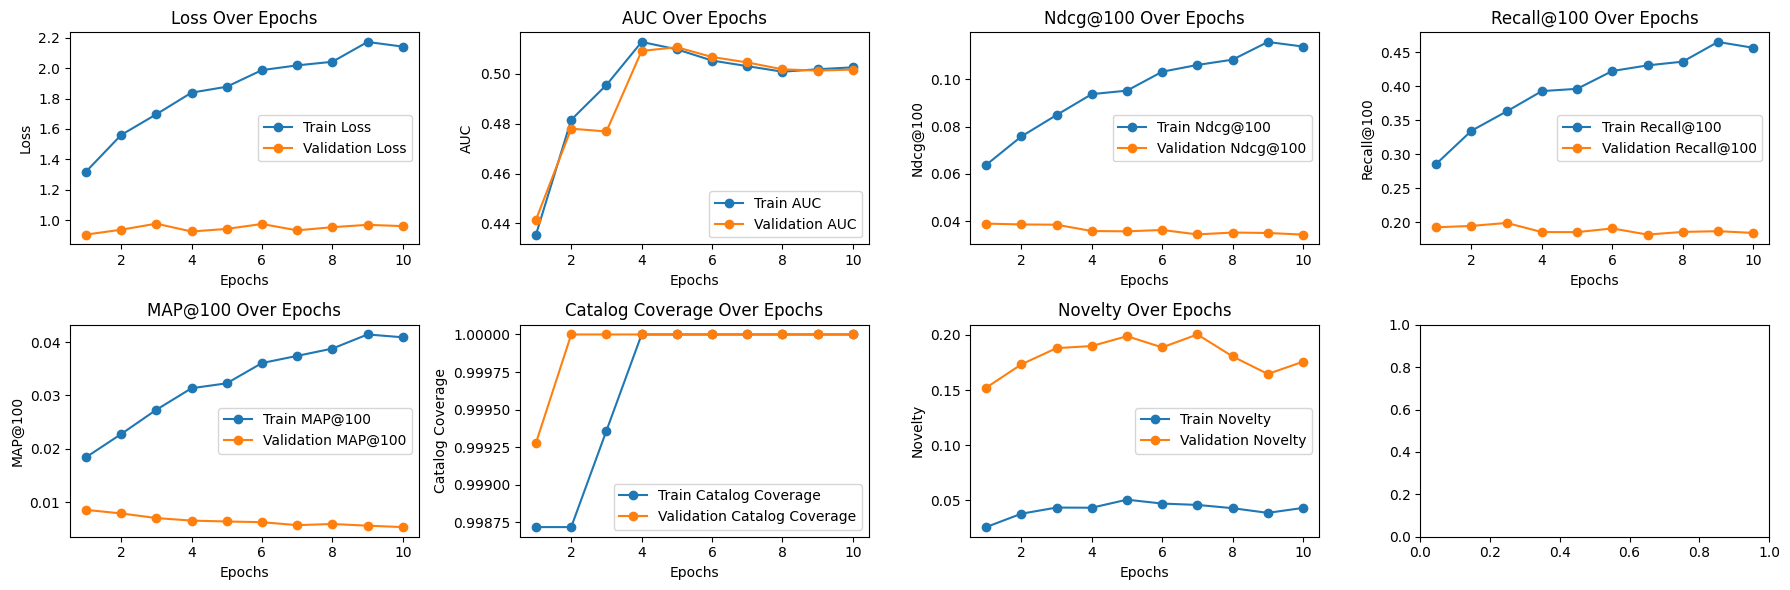

In [63]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


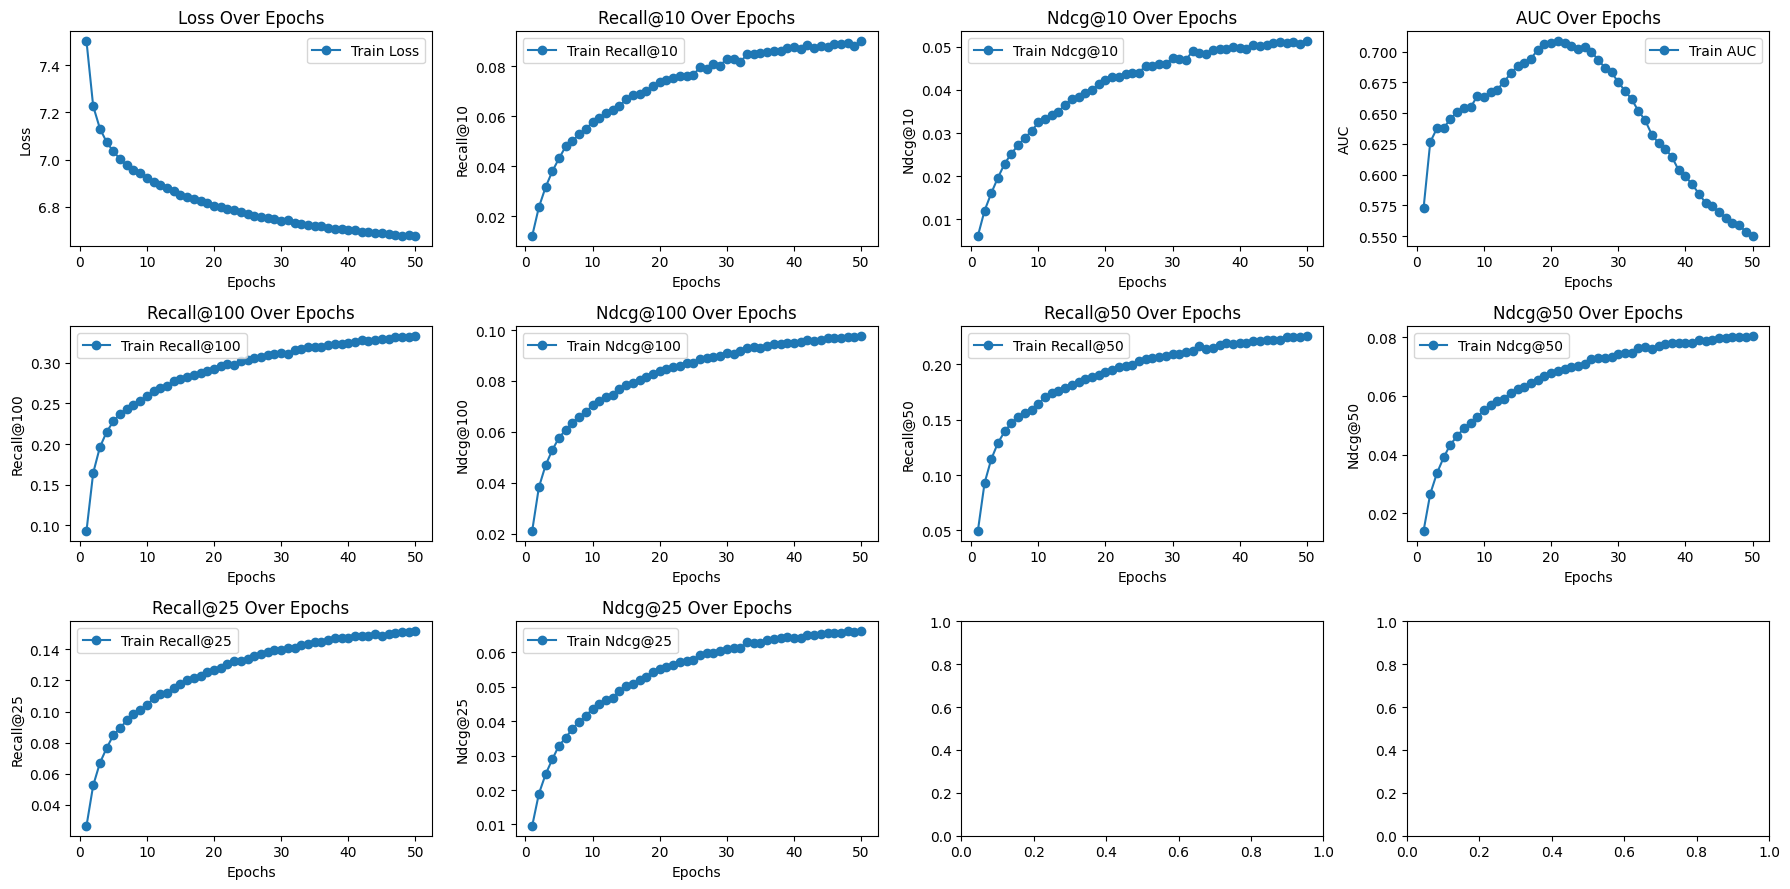

In [65]:
_history = merge_model_history(*history)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': AUC_TERM, **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [ ]:
# (model.evaluate(train, batch_size=2048, return_dict=True),
#  model.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model, train, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.8865 - auc_21: 0.4858 - recall_at_100: 0.3987 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0950 - map_at_100: 0.0316 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9057
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 1.8864508867263794,
 'auc_21': 0.4857785701751709,
 'recall_at_100': 0.3994045853614807,
 'mrr_at_100': 0.03349835425615311,
 'ndcg_at_100': 0.09687190502882004,
 'map_at_100': 0.03349835425615311,
 'precision_at_100': 0.003994045313447714,
 'regularization_loss': 0.0,
 'loss_batch': 2.818242073059082,
 'coverage': 1.0,
 'novelty': 0.04531693017444375}

In [ ]:
evaluate_model(model, valid, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.9953 - auc_22: 0.4727 - recall_at_100: 0.1899 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0358 - map_at_100: 0.0059 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0450
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 0.9952747225761414,
 'auc_22': 0.4727213978767395,
 'recall_at_100': 0.19292497634887695,
 'mrr_at_100': 0.006211184896528721,
 'ndcg_at_100': 0.0365414135158062,
 'map_at_100': 0.006211184896528721,
 'precision_at_100': 0.0019292497308924794,
 'regularization_loss': 0.0,
 'loss_batch': 1.5650469064712524,
 'coverage': 1.0,
 'novelty': 0.18732618196265396}

### model_v9

In [159]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = [128, 64] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = 256 # @param
# _popularity_sampler = True
_validation_freq = 5 # @param
# _loss = 'categorical_crossentropy' # @param
_loss = 'bpr-max' # @param

_logq_sampling_correction = True # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [160]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

###
model_v9 = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction
)

train_evaluation_clbk_v9 = EvaluationCallback(period=5, topk=100, data=train, type_='Train')
valid_evaluation_clbk_v9 = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation')
history_v9 = []
###

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=[
        tf.keras.metrics.AUC(),
        topKMetricsAggregator(TOP_K)
        ],
    loss=_loss,
)



[INFO] hacked the logq correction to match item cardinality


<Axes: >

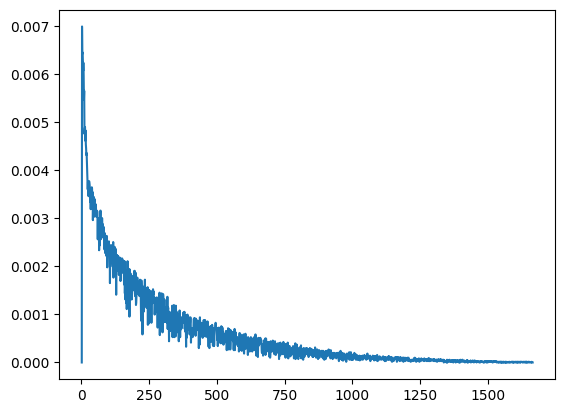

In [161]:
sampling_prob = model._output.post.candidate_probs.numpy()
import seaborn as sns
sns.lineplot(x=range(1,sampling_prob.shape[0]+1), y=sampling_prob)


In [162]:
VERSION = 'v9'

#### model

In [163]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

In [164]:
# %pdb on
# _epochs = 10
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 26s 269ms/step - loss: 8.6799 - auc_48: 0.5013 - auc: 0.5011 - recall_at_100: 0.0514 - mrr_at_100: 0.0025 - ndcg_at_100: 0.0107 - map_at_100: 0.0025 - precision_at_100: 5.1410e-04 - recall_at_50: 0.0259 - mrr_at_50: 0.0022 - ndcg_at_50: 0.0066 - map_at_50: 0.0022 - precision_at_50: 5.1743e-04 - recall_at_10: 0.0049 - mrr_at_10: 0.0014 - ndcg_at_10: 0.0022 - map_at_10: 0.0014 - precision_at_10: 4.8860e-04 - regularization_loss: 0.0000e+00 - loss_batch: 8.6104
Epoch 2/50
35/35 [==============================] - 7s 184ms/step - loss: 8.4275 - auc_48: 0.5063 - auc: 0.5086 - recall_at_100: 0.0644 - mrr_at_100: 0.0035 - ndcg_at_100: 0.0136 - map_at_100: 0.0035 - precision_at_100: 6.4406e-04 - recall_at_50: 0.0325 - mrr_at_50: 0.0030 - ndcg_at_50: 0.0085 - map_at_50: 0.0030 - precision_at_50: 6.5029e-04 - recall_at_10: 0.0067 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0031 - map_at_10: 0.0020 - precision_at_10: 6.6952e-04 - regularization_loss: 0.0

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 20ms/step - loss: 1.9142 - auc: 0.5511 - recall_at_100: 0.4214 - mrr_at_100: 0.0358 - ndcg_at_100: 0.1031 - map_at_100: 0.0358 - precision_at_100: 0.0042 - recall_at_10: 0.0776 - mrr_at_10: 0.0256 - ndcg_at_10: 0.0375 - map_at_10: 0.0256 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 1.9140


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.914225459098816, 'auc': 0.5511389374732971, 'recall_at_100': 0.42277997732162476, 'mrr_at_100': 0.03559507057070732, 'ndcg_at_100': 0.10313132405281067, 'map_at_100': 0.03559507057070732, 'precision_at_100': 0.00422779843211174, 'recall_at_10': 0.07727699726819992, 'mrr_at_10': 0.025301363319158554, 'ndcg_at_10': 0.037258148193359375, 'map_at_10': 0.025301363319158554, 'precision_at_10': 0.007727699354290962, 'regularization_loss': 0.0, 'loss_batch': 1.9010341167449951, 'coverage': 0.15566944266495836, 'novelty': 0.0021536957693467198}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 29ms/step - loss: 1.0443 - auc: 0.5132 - recall_at_100: 0.2273 - mrr_at_100: 0.0115 - ndcg_at_100: 0.0478 - map_at_100: 0.0115 - precision_at_100: 0.0023 - recall_at_10: 0.0204 - mrr_at_10: 0.0059 - ndcg_at_10: 0.0092 - map_at_10: 0.0059 - precision_at_10: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 0.9885
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0443395376205444, 'auc': 0.5131709575653076, 'recall_at_100': 0.22582586109638214, 'mrr_at_100': 0.011360383592545986, 'ndcg_at_100': 0.047374140471220016, 'map_at_100': 0.011360383592545986, 'precision_at_100': 0.0022582581732422113, 'recall_at_10': 0.020195266231894493, 'mrr_at_10': 0.005704027134925127, 'ndcg_at_10': 0.00900197122246027, 'map_at_10': 0.005704027134925127, 'precision_at_10': 0.0020195264369249344, 'regularization_loss': 0.0, 'loss_batch': 0.4049513638019562, 'coverage': 0.17519826964671953, 'novelty': 0.028861751293116637}
35/35 [============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 72ms/step - loss: 8.3599 - auc_48: 0.6342 - auc: 0.6560 - recall_at_100: 0.1822 - mrr_at_100: 0.0138 - ndcg_at_100: 0.0423 - map_at_100: 0.0138 - precision_at_100: 0.0018 - recall_at_50: 0.1042 - mrr_at_50: 0.0127 - ndcg_at_50: 0.0298 - map_at_50: 0.0127 - precision_at_50: 0.0021 - recall_at_10: 0.0261 - mrr_at_10: 0.0095 - ndcg_at_10: 0.0133 - map_at_10: 0.0095 - precision_at_10: 0.0026 - regularization_loss: 0.0000e+00 - loss_batch: 8.3007
Epoch 7/50
35/35 [==============================] - 3s 63ms/step - loss: 8.3536 - auc_48: 0.6361 - auc: 0.6568 - recall_at_100: 0.2006 - mrr_at_100: 0.0168 - ndcg_at_100: 0.0482 - map_at_100: 0.0168 - precision_at_100: 0.0020 - recall_at_50: 0.1180 - mrr_at_50: 0.0156 - ndcg_at_50: 0.0349 - map_at_50: 0.0156 - precision_at_50: 0.0024 - recall_at_10: 0.0330 - mrr_at_10: 0.0121 - ndcg_at_10: 0.0169 - map_at_10: 0.0121 - precision_at_10: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 8.2943
Epoch 8/5

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 25ms/step - loss: 2.0739 - auc: 0.5639 - recall_at_100: 0.4629 - mrr_at_100: 0.0389 - ndcg_at_100: 0.1130 - map_at_100: 0.0389 - precision_at_100: 0.0046 - recall_at_10: 0.0845 - mrr_at_10: 0.0275 - ndcg_at_10: 0.0406 - map_at_10: 0.0275 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 2.0759
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.073903799057007, 'auc': 0.5639137625694275, 'recall_at_100': 0.45927467942237854, 'mrr_at_100': 0.03888658061623573, 'ndcg_at_100': 0.11243776232004166, 'map_at_100': 0.03888658061623573, 'precision_at_100': 0.004592746030539274, 'recall_at_10': 0.08428534865379333, 'mrr_at_10': 0.027532152831554413, 'ndcg_at_10': 0.04059163108468056, 'map_at_10': 0.027532152831554413, 'precision_at_10': 0.008428534492850304, 'regularization_loss': 0.0, 'loss_batch': 2.1709325313568115, 'coverage': 0.2319026265214606, 'novelty': 0.002189291277891408}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 22ms/step - loss: 1.0613 - auc: 0.5221 - recall_at_100: 0.2347 - mrr_at_100: 0.0116 - ndcg_at_100: 0.0490 - map_at_100: 0.0116 - precision_at_100: 0.0023 - recall_at_10: 0.0234 - mrr_at_10: 0.0059 - ndcg_at_10: 0.0099 - map_at_10: 0.0059 - precision_at_10: 0.0023 - regularization_loss: 0.0000e+00 - loss_batch: 1.0128
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0612879991531372, 'auc': 0.5221227407455444, 'recall_at_100': 0.22896884381771088, 'mrr_at_100': 0.011114140041172504, 'ndcg_at_100': 0.047573190182447433, 'map_at_100': 0.011114140041172504, 'precision_at_100': 0.002289687981829047, 'recall_at_10': 0.021198341622948647, 'mrr_at_10': 0.0055752466432750225, 'ndcg_at_10': 0.00910484604537487, 'map_at_10': 0.0055752466432750225, 'precision_at_10': 0.002119834301993251, 'regularization_loss': 0.0, 'loss_batch': 0.5061894655227661, 'coverage': 0.2609949531362653, 'novelty': 0.0317038730500269}
35/35 [===============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 69ms/step - loss: 8.3356 - auc_48: 0.6939 - auc: 0.7192 - recall_at_100: 0.2510 - mrr_at_100: 0.0241 - ndcg_at_100: 0.0634 - map_at_100: 0.0241 - precision_at_100: 0.0025 - recall_at_50: 0.1556 - mrr_at_50: 0.0228 - ndcg_at_50: 0.0480 - map_at_50: 0.0228 - precision_at_50: 0.0031 - recall_at_10: 0.0487 - mrr_at_10: 0.0183 - ndcg_at_10: 0.0253 - map_at_10: 0.0183 - precision_at_10: 0.0049 - regularization_loss: 0.0000e+00 - loss_batch: 8.2754
Epoch 12/50
35/35 [==============================] - 3s 69ms/step - loss: 8.3327 - auc_48: 0.7065 - auc: 0.7340 - recall_at_100: 0.2548 - mrr_at_100: 0.0254 - ndcg_at_100: 0.0652 - map_at_100: 0.0254 - precision_at_100: 0.0025 - recall_at_50: 0.1606 - mrr_at_50: 0.0241 - ndcg_at_50: 0.0500 - map_at_50: 0.0241 - precision_at_50: 0.0032 - recall_at_10: 0.0498 - mrr_at_10: 0.0195 - ndcg_at_10: 0.0265 - map_at_10: 0.0195 - precision_at_10: 0.0050 - regularization_loss: 0.0000e+00 - loss_batch: 8.2724
Epoch 13

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 29ms/step - loss: 2.1228 - auc: 0.5574 - recall_at_100: 0.4727 - mrr_at_100: 0.0403 - ndcg_at_100: 0.1159 - map_at_100: 0.0403 - precision_at_100: 0.0047 - recall_at_10: 0.0867 - mrr_at_10: 0.0286 - ndcg_at_10: 0.0420 - map_at_10: 0.0286 - precision_at_10: 0.0087 - regularization_loss: 0.0000e+00 - loss_batch: 2.1246
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1227588653564453, 'auc': 0.5574393272399902, 'recall_at_100': 0.4703284800052643, 'mrr_at_100': 0.0403483547270298, 'ndcg_at_100': 0.11562903225421906, 'map_at_100': 0.0403483547270298, 'precision_at_100': 0.004703284241259098, 'recall_at_10': 0.08684937655925751, 'mrr_at_10': 0.028672505170106888, 'ndcg_at_10': 0.04207153618335724, 'map_at_10': 0.028672505170106888, 'precision_at_10': 0.008684939704835415, 'regularization_loss': 0.0, 'loss_batch': 2.2123005390167236, 'coverage': 0.2588084561178732, 'novelty': 0.0022676391303615958}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 22ms/step - loss: 1.0536 - auc: 0.5195 - recall_at_100: 0.2300 - mrr_at_100: 0.0110 - ndcg_at_100: 0.0476 - map_at_100: 0.0110 - precision_at_100: 0.0023 - recall_at_10: 0.0209 - mrr_at_10: 0.0054 - ndcg_at_10: 0.0089 - map_at_10: 0.0054 - precision_at_10: 0.0021 - regularization_loss: 0.0000e+00 - loss_batch: 1.0052
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.053615689277649, 'auc': 0.5194970369338989, 'recall_at_100': 0.22723017632961273, 'mrr_at_100': 0.011058023199439049, 'ndcg_at_100': 0.04719265177845955, 'map_at_100': 0.011058023199439049, 'precision_at_100': 0.0022723020520061255, 'recall_at_10': 0.020529624074697495, 'mrr_at_10': 0.0055953338742256165, 'ndcg_at_10': 0.00897254142910242, 'map_at_10': 0.0055953338742256165, 'precision_at_10': 0.002052962314337492, 'regularization_loss': 0.0, 'loss_batch': 0.49886560440063477, 'coverage': 0.2912761355443403, 'novelty': 0.03138938818986752}
35/35 [==============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 77ms/step - loss: 8.3249 - auc_48: 0.7191 - auc: 0.7470 - recall_at_100: 0.2784 - mrr_at_100: 0.0298 - ndcg_at_100: 0.0731 - map_at_100: 0.0298 - precision_at_100: 0.0028 - recall_at_50: 0.1776 - mrr_at_50: 0.0284 - ndcg_at_50: 0.0568 - map_at_50: 0.0284 - precision_at_50: 0.0036 - recall_at_10: 0.0589 - mrr_at_10: 0.0234 - ndcg_at_10: 0.0316 - map_at_10: 0.0234 - precision_at_10: 0.0059 - regularization_loss: 0.0000e+00 - loss_batch: 8.2642
Epoch 17/50
35/35 [==============================] - 3s 70ms/step - loss: 8.3226 - auc_48: 0.7230 - auc: 0.7531 - recall_at_100: 0.2791 - mrr_at_100: 0.0308 - ndcg_at_100: 0.0743 - map_at_100: 0.0308 - precision_at_100: 0.0028 - recall_at_50: 0.1806 - mrr_at_50: 0.0294 - ndcg_at_50: 0.0584 - map_at_50: 0.0294 - precision_at_50: 0.0036 - recall_at_10: 0.0613 - mrr_at_10: 0.0244 - ndcg_at_10: 0.0329 - map_at_10: 0.0244 - precision_at_10: 0.0061 - regularization_loss: 0.0000e+00 - loss_batch: 8.2618
Epoch 18

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 7s 22ms/step - loss: 2.1328 - auc: 0.5518 - recall_at_100: 0.4723 - mrr_at_100: 0.0406 - ndcg_at_100: 0.1162 - map_at_100: 0.0406 - precision_at_100: 0.0047 - recall_at_10: 0.0882 - mrr_at_10: 0.0289 - ndcg_at_10: 0.0426 - map_at_10: 0.0289 - precision_at_10: 0.0088 - regularization_loss: 0.0000e+00 - loss_batch: 2.1375
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.132796287536621, 'auc': 0.5517697334289551, 'recall_at_100': 0.47304919362068176, 'mrr_at_100': 0.040586795657873154, 'ndcg_at_100': 0.11636372655630112, 'map_at_100': 0.040586795657873154, 'precision_at_100': 0.004730492364615202, 'recall_at_10': 0.08891484886407852, 'mrr_at_10': 0.028911778703331947, 'ndcg_at_10': 0.04270815849304199, 'map_at_10': 0.028911778703331947, 'precision_at_10': 0.008891483768820763, 'regularization_loss': 0.0, 'loss_batch': 2.3612923622131348, 'coverage': 0.2684176809737348, 'novelty': 0.002222536472695562}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 24ms/step - loss: 1.0589 - auc: 0.5164 - recall_at_100: 0.2373 - mrr_at_100: 0.0118 - ndcg_at_100: 0.0495 - map_at_100: 0.0118 - precision_at_100: 0.0024 - recall_at_10: 0.0222 - mrr_at_10: 0.0061 - ndcg_at_10: 0.0098 - map_at_10: 0.0061 - precision_at_10: 0.0022 - regularization_loss: 0.0000e+00 - loss_batch: 1.0055
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0588810443878174, 'auc': 0.5164448618888855, 'recall_at_100': 0.2281663715839386, 'mrr_at_100': 0.01099330559372902, 'ndcg_at_100': 0.04733715578913689, 'map_at_100': 0.01099330559372902, 'precision_at_100': 0.002281663939356804, 'recall_at_10': 0.021398955956101418, 'mrr_at_10': 0.005551124922931194, 'ndcg_at_10': 0.009147397242486477, 'map_at_10': 0.005551124922931194, 'precision_at_10': 0.002139895688742399, 'regularization_loss': 0.0, 'loss_batch': 0.44729891419410706, 'coverage': 0.3020908435472242, 'novelty': 0.031203467787300224}
35/35 [=================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 69ms/step - loss: 8.3179 - auc_48: 0.7362 - auc: 0.7641 - recall_at_100: 0.2925 - mrr_at_100: 0.0322 - ndcg_at_100: 0.0778 - map_at_100: 0.0322 - precision_at_100: 0.0029 - recall_at_50: 0.1901 - mrr_at_50: 0.0308 - ndcg_at_50: 0.0613 - map_at_50: 0.0308 - precision_at_50: 0.0038 - recall_at_10: 0.0652 - mrr_at_10: 0.0255 - ndcg_at_10: 0.0347 - map_at_10: 0.0255 - precision_at_10: 0.0065 - regularization_loss: 0.0000e+00 - loss_batch: 8.2565
Epoch 22/50
35/35 [==============================] - 4s 91ms/step - loss: 8.3166 - auc_48: 0.7398 - auc: 0.7669 - recall_at_100: 0.3005 - mrr_at_100: 0.0352 - ndcg_at_100: 0.0816 - map_at_100: 0.0352 - precision_at_100: 0.0030 - recall_at_50: 0.1947 - mrr_at_50: 0.0337 - ndcg_at_50: 0.0645 - map_at_50: 0.0337 - precision_at_50: 0.0039 - recall_at_10: 0.0674 - mrr_at_10: 0.0284 - ndcg_at_10: 0.0374 - map_at_10: 0.0284 - precision_at_10: 0.0067 - regularization_loss: 0.0000e+00 - loss_batch: 8.2554
Epoch 23

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 19ms/step - loss: 2.1487 - auc: 0.5524 - recall_at_100: 0.4751 - mrr_at_100: 0.0410 - ndcg_at_100: 0.1171 - map_at_100: 0.0410 - precision_at_100: 0.0048 - recall_at_10: 0.0888 - mrr_at_10: 0.0292 - ndcg_at_10: 0.0429 - map_at_10: 0.0292 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 2.1539


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.148660182952881, 'auc': 0.552374541759491, 'recall_at_100': 0.47669580578804016, 'mrr_at_100': 0.04096334055066109, 'ndcg_at_100': 0.11731742322444916, 'map_at_100': 0.04096334055066109, 'precision_at_100': 0.004766957368701696, 'recall_at_10': 0.08911427110433578, 'mrr_at_10': 0.02915658988058567, 'ndcg_at_10': 0.04294353350996971, 'map_at_10': 0.02915658988058567, 'precision_at_10': 0.008911428041756153, 'regularization_loss': 0.0, 'loss_batch': 2.4049246311187744, 'coverage': 0.27482383087764256, 'novelty': 0.0022212329138194607}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 35ms/step - loss: 1.0519 - auc: 0.5092 - recall_at_100: 0.2310 - mrr_at_100: 0.0113 - ndcg_at_100: 0.0481 - map_at_100: 0.0113 - precision_at_100: 0.0023 - recall_at_10: 0.0210 - mrr_at_10: 0.0056 - ndcg_at_10: 0.0091 - map_at_10: 0.0056 - precision_at_10: 0.0021 - regularization_loss: 0.0000e+00 - loss_batch: 1.0057
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0519405603408813, 'auc': 0.5091676712036133, 'recall_at_100': 0.22622708976268768, 'mrr_at_100': 0.010519732721149921, 'ndcg_at_100': 0.0465635247528553, 'map_at_100': 0.010519732721149921, 'precision_at_100': 0.002262270776554942, 'recall_at_10': 0.020329009741544724, 'mrr_at_10': 0.005097881890833378, 'ndcg_at_10': 0.008550859056413174, 'map_at_10': 0.005097881890833378, 'precision_at_10': 0.0020329009275883436, 'regularization_loss': 0.0, 'loss_batch': 0.5221896767616272, 'coverage': 0.30930064888248016, 'novelty': 0.03072161589835478}
35/35 [===============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 82ms/step - loss: 8.3145 - auc_48: 0.7430 - auc: 0.7726 - recall_at_100: 0.3051 - mrr_at_100: 0.0355 - ndcg_at_100: 0.0828 - map_at_100: 0.0355 - precision_at_100: 0.0031 - recall_at_50: 0.1999 - mrr_at_50: 0.0340 - ndcg_at_50: 0.0658 - map_at_50: 0.0340 - precision_at_50: 0.0040 - recall_at_10: 0.0695 - mrr_at_10: 0.0285 - ndcg_at_10: 0.0379 - map_at_10: 0.0285 - precision_at_10: 0.0069 - regularization_loss: 0.0000e+00 - loss_batch: 8.2529
Epoch 27/50
35/35 [==============================] - 3s 62ms/step - loss: 8.3123 - auc_48: 0.7499 - auc: 0.7768 - recall_at_100: 0.3100 - mrr_at_100: 0.0367 - ndcg_at_100: 0.0847 - map_at_100: 0.0367 - precision_at_100: 0.0031 - recall_at_50: 0.2047 - mrr_at_50: 0.0352 - ndcg_at_50: 0.0677 - map_at_50: 0.0352 - precision_at_50: 0.0041 - recall_at_10: 0.0733 - mrr_at_10: 0.0297 - ndcg_at_10: 0.0398 - map_at_10: 0.0297 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 8.2505
Epoch 28

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 20ms/step - loss: 2.1874 - auc: 0.5543 - recall_at_100: 0.4874 - mrr_at_100: 0.0414 - ndcg_at_100: 0.1196 - map_at_100: 0.0414 - precision_at_100: 0.0049 - recall_at_10: 0.0904 - mrr_at_10: 0.0292 - ndcg_at_10: 0.0433 - map_at_10: 0.0292 - precision_at_10: 0.0090 - regularization_loss: 0.0000e+00 - loss_batch: 2.1929
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.187422037124634, 'auc': 0.5543020963668823, 'recall_at_100': 0.48558446764945984, 'mrr_at_100': 0.041982170194387436, 'ndcg_at_100': 0.11983095854520798, 'map_at_100': 0.041982170194387436, 'precision_at_100': 0.00485584419220686, 'recall_at_10': 0.09229081869125366, 'mrr_at_10': 0.029946621507406235, 'ndcg_at_10': 0.04427259787917137, 'map_at_10': 0.029946621507406235, 'precision_at_10': 0.009229081682860851, 'regularization_loss': 0.0, 'loss_batch': 2.454455614089966, 'coverage': 0.29212043561819345, 'novelty': 0.002263958879016246}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 23ms/step - loss: 1.0415 - auc: 0.5072 - recall_at_100: 0.2268 - mrr_at_100: 0.0100 - ndcg_at_100: 0.0463 - map_at_100: 0.0100 - precision_at_100: 0.0023 - recall_at_10: 0.0191 - mrr_at_10: 0.0045 - ndcg_at_10: 0.0078 - map_at_10: 0.0045 - precision_at_10: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 0.9906
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0415034294128418, 'auc': 0.5072357654571533, 'recall_at_100': 0.224087193608284, 'mrr_at_100': 0.009947780519723892, 'ndcg_at_100': 0.045706067234277725, 'map_at_100': 0.009947780519723892, 'precision_at_100': 0.002240872010588646, 'recall_at_10': 0.01865721493959427, 'mrr_at_10': 0.004467961378395557, 'ndcg_at_10': 0.007675810717046261, 'map_at_10': 0.004467961378395557, 'precision_at_10': 0.0018657215405255556, 'regularization_loss': 0.0, 'loss_batch': 0.45874980092048645, 'coverage': 0.3287671232876712, 'novelty': 0.0317444287349357}
35/35 [=================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 72ms/step - loss: 8.3099 - auc_48: 0.7548 - auc: 0.7864 - recall_at_100: 0.3134 - mrr_at_100: 0.0387 - ndcg_at_100: 0.0871 - map_at_100: 0.0387 - precision_at_100: 0.0031 - recall_at_50: 0.2086 - mrr_at_50: 0.0372 - ndcg_at_50: 0.0701 - map_at_50: 0.0372 - precision_at_50: 0.0042 - recall_at_10: 0.0752 - mrr_at_10: 0.0315 - ndcg_at_10: 0.0416 - map_at_10: 0.0315 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 8.2480
Epoch 32/50
35/35 [==============================] - 3s 63ms/step - loss: 8.3095 - auc_48: 0.7502 - auc: 0.7783 - recall_at_100: 0.3134 - mrr_at_100: 0.0390 - ndcg_at_100: 0.0874 - map_at_100: 0.0390 - precision_at_100: 0.0031 - recall_at_50: 0.2075 - mrr_at_50: 0.0375 - ndcg_at_50: 0.0703 - map_at_50: 0.0375 - precision_at_50: 0.0042 - recall_at_10: 0.0758 - mrr_at_10: 0.0319 - ndcg_at_10: 0.0420 - map_at_10: 0.0319 - precision_at_10: 0.0076 - regularization_loss: 0.0000e+00 - loss_batch: 8.2476
Epoch 33

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 31ms/step - loss: 2.1997 - auc: 0.5802 - recall_at_100: 0.4906 - mrr_at_100: 0.0431 - ndcg_at_100: 0.1218 - map_at_100: 0.0431 - precision_at_100: 0.0049 - recall_at_10: 0.0946 - mrr_at_10: 0.0308 - ndcg_at_10: 0.0455 - map_at_10: 0.0308 - precision_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 2.2051
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1996538639068604, 'auc': 0.5801617503166199, 'recall_at_100': 0.4884476363658905, 'mrr_at_100': 0.04241904988884926, 'ndcg_at_100': 0.12076596915721893, 'map_at_100': 0.04241904988884926, 'precision_at_100': 0.004884474910795689, 'recall_at_10': 0.09351585060358047, 'mrr_at_10': 0.03027511015534401, 'ndcg_at_10': 0.04480212554335594, 'map_at_10': 0.03027511015534401, 'precision_at_10': 0.009351584129035473, 'regularization_loss': 0.0, 'loss_batch': 2.461805582046509, 'coverage': 0.30557335041639977, 'novelty': 0.002254416792177676}


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 23ms/step - loss: 1.0542 - auc: 0.5278 - recall_at_100: 0.2307 - mrr_at_100: 0.0108 - ndcg_at_100: 0.0475 - map_at_100: 0.0108 - precision_at_100: 0.0023 - recall_at_10: 0.0204 - mrr_at_10: 0.0052 - ndcg_at_10: 0.0087 - map_at_10: 0.0052 - precision_at_10: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 1.0020
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0542187690734863, 'auc': 0.5278255343437195, 'recall_at_100': 0.22696268558502197, 'mrr_at_100': 0.010462759993970394, 'ndcg_at_100': 0.04658130928874016, 'map_at_100': 0.010462759993970394, 'precision_at_100': 0.002269626595079899, 'recall_at_10': 0.020128393545746803, 'mrr_at_10': 0.005054071545600891, 'ndcg_at_10': 0.008459758013486862, 'map_at_10': 0.005054071545600891, 'precision_at_10': 0.0020128395408391953, 'regularization_loss': 0.0, 'loss_batch': 0.45615291595458984, 'coverage': 0.3424657534246575, 'novelty': 0.030511874716883453}
35/35 [=============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 63ms/step - loss: 8.3074 - auc_48: 0.7603 - auc: 0.7880 - recall_at_100: 0.3210 - mrr_at_100: 0.0405 - ndcg_at_100: 0.0900 - map_at_100: 0.0405 - precision_at_100: 0.0032 - recall_at_50: 0.2143 - mrr_at_50: 0.0390 - ndcg_at_50: 0.0728 - map_at_50: 0.0390 - precision_at_50: 0.0043 - recall_at_10: 0.0788 - mrr_at_10: 0.0333 - ndcg_at_10: 0.0438 - map_at_10: 0.0333 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 8.2453
Epoch 37/50
35/35 [==============================] - 3s 62ms/step - loss: 8.3074 - auc_48: 0.7567 - auc: 0.7867 - recall_at_100: 0.3240 - mrr_at_100: 0.0405 - ndcg_at_100: 0.0904 - map_at_100: 0.0405 - precision_at_100: 0.0032 - recall_at_50: 0.2149 - mrr_at_50: 0.0389 - ndcg_at_50: 0.0728 - map_at_50: 0.0389 - precision_at_50: 0.0043 - recall_at_10: 0.0792 - mrr_at_10: 0.0332 - ndcg_at_10: 0.0439 - map_at_10: 0.0332 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 8.2452
Epoch 38

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 30ms/step - loss: 2.2143 - auc: 0.5593 - recall_at_100: 0.4916 - mrr_at_100: 0.0420 - ndcg_at_100: 0.1209 - map_at_100: 0.0420 - precision_at_100: 0.0049 - recall_at_10: 0.0918 - mrr_at_10: 0.0297 - ndcg_at_10: 0.0440 - map_at_10: 0.0297 - precision_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 2.2213


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2142701148986816, 'auc': 0.5592798590660095, 'recall_at_100': 0.49173814058303833, 'mrr_at_100': 0.04242788627743721, 'ndcg_at_100': 0.12127146124839783, 'map_at_100': 0.04242788627743721, 'precision_at_100': 0.004917381796985865, 'recall_at_10': 0.09320247173309326, 'mrr_at_10': 0.03021146170794964, 'ndcg_at_10': 0.04468672722578049, 'map_at_10': 0.03021146170794964, 'precision_at_10': 0.009320246987044811, 'regularization_loss': 0.0, 'loss_batch': 2.553511142730713, 'coverage': 0.299167200512492, 'novelty': 0.00225308634601003}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 1.0466 - auc: 0.5140 - recall_at_100: 0.2271 - mrr_at_100: 0.0108 - ndcg_at_100: 0.0469 - map_at_100: 0.0108 - precision_at_100: 0.0023 - recall_at_10: 0.0204 - mrr_at_10: 0.0053 - ndcg_at_10: 0.0087 - map_at_10: 0.0053 - precision_at_10: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 0.9959
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0465784072875977, 'auc': 0.5139874219894409, 'recall_at_100': 0.22509028017520905, 'mrr_at_100': 0.010384120047092438, 'ndcg_at_100': 0.046212002635002136, 'map_at_100': 0.010384120047092438, 'precision_at_100': 0.0022509025875478983, 'recall_at_10': 0.01925906166434288, 'mrr_at_10': 0.004970374517142773, 'ndcg_at_10': 0.008206910453736782, 'map_at_10': 0.004970374517142773, 'precision_at_10': 0.0019259060500189662, 'regularization_loss': 0.0, 'loss_batch': 0.4660278558731079, 'coverage': 0.33669790915645276, 'novelty': 0.03140506877143904}
35/35 [=============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 63ms/step - loss: 8.3052 - auc_48: 0.7625 - auc: 0.7899 - recall_at_100: 0.3287 - mrr_at_100: 0.0422 - ndcg_at_100: 0.0927 - map_at_100: 0.0422 - precision_at_100: 0.0033 - recall_at_50: 0.2186 - mrr_at_50: 0.0406 - ndcg_at_50: 0.0749 - map_at_50: 0.0406 - precision_at_50: 0.0044 - recall_at_10: 0.0804 - mrr_at_10: 0.0347 - ndcg_at_10: 0.0453 - map_at_10: 0.0347 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 8.2429
Epoch 42/50
35/35 [==============================] - 3s 83ms/step - loss: 8.3059 - auc_48: 0.7583 - auc: 0.7870 - recall_at_100: 0.3267 - mrr_at_100: 0.0410 - ndcg_at_100: 0.0914 - map_at_100: 0.0410 - precision_at_100: 0.0033 - recall_at_50: 0.2161 - mrr_at_50: 0.0394 - ndcg_at_50: 0.0735 - map_at_50: 0.0394 - precision_at_50: 0.0043 - recall_at_10: 0.0805 - mrr_at_10: 0.0336 - ndcg_at_10: 0.0445 - map_at_10: 0.0336 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 8.2435
Epoch 43

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 7s 22ms/step - loss: 2.2236 - auc: 0.5706 - recall_at_100: 0.4950 - mrr_at_100: 0.0426 - ndcg_at_100: 0.1220 - map_at_100: 0.0426 - precision_at_100: 0.0049 - recall_at_10: 0.0940 - mrr_at_10: 0.0303 - ndcg_at_10: 0.0450 - map_at_10: 0.0303 - precision_at_10: 0.0094 - regularization_loss: 0.0000e+00 - loss_batch: 2.2301
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Train dataset topk evaluation {'loss': 2.223576545715332, 'auc': 0.5705565214157104, 'recall_at_100': 0.49381783604621887, 'mrr_at_100': 0.042754024267196655, 'ndcg_at_100': 0.12196917831897736, 'map_at_100': 0.042754024267196655, 'precision_at_100': 0.004938178695738316, 'recall_at_10': 0.09435628354549408, 'mrr_at_10': 0.030504610389471054, 'ndcg_at_10': 0.04519034922122955, 'map_at_10': 0.030504610389471054, 'precision_at_10': 0.009435626678168774, 'regularization_loss': 0.0, 'loss_batch': 2.5405197143554688, 'coverage': 0.31069827033952596, 'novelty': 0.0022518381255537063}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 23ms/step - loss: 1.0420 - auc: 0.5145 - recall_at_100: 0.2276 - mrr_at_100: 0.0103 - ndcg_at_100: 0.0465 - map_at_100: 0.0103 - precision_at_100: 0.0023 - recall_at_10: 0.0203 - mrr_at_10: 0.0050 - ndcg_at_10: 0.0085 - map_at_10: 0.0050 - precision_at_10: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 0.9911
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0419503450393677, 'auc': 0.5145151019096375, 'recall_at_100': 0.22381971776485443, 'mrr_at_100': 0.010131493210792542, 'ndcg_at_100': 0.04568960890173912, 'map_at_100': 0.010131493210792542, 'precision_at_100': 0.0022381970193237066, 'recall_at_10': 0.01925906166434288, 'mrr_at_10': 0.00483323447406292, 'ndcg_at_10': 0.008082636632025242, 'map_at_10': 0.00483323447406292, 'precision_at_10': 0.0019259060500189662, 'regularization_loss': 0.0, 'loss_batch': 0.459886759519577, 'coverage': 0.34967555875991346, 'novelty': 0.031167371760973034}
35/35 [================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 65ms/step - loss: 8.3034 - auc_48: 0.7665 - auc: 0.7974 - recall_at_100: 0.3332 - mrr_at_100: 0.0437 - ndcg_at_100: 0.0949 - map_at_100: 0.0437 - precision_at_100: 0.0033 - recall_at_50: 0.2226 - mrr_at_50: 0.0421 - ndcg_at_50: 0.0770 - map_at_50: 0.0421 - precision_at_50: 0.0045 - recall_at_10: 0.0860 - mrr_at_10: 0.0363 - ndcg_at_10: 0.0478 - map_at_10: 0.0363 - precision_at_10: 0.0086 - regularization_loss: 0.0000e+00 - loss_batch: 8.2409
Epoch 47/50
35/35 [==============================] - 4s 79ms/step - loss: 8.3030 - auc_48: 0.7591 - auc: 0.7883 - recall_at_100: 0.3361 - mrr_at_100: 0.0438 - ndcg_at_100: 0.0954 - map_at_100: 0.0438 - precision_at_100: 0.0034 - recall_at_50: 0.2237 - mrr_at_50: 0.0422 - ndcg_at_50: 0.0772 - map_at_50: 0.0422 - precision_at_50: 0.0045 - recall_at_10: 0.0846 - mrr_at_10: 0.0362 - ndcg_at_10: 0.0474 - map_at_10: 0.0362 - precision_at_10: 0.0085 - regularization_loss: 0.0000e+00 - loss_batch: 8.2405
Epoch 48

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 2.2333 - auc: 0.5642 - recall_at_100: 0.4964 - mrr_at_100: 0.0427 - ndcg_at_100: 0.1225 - map_at_100: 0.0427 - precision_at_100: 0.0050 - recall_at_10: 0.0953 - mrr_at_10: 0.0303 - ndcg_at_10: 0.0452 - map_at_10: 0.0303 - precision_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 2.2399
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2332916259765625, 'auc': 0.5641828775405884, 'recall_at_100': 0.49623942375183105, 'mrr_at_100': 0.04316771402955055, 'ndcg_at_100': 0.12280574440956116, 'map_at_100': 0.04316771402955055, 'precision_at_100': 0.004962393082678318, 'recall_at_10': 0.09568103402853012, 'mrr_at_10': 0.030819009989500046, 'ndcg_at_10': 0.04572832211852074, 'map_at_10': 0.030819009989500046, 'precision_at_10': 0.009568104520440102, 'regularization_loss': 0.0, 'loss_batch': 2.554072856903076, 'coverage': 0.31774503523382447, 'novelty': 0.0022970474536388595}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 33ms/step - loss: 1.0345 - auc: 0.5069 - recall_at_100: 0.2270 - mrr_at_100: 0.0101 - ndcg_at_100: 0.0463 - map_at_100: 0.0101 - precision_at_100: 0.0023 - recall_at_10: 0.0191 - mrr_at_10: 0.0047 - ndcg_at_10: 0.0079 - map_at_10: 0.0047 - precision_at_10: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 0.9893
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.034519076347351, 'auc': 0.5069340467453003, 'recall_at_100': 0.22248227894306183, 'mrr_at_100': 0.009958533570170403, 'ndcg_at_100': 0.045423682779073715, 'map_at_100': 0.009958533570170403, 'precision_at_100': 0.0022248222958296537, 'recall_at_10': 0.01892470195889473, 'mrr_at_10': 0.004585702903568745, 'ndcg_at_10': 0.00782962329685688, 'map_at_10': 0.004585702903568745, 'precision_at_10': 0.0018924702890217304, 'regularization_loss': 0.0, 'loss_batch': 0.515937328338623, 'coverage': 0.357606344628695, 'novelty': 0.031132386926378347}
35/35 [=================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


#### analysis

In [165]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

Plot for model v9


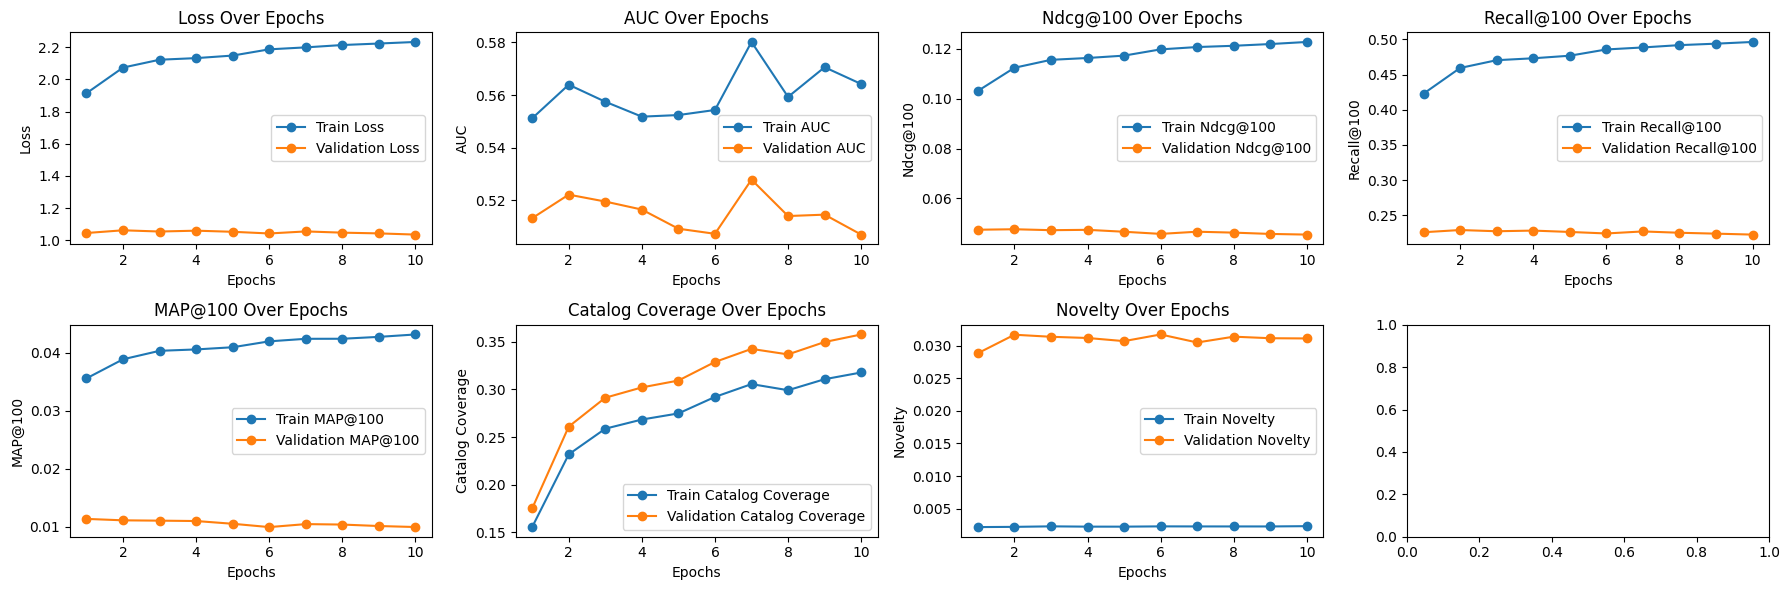

In [166]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


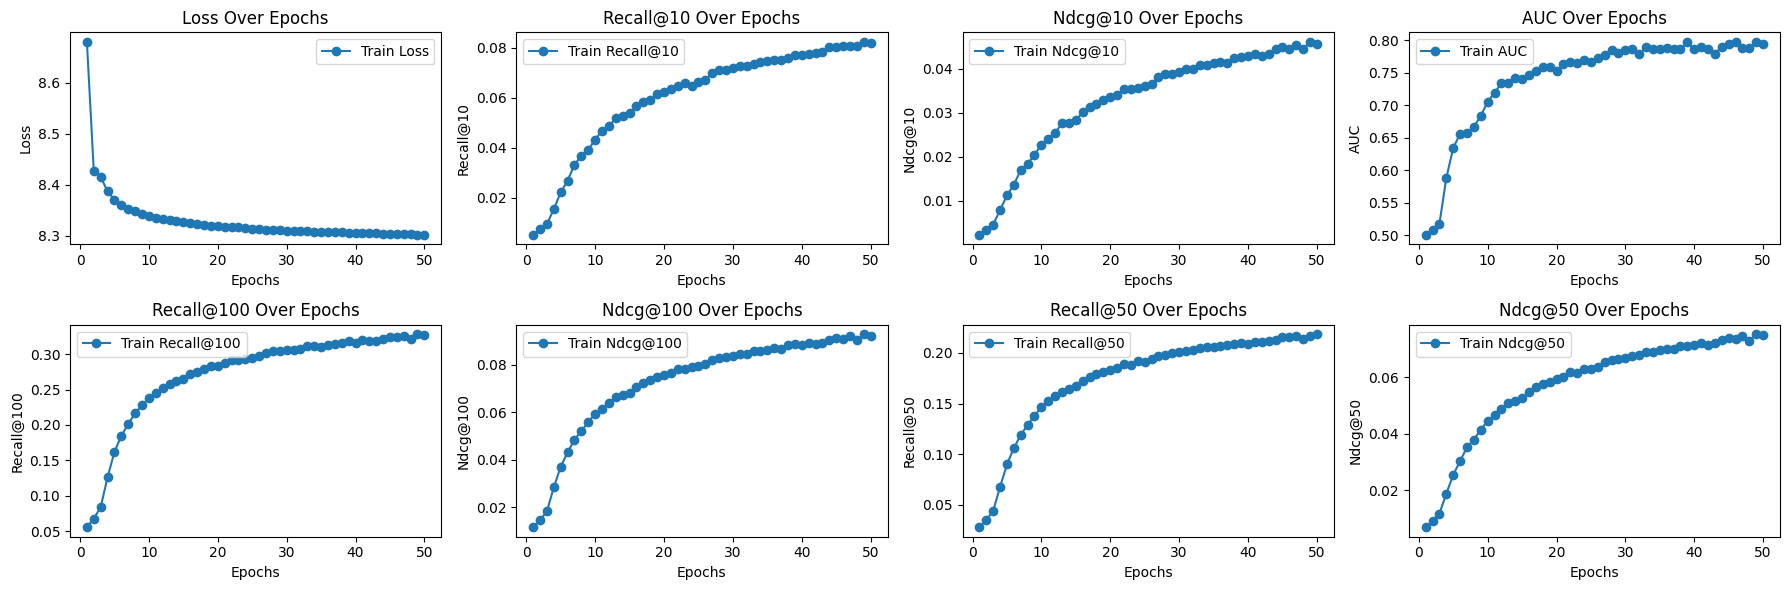

In [167]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [ ]:
# (model.evaluate(train, batch_size=2048, return_dict=True),
#  model.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model, train, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.8865 - auc_21: 0.4858 - recall_at_100: 0.3987 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0950 - map_at_100: 0.0316 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9057
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 1.8864508867263794,
 'auc_21': 0.4857785701751709,
 'recall_at_100': 0.3994045853614807,
 'mrr_at_100': 0.03349835425615311,
 'ndcg_at_100': 0.09687190502882004,
 'map_at_100': 0.03349835425615311,
 'precision_at_100': 0.003994045313447714,
 'regularization_loss': 0.0,
 'loss_batch': 2.818242073059082,
 'coverage': 1.0,
 'novelty': 0.04531693017444375}

In [ ]:
evaluate_model(model, valid, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.9953 - auc_22: 0.4727 - recall_at_100: 0.1899 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0358 - map_at_100: 0.0059 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0450
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 0.9952747225761414,
 'auc_22': 0.4727213978767395,
 'recall_at_100': 0.19292497634887695,
 'mrr_at_100': 0.006211184896528721,
 'ndcg_at_100': 0.0365414135158062,
 'map_at_100': 0.006211184896528721,
 'precision_at_100': 0.0019292497308924794,
 'regularization_loss': 0.0,
 'loss_batch': 1.5650469064712524,
 'coverage': 1.0,
 'novelty': 0.18732618196265396}

### model_v10

In [187]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = [128, 64] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size # @param
# _popularity_sampler = True
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [188]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

###
model_v10 = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction
)

train_evaluation_clbk_v10 = EvaluationCallback(period=5, topk=100, data=train, type_='Train')
valid_evaluation_clbk_v10 = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation')
history_v10 = []
###

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=[
        tf.keras.metrics.AUC(),
        topKMetricsAggregator(TOP_K)
        ],
    loss=_loss,
)



In [189]:
sampling_prob = model._output.post.candidate_probs.numpy()
import seaborn as sns
sns.lineplot(x=range(1,sampling_prob.shape[0]+1), y=sampling_prob)


AttributeError: ignored

In [190]:
VERSION = 'v10'

#### model

In [191]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

In [192]:
# %pdb on
# _epochs = 10
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 28s 332ms/step - loss: 7.5263 - auc_51: 0.5791 - auc: 0.5998 - recall_at_100: 0.0665 - mrr_at_100: 0.0047 - ndcg_at_100: 0.0150 - map_at_100: 0.0047 - precision_at_100: 6.6517e-04 - recall_at_50: 0.0348 - mrr_at_50: 0.0043 - ndcg_at_50: 0.0100 - map_at_50: 0.0043 - precision_at_50: 6.9679e-04 - recall_at_10: 0.0085 - mrr_at_10: 0.0032 - ndcg_at_10: 0.0044 - map_at_10: 0.0032 - precision_at_10: 8.4697e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4578
Epoch 2/50
35/35 [==============================] - 5s 124ms/step - loss: 7.2506 - auc_51: 0.6168 - auc: 0.6968 - recall_at_100: 0.1502 - mrr_at_100: 0.0111 - ndcg_at_100: 0.0346 - map_at_100: 0.0111 - precision_at_100: 0.0015 - recall_at_50: 0.0836 - mrr_at_50: 0.0102 - ndcg_at_50: 0.0239 - map_at_50: 0.0102 - precision_at_50: 0.0017 - recall_at_10: 0.0212 - mrr_at_10: 0.0077 - ndcg_at_10: 0.0108 - map_at_10: 0.0077 - precision_at_10: 0.0021 - regularization_loss: 0.0000e+00 - lo

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 20ms/step - loss: 1.2695 - auc: 0.4329 - recall_at_100: 0.2735 - mrr_at_100: 0.0166 - ndcg_at_100: 0.0600 - map_at_100: 0.0166 - precision_at_100: 0.0027 - recall_at_10: 0.0332 - mrr_at_10: 0.0101 - ndcg_at_10: 0.0154 - map_at_10: 0.0101 - precision_at_10: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 1.2755


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.2694696187973022, 'auc': 0.4328678250312805, 'recall_at_100': 0.27477848529815674, 'mrr_at_100': 0.016751952469348907, 'ndcg_at_100': 0.06034165620803833, 'map_at_100': 0.016751952469348907, 'precision_at_100': 0.0027477850671857595, 'recall_at_10': 0.03404461592435837, 'mrr_at_10': 0.010304613038897514, 'ndcg_at_10': 0.015736831352114677, 'map_at_10': 0.010304613038897514, 'precision_at_10': 0.0034044613130390644, 'regularization_loss': 0.0, 'loss_batch': 1.5639981031417847, 'coverage': 1.0, 'novelty': 0.02875701390583069}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.8221 - auc: 0.4484 - recall_at_100: 0.1699 - mrr_at_100: 0.0072 - ndcg_at_100: 0.0340 - map_at_100: 0.0072 - precision_at_100: 0.0017 - recall_at_10: 0.0130 - mrr_at_10: 0.0032 - ndcg_at_10: 0.0055 - map_at_10: 0.0032 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 0.8853
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8220541477203369, 'auc': 0.448373407125473, 'recall_at_100': 0.17527082562446594, 'mrr_at_100': 0.007693055551499128, 'ndcg_at_100': 0.03542177379131317, 'map_at_100': 0.007693055551499128, 'precision_at_100': 0.0017527082236483693, 'recall_at_10': 0.014377424493432045, 'mrr_at_10': 0.003650188446044922, 'ndcg_at_10': 0.006108086556196213, 'map_at_10': 0.003650188446044922, 'precision_at_10': 0.0014377423794940114, 'regularization_loss': 0.0, 'loss_batch': 1.5469982624053955, 'coverage': 1.0, 'novelty': 0.15862068965517243}
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 5s 104ms/step - loss: 7.0134 - auc_51: 0.6423 - auc: 0.7101 - recall_at_100: 0.2372 - mrr_at_100: 0.0244 - ndcg_at_100: 0.0614 - map_at_100: 0.0244 - precision_at_100: 0.0024 - recall_at_50: 0.1494 - mrr_at_50: 0.0232 - ndcg_at_50: 0.0473 - map_at_50: 0.0232 - precision_at_50: 0.0030 - recall_at_10: 0.0486 - mrr_at_10: 0.0190 - ndcg_at_10: 0.0258 - map_at_10: 0.0190 - precision_at_10: 0.0049 - regularization_loss: 0.0000e+00 - loss_batch: 6.9420
Epoch 7/50
35/35 [==============================] - 3s 49ms/step - loss: 6.9908 - auc_51: 0.6557 - auc: 0.7200 - recall_at_100: 0.2439 - mrr_at_100: 0.0269 - ndcg_at_100: 0.0646 - map_at_100: 0.0269 - precision_at_100: 0.0024 - recall_at_50: 0.1521 - mrr_at_50: 0.0256 - ndcg_at_50: 0.0498 - map_at_50: 0.0256 - precision_at_50: 0.0030 - recall_at_10: 0.0510 - mrr_at_10: 0.0214 - ndcg_at_10: 0.0282 - map_at_10: 0.0214 - precision_at_10: 0.0051 - regularization_loss: 0.0000e+00 - loss_batch: 6.9182
Epoch 8/

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 19ms/step - loss: 1.5204 - auc: 0.4904 - recall_at_100: 0.3239 - mrr_at_100: 0.0207 - ndcg_at_100: 0.0721 - map_at_100: 0.0207 - precision_at_100: 0.0032 - recall_at_10: 0.0424 - mrr_at_10: 0.0131 - ndcg_at_10: 0.0198 - map_at_10: 0.0131 - precision_at_10: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 1.5303
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.5204129219055176, 'auc': 0.4904079735279083, 'recall_at_100': 0.32613030076026917, 'mrr_at_100': 0.02152157388627529, 'ndcg_at_100': 0.07326026260852814, 'map_at_100': 0.02152157388627529, 'precision_at_100': 0.0032613028306514025, 'recall_at_10': 0.04417252913117409, 'mrr_at_10': 0.013841601088643074, 'ndcg_at_10': 0.02079855464398861, 'map_at_10': 0.013841601088643074, 'precision_at_10': 0.0044172536581754684, 'regularization_loss': 0.0, 'loss_batch': 2.0012295246124268, 'coverage': 1.0, 'novelty': 0.03685321244333281}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.9452 - auc: 0.4804 - recall_at_100: 0.1921 - mrr_at_100: 0.0076 - ndcg_at_100: 0.0380 - map_at_100: 0.0076 - precision_at_100: 0.0019 - recall_at_10: 0.0129 - mrr_at_10: 0.0032 - ndcg_at_10: 0.0054 - map_at_10: 0.0032 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 1.0130
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9452052116394043, 'auc': 0.4804092049598694, 'recall_at_100': 0.19693727791309357, 'mrr_at_100': 0.008039021864533424, 'ndcg_at_100': 0.039160843938589096, 'map_at_100': 0.008039021864533424, 'precision_at_100': 0.0019693728536367416, 'recall_at_10': 0.014109937474131584, 'mrr_at_10': 0.00347794103436172, 'ndcg_at_10': 0.005896325688809156, 'map_at_10': 0.00347794103436172, 'precision_at_10': 0.0014109938638284802, 'regularization_loss': 0.0, 'loss_batch': 1.7217298746109009, 'coverage': 1.0, 'novelty': 0.15753424657534248}
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 57ms/step - loss: 6.9186 - auc_51: 0.6809 - auc: 0.7471 - recall_at_100: 0.2657 - mrr_at_100: 0.0327 - ndcg_at_100: 0.0735 - map_at_100: 0.0327 - precision_at_100: 0.0027 - recall_at_50: 0.1704 - mrr_at_50: 0.0313 - ndcg_at_50: 0.0581 - map_at_50: 0.0313 - precision_at_50: 0.0034 - recall_at_10: 0.0629 - mrr_at_10: 0.0267 - ndcg_at_10: 0.0351 - map_at_10: 0.0267 - precision_at_10: 0.0063 - regularization_loss: 0.0000e+00 - loss_batch: 6.8420
Epoch 12/50
35/35 [==============================] - 3s 71ms/step - loss: 6.9018 - auc_51: 0.6818 - auc: 0.7473 - recall_at_100: 0.2713 - mrr_at_100: 0.0333 - ndcg_at_100: 0.0750 - map_at_100: 0.0333 - precision_at_100: 0.0027 - recall_at_50: 0.1764 - mrr_at_50: 0.0320 - ndcg_at_50: 0.0597 - map_at_50: 0.0320 - precision_at_50: 0.0035 - recall_at_10: 0.0636 - mrr_at_10: 0.0273 - ndcg_at_10: 0.0357 - map_at_10: 0.0273 - precision_at_10: 0.0064 - regularization_loss: 0.0000e+00 - loss_batch: 6.8243
Epoch 13

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 7s 23ms/step - loss: 1.6684 - auc: 0.5192 - recall_at_100: 0.3531 - mrr_at_100: 0.0258 - ndcg_at_100: 0.0819 - map_at_100: 0.0258 - precision_at_100: 0.0035 - recall_at_10: 0.0538 - mrr_at_10: 0.0173 - ndcg_at_10: 0.0257 - map_at_10: 0.0173 - precision_at_10: 0.0054 - regularization_loss: 0.0000e+00 - loss_batch: 1.6794


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6684441566467285, 'auc': 0.5191543698310852, 'recall_at_100': 0.3559015393257141, 'mrr_at_100': 0.026252135634422302, 'ndcg_at_100': 0.08273978531360626, 'map_at_100': 0.026252135634422302, 'precision_at_100': 0.0035590152256190777, 'recall_at_10': 0.054286204278469086, 'mrr_at_10': 0.017783209681510925, 'ndcg_at_10': 0.026159193366765976, 'map_at_10': 0.017783209681510925, 'precision_at_10': 0.005428620148450136, 'regularization_loss': 0.0, 'loss_batch': 2.2013649940490723, 'coverage': 1.0, 'novelty': 0.041771871539313395}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.9529 - auc: 0.5139 - recall_at_100: 0.1888 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0370 - map_at_100: 0.0073 - precision_at_100: 0.0019 - recall_at_10: 0.0131 - mrr_at_10: 0.0031 - ndcg_at_10: 0.0054 - map_at_10: 0.0031 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 1.0079
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9528759717941284, 'auc': 0.5138691663742065, 'recall_at_100': 0.19345994293689728, 'mrr_at_100': 0.007440814282745123, 'ndcg_at_100': 0.03791768103837967, 'map_at_100': 0.007440814282745123, 'precision_at_100': 0.0019345995970070362, 'recall_at_10': 0.01290624588727951, 'mrr_at_10': 0.003072172636166215, 'ndcg_at_10': 0.005298806820064783, 'map_at_10': 0.003072172636166215, 'precision_at_10': 0.0012906246120110154, 'regularization_loss': 0.0, 'loss_batch': 1.583540678024292, 'coverage': 1.0, 'novelty': 0.18867547018807523}
35/35 [==============================]

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 67ms/step - loss: 6.8531 - auc_51: 0.6969 - auc: 0.7559 - recall_at_100: 0.2870 - mrr_at_100: 0.0372 - ndcg_at_100: 0.0810 - map_at_100: 0.0372 - precision_at_100: 0.0029 - recall_at_50: 0.1868 - mrr_at_50: 0.0358 - ndcg_at_50: 0.0649 - map_at_50: 0.0358 - precision_at_50: 0.0037 - recall_at_10: 0.0702 - mrr_at_10: 0.0308 - ndcg_at_10: 0.0399 - map_at_10: 0.0308 - precision_at_10: 0.0070 - regularization_loss: 0.0000e+00 - loss_batch: 6.7726
Epoch 17/50
35/35 [==============================] - 3s 69ms/step - loss: 6.8404 - auc_51: 0.6975 - auc: 0.7572 - recall_at_100: 0.2909 - mrr_at_100: 0.0384 - ndcg_at_100: 0.0829 - map_at_100: 0.0384 - precision_at_100: 0.0029 - recall_at_50: 0.1927 - mrr_at_50: 0.0371 - ndcg_at_50: 0.0670 - map_at_50: 0.0371 - precision_at_50: 0.0039 - recall_at_10: 0.0714 - mrr_at_10: 0.0318 - ndcg_at_10: 0.0410 - map_at_10: 0.0318 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 6.7586
Epoch 18

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 19ms/step - loss: 1.8262 - auc: 0.5565 - recall_at_100: 0.3868 - mrr_at_100: 0.0300 - ndcg_at_100: 0.0914 - map_at_100: 0.0300 - precision_at_100: 0.0039 - recall_at_10: 0.0633 - mrr_at_10: 0.0209 - ndcg_at_10: 0.0307 - map_at_10: 0.0209 - precision_at_10: 0.0063 - regularization_loss: 0.0000e+00 - loss_batch: 1.8398
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8261873722076416, 'auc': 0.5565364956855774, 'recall_at_100': 0.38910573720932007, 'mrr_at_100': 0.03040572814643383, 'ndcg_at_100': 0.09220568835735321, 'map_at_100': 0.03040572814643383, 'precision_at_100': 0.0038910568691790104, 'recall_at_10': 0.06431441009044647, 'mrr_at_10': 0.021179378032684326, 'ndcg_at_10': 0.031088760122656822, 'map_at_10': 0.021179378032684326, 'precision_at_10': 0.00643144128844142, 'regularization_loss': 0.0, 'loss_batch': 2.4864659309387207, 'coverage': 1.0, 'novelty': 0.04126372905089048}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.9634 - auc: 0.5465 - recall_at_100: 0.1924 - mrr_at_100: 0.0068 - ndcg_at_100: 0.0371 - map_at_100: 0.0068 - precision_at_100: 0.0019 - recall_at_10: 0.0116 - mrr_at_10: 0.0024 - ndcg_at_10: 0.0045 - map_at_10: 0.0024 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 1.0157
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.963432788848877, 'auc': 0.5465087294578552, 'recall_at_100': 0.1926574856042862, 'mrr_at_100': 0.006937950383871794, 'ndcg_at_100': 0.0372827984392643, 'map_at_100': 0.006937950383871794, 'precision_at_100': 0.0019265749724581838, 'recall_at_10': 0.011501939035952091, 'mrr_at_10': 0.002596189035102725, 'ndcg_at_10': 0.004595564678311348, 'map_at_10': 0.002596189035102725, 'precision_at_10': 0.0011501939734444022, 'regularization_loss': 0.0, 'loss_batch': 1.5622814893722534, 'coverage': 1.0, 'novelty': 0.19335657166290754}
35/35 [==============================] 

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 49ms/step - loss: 6.8070 - auc_51: 0.6963 - auc: 0.7506 - recall_at_100: 0.2999 - mrr_at_100: 0.0414 - ndcg_at_100: 0.0870 - map_at_100: 0.0414 - precision_at_100: 0.0030 - recall_at_50: 0.2012 - mrr_at_50: 0.0400 - ndcg_at_50: 0.0710 - map_at_50: 0.0400 - precision_at_50: 0.0040 - recall_at_10: 0.0769 - mrr_at_10: 0.0347 - ndcg_at_10: 0.0445 - map_at_10: 0.0347 - precision_at_10: 0.0077 - regularization_loss: 0.0000e+00 - loss_batch: 6.7212
Epoch 22/50
35/35 [==============================] - 3s 70ms/step - loss: 6.7958 - auc_51: 0.6990 - auc: 0.7517 - recall_at_100: 0.3059 - mrr_at_100: 0.0421 - ndcg_at_100: 0.0887 - map_at_100: 0.0421 - precision_at_100: 0.0031 - recall_at_50: 0.2038 - mrr_at_50: 0.0407 - ndcg_at_50: 0.0722 - map_at_50: 0.0407 - precision_at_50: 0.0041 - recall_at_10: 0.0795 - mrr_at_10: 0.0354 - ndcg_at_10: 0.0457 - map_at_10: 0.0354 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 6.7106
Epoch 23

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 20ms/step - loss: 1.8847 - auc: 0.5868 - recall_at_100: 0.4011 - mrr_at_100: 0.0332 - ndcg_at_100: 0.0970 - map_at_100: 0.0332 - precision_at_100: 0.0040 - recall_at_10: 0.0711 - mrr_at_10: 0.0236 - ndcg_at_10: 0.0346 - map_at_10: 0.0236 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 1.8971


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8846732378005981, 'auc': 0.5868467688560486, 'recall_at_100': 0.40057262778282166, 'mrr_at_100': 0.033247534185647964, 'ndcg_at_100': 0.09689264744520187, 'map_at_100': 0.033247534185647964, 'precision_at_100': 0.0040057264268398285, 'recall_at_10': 0.07041110098361969, 'mrr_at_10': 0.023660527542233467, 'ndcg_at_10': 0.034417640417814255, 'map_at_10': 0.023660527542233467, 'precision_at_10': 0.0070411101914942265, 'regularization_loss': 0.0, 'loss_batch': 2.4856135845184326, 'coverage': 1.0, 'novelty': 0.043981157595261416}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 23ms/step - loss: 0.9592 - auc: 0.5870 - recall_at_100: 0.1841 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0352 - map_at_100: 0.0063 - precision_at_100: 0.0018 - recall_at_10: 0.0095 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0038 - map_at_10: 0.0022 - precision_at_10: 9.5116e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0156
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9591900706291199, 'auc': 0.5870480537414551, 'recall_at_100': 0.1885783076286316, 'mrr_at_100': 0.006462802644819021, 'ndcg_at_100': 0.03610759228467941, 'map_at_100': 0.006462802644819021, 'precision_at_100': 0.0018857828108593822, 'recall_at_10': 0.009228300303220749, 'mrr_at_10': 0.002178055001422763, 'ndcg_at_10': 0.0037645394913852215, 'map_at_10': 0.002178055001422763, 'precision_at_10': 0.0009228300186805427, 'regularization_loss': 0.0, 'loss_batch': 1.605765700340271, 'coverage': 1.0, 'novelty': 0.19459347915806852}
35/35 [==========================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 64ms/step - loss: 6.7727 - auc_51: 0.6971 - auc: 0.7437 - recall_at_100: 0.3114 - mrr_at_100: 0.0441 - ndcg_at_100: 0.0914 - map_at_100: 0.0441 - precision_at_100: 0.0031 - recall_at_50: 0.2084 - mrr_at_50: 0.0427 - ndcg_at_50: 0.0747 - map_at_50: 0.0427 - precision_at_50: 0.0042 - recall_at_10: 0.0830 - mrr_at_10: 0.0373 - ndcg_at_10: 0.0479 - map_at_10: 0.0373 - precision_at_10: 0.0083 - regularization_loss: 0.0000e+00 - loss_batch: 6.6845
Epoch 27/50
35/35 [==============================] - 3s 69ms/step - loss: 6.7652 - auc_51: 0.6999 - auc: 0.7466 - recall_at_100: 0.3124 - mrr_at_100: 0.0436 - ndcg_at_100: 0.0911 - map_at_100: 0.0436 - precision_at_100: 0.0031 - recall_at_50: 0.2096 - mrr_at_50: 0.0422 - ndcg_at_50: 0.0745 - map_at_50: 0.0422 - precision_at_50: 0.0042 - recall_at_10: 0.0812 - mrr_at_10: 0.0367 - ndcg_at_10: 0.0470 - map_at_10: 0.0367 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 6.6762
Epoch 28

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 21ms/step - loss: 2.0020 - auc: 0.5970 - recall_at_100: 0.4250 - mrr_at_100: 0.0354 - ndcg_at_100: 0.1030 - map_at_100: 0.0354 - precision_at_100: 0.0043 - recall_at_10: 0.0750 - mrr_at_10: 0.0251 - ndcg_at_10: 0.0366 - map_at_10: 0.0251 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 2.0146
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0019826889038086, 'auc': 0.596979558467865, 'recall_at_100': 0.42672574520111084, 'mrr_at_100': 0.036232348531484604, 'ndcg_at_100': 0.10413122922182083, 'map_at_100': 0.036232348531484604, 'precision_at_100': 0.004267258103936911, 'recall_at_10': 0.077789805829525, 'mrr_at_10': 0.025963587686419487, 'ndcg_at_10': 0.03787894546985626, 'map_at_10': 0.025963587686419487, 'precision_at_10': 0.007778982166200876, 'regularization_loss': 0.0, 'loss_batch': 2.6147215366363525, 'coverage': 1.0, 'novelty': 0.042719942013228235}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.9977 - auc: 0.5984 - recall_at_100: 0.1944 - mrr_at_100: 0.0064 - ndcg_at_100: 0.0369 - map_at_100: 0.0064 - precision_at_100: 0.0019 - recall_at_10: 0.0086 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0035 - map_at_10: 0.0020 - precision_at_10: 8.5819e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0455
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9976858496665955, 'auc': 0.5983660221099854, 'recall_at_100': 0.1966697871685028, 'mrr_at_100': 0.006664117332547903, 'ndcg_at_100': 0.03763113543391228, 'map_at_100': 0.006664117332547903, 'precision_at_100': 0.0019666976295411587, 'recall_at_10': 0.009562659077346325, 'mrr_at_10': 0.0021711555309593678, 'ndcg_at_10': 0.003838665084913373, 'map_at_10': 0.0021711555309593678, 'precision_at_10': 0.0009562658378854394, 'regularization_loss': 0.0, 'loss_batch': 1.5453864336013794, 'coverage': 1.0, 'novelty': 0.17590001865323635}
35/35 [========================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 46ms/step - loss: 6.7436 - auc_51: 0.6980 - auc: 0.7418 - recall_at_100: 0.3213 - mrr_at_100: 0.0456 - ndcg_at_100: 0.0945 - map_at_100: 0.0456 - precision_at_100: 0.0032 - recall_at_50: 0.2165 - mrr_at_50: 0.0441 - ndcg_at_50: 0.0776 - map_at_50: 0.0441 - precision_at_50: 0.0043 - recall_at_10: 0.0855 - mrr_at_10: 0.0384 - ndcg_at_10: 0.0494 - map_at_10: 0.0384 - precision_at_10: 0.0085 - regularization_loss: 0.0000e+00 - loss_batch: 6.6535
Epoch 32/50
35/35 [==============================] - 3s 68ms/step - loss: 6.7421 - auc_51: 0.6985 - auc: 0.7425 - recall_at_100: 0.3202 - mrr_at_100: 0.0454 - ndcg_at_100: 0.0940 - map_at_100: 0.0454 - precision_at_100: 0.0032 - recall_at_50: 0.2138 - mrr_at_50: 0.0439 - ndcg_at_50: 0.0768 - map_at_50: 0.0439 - precision_at_50: 0.0043 - recall_at_10: 0.0856 - mrr_at_10: 0.0383 - ndcg_at_10: 0.0493 - map_at_10: 0.0383 - precision_at_10: 0.0086 - regularization_loss: 0.0000e+00 - loss_batch: 6.6523
Epoch 33

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 19ms/step - loss: 2.0332 - auc: 0.6109 - recall_at_100: 0.4345 - mrr_at_100: 0.0367 - ndcg_at_100: 0.1059 - map_at_100: 0.0367 - precision_at_100: 0.0043 - recall_at_10: 0.0795 - mrr_at_10: 0.0262 - ndcg_at_10: 0.0384 - map_at_10: 0.0262 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 2.0459


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0332303047180176, 'auc': 0.6109352707862854, 'recall_at_100': 0.4324662983417511, 'mrr_at_100': 0.03703761473298073, 'ndcg_at_100': 0.10591962933540344, 'map_at_100': 0.03703761473298073, 'precision_at_100': 0.0043246629647910595, 'recall_at_10': 0.08036807924509048, 'mrr_at_10': 0.026633648201823235, 'ndcg_at_10': 0.038982588797807693, 'map_at_10': 0.026633648201823235, 'precision_at_10': 0.008036806248128414, 'regularization_loss': 0.0, 'loss_batch': 2.645444393157959, 'coverage': 1.0, 'novelty': 0.04420174369550951}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 32ms/step - loss: 1.0006 - auc: 0.6062 - recall_at_100: 0.1944 - mrr_at_100: 0.0062 - ndcg_at_100: 0.0366 - map_at_100: 0.0062 - precision_at_100: 0.0019 - recall_at_10: 0.0081 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0032 - map_at_10: 0.0018 - precision_at_10: 8.1130e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0504
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0006486177444458, 'auc': 0.6061580777168274, 'recall_at_100': 0.1945967674255371, 'mrr_at_100': 0.006282886024564505, 'ndcg_at_100': 0.036849990487098694, 'map_at_100': 0.006282886024564505, 'precision_at_100': 0.0019459675531834364, 'recall_at_10': 0.008358967490494251, 'mrr_at_10': 0.0018412284553050995, 'ndcg_at_10': 0.003322405507788062, 'map_at_10': 0.0018412284553050995, 'precision_at_10': 0.0008358967606909573, 'regularization_loss': 0.0, 'loss_batch': 1.570677638053894, 'coverage': 1.0, 'novelty': 0.18421566712248486}
35/35 [========================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 2s 46ms/step - loss: 6.7219 - auc_51: 0.6888 - auc: 0.7325 - recall_at_100: 0.3262 - mrr_at_100: 0.0480 - ndcg_at_100: 0.0974 - map_at_100: 0.0480 - precision_at_100: 0.0033 - recall_at_50: 0.2213 - mrr_at_50: 0.0465 - ndcg_at_50: 0.0805 - map_at_50: 0.0465 - precision_at_50: 0.0044 - recall_at_10: 0.0916 - mrr_at_10: 0.0410 - ndcg_at_10: 0.0527 - map_at_10: 0.0410 - precision_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 6.6308
Epoch 37/50
35/35 [==============================] - 2s 43ms/step - loss: 6.7182 - auc_51: 0.6825 - auc: 0.7264 - recall_at_100: 0.3262 - mrr_at_100: 0.0473 - ndcg_at_100: 0.0968 - map_at_100: 0.0473 - precision_at_100: 0.0033 - recall_at_50: 0.2204 - mrr_at_50: 0.0458 - ndcg_at_50: 0.0797 - map_at_50: 0.0458 - precision_at_50: 0.0044 - recall_at_10: 0.0885 - mrr_at_10: 0.0401 - ndcg_at_10: 0.0514 - map_at_10: 0.0401 - precision_at_10: 0.0089 - regularization_loss: 0.0000e+00 - loss_batch: 6.6269
Epoch 38

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 20ms/step - loss: 2.0052 - auc: 0.6168 - recall_at_100: 0.4216 - mrr_at_100: 0.0368 - ndcg_at_100: 0.1039 - map_at_100: 0.0368 - precision_at_100: 0.0042 - recall_at_10: 0.0795 - mrr_at_10: 0.0267 - ndcg_at_10: 0.0388 - map_at_10: 0.0267 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.0166


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0052413940429688, 'auc': 0.6168282628059387, 'recall_at_100': 0.4245463013648987, 'mrr_at_100': 0.03759991377592087, 'ndcg_at_100': 0.1051974818110466, 'map_at_100': 0.03759991377592087, 'precision_at_100': 0.004245462827384472, 'recall_at_10': 0.08162160962820053, 'mrr_at_10': 0.027408557012677193, 'ndcg_at_10': 0.039889272302389145, 'map_at_10': 0.027408557012677193, 'precision_at_10': 0.008162159472703934, 'regularization_loss': 0.0, 'loss_batch': 2.5564944744110107, 'coverage': 1.0, 'novelty': 0.04426398798347728}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 32ms/step - loss: 0.9526 - auc: 0.6146 - recall_at_100: 0.1752 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0325 - map_at_100: 0.0051 - precision_at_100: 0.0018 - recall_at_10: 0.0053 - mrr_at_10: 0.0012 - ndcg_at_10: 0.0021 - map_at_10: 0.0012 - precision_at_10: 5.2812e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0184
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9526057839393616, 'auc': 0.6146272420883179, 'recall_at_100': 0.18222549557685852, 'mrr_at_100': 0.005489995237439871, 'ndcg_at_100': 0.03407548740506172, 'map_at_100': 0.005489995237439871, 'precision_at_100': 0.0018222550861537457, 'recall_at_10': 0.005951584782451391, 'mrr_at_10': 0.0013411499094218016, 'ndcg_at_10': 0.0023828321136534214, 'map_at_10': 0.0013411499094218016, 'precision_at_10': 0.0005951584316790104, 'regularization_loss': 0.0, 'loss_batch': 1.7063815593719482, 'coverage': 1.0, 'novelty': 0.18931941377233488}
35/35 [======================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 72ms/step - loss: 6.7024 - auc_51: 0.6661 - auc: 0.7135 - recall_at_100: 0.3333 - mrr_at_100: 0.0488 - ndcg_at_100: 0.0993 - map_at_100: 0.0488 - precision_at_100: 0.0033 - recall_at_50: 0.2267 - mrr_at_50: 0.0473 - ndcg_at_50: 0.0821 - map_at_50: 0.0473 - precision_at_50: 0.0045 - recall_at_10: 0.0918 - mrr_at_10: 0.0414 - ndcg_at_10: 0.0531 - map_at_10: 0.0414 - precision_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 6.6111
Epoch 42/50
35/35 [==============================] - 3s 62ms/step - loss: 6.6997 - auc_51: 0.6637 - auc: 0.7118 - recall_at_100: 0.3323 - mrr_at_100: 0.0489 - ndcg_at_100: 0.0993 - map_at_100: 0.0489 - precision_at_100: 0.0033 - recall_at_50: 0.2279 - mrr_at_50: 0.0475 - ndcg_at_50: 0.0824 - map_at_50: 0.0475 - precision_at_50: 0.0046 - recall_at_10: 0.0914 - mrr_at_10: 0.0416 - ndcg_at_10: 0.0532 - map_at_10: 0.0416 - precision_at_10: 0.0091 - regularization_loss: 0.0000e+00 - loss_batch: 6.6068
Epoch 43

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 7s 23ms/step - loss: 2.0991 - auc: 0.6120 - recall_at_100: 0.4401 - mrr_at_100: 0.0386 - ndcg_at_100: 0.1087 - map_at_100: 0.0386 - precision_at_100: 0.0044 - recall_at_10: 0.0829 - mrr_at_10: 0.0279 - ndcg_at_10: 0.0405 - map_at_10: 0.0279 - precision_at_10: 0.0083 - regularization_loss: 0.0000e+00 - loss_batch: 2.1105


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.099142074584961, 'auc': 0.6120054721832275, 'recall_at_100': 0.44323524832725525, 'mrr_at_100': 0.03862464055418968, 'ndcg_at_100': 0.10928274691104889, 'map_at_100': 0.03862464055418968, 'precision_at_100': 0.004432352725416422, 'recall_at_10': 0.08381527662277222, 'mrr_at_10': 0.02788868360221386, 'ndcg_at_10': 0.04075350984930992, 'map_at_10': 0.02788868360221386, 'precision_at_10': 0.008381526917219162, 'regularization_loss': 0.0, 'loss_batch': 2.6503348350524902, 'coverage': 1.0, 'novelty': 0.04630720879984286}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 37ms/step - loss: 0.9648 - auc: 0.6135 - recall_at_100: 0.1803 - mrr_at_100: 0.0053 - ndcg_at_100: 0.0335 - map_at_100: 0.0053 - precision_at_100: 0.0018 - recall_at_10: 0.0066 - mrr_at_10: 0.0012 - ndcg_at_10: 0.0024 - map_at_10: 0.0012 - precision_at_10: 6.5512e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0180
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9647526741027832, 'auc': 0.6134598255157471, 'recall_at_100': 0.18423163890838623, 'mrr_at_100': 0.005534597672522068, 'ndcg_at_100': 0.03449290618300438, 'map_at_100': 0.005534597672522068, 'precision_at_100': 0.001842316472902894, 'recall_at_10': 0.007289019878953695, 'mrr_at_10': 0.0013390535023063421, 'ndcg_at_10': 0.002650502836331725, 'map_at_10': 0.0013390535023063421, 'precision_at_10': 0.0007289019413292408, 'regularization_loss': 0.0, 'loss_batch': 1.5742775201797485, 'coverage': 1.0, 'novelty': 0.18439577630035198}
35/35 [========================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 52ms/step - loss: 6.6887 - auc_51: 0.6411 - auc: 0.6948 - recall_at_100: 0.3334 - mrr_at_100: 0.0491 - ndcg_at_100: 0.0996 - map_at_100: 0.0491 - precision_at_100: 0.0033 - recall_at_50: 0.2273 - mrr_at_50: 0.0476 - ndcg_at_50: 0.0824 - map_at_50: 0.0476 - precision_at_50: 0.0045 - recall_at_10: 0.0917 - mrr_at_10: 0.0417 - ndcg_at_10: 0.0534 - map_at_10: 0.0417 - precision_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 6.5958
Epoch 47/50
35/35 [==============================] - 2s 46ms/step - loss: 6.6863 - auc_51: 0.6354 - auc: 0.6911 - recall_at_100: 0.3369 - mrr_at_100: 0.0492 - ndcg_at_100: 0.1004 - map_at_100: 0.0492 - precision_at_100: 0.0034 - recall_at_50: 0.2317 - mrr_at_50: 0.0477 - ndcg_at_50: 0.0834 - map_at_50: 0.0477 - precision_at_50: 0.0046 - recall_at_10: 0.0928 - mrr_at_10: 0.0418 - ndcg_at_10: 0.0536 - map_at_10: 0.0418 - precision_at_10: 0.0093 - regularization_loss: 0.0000e+00 - loss_batch: 6.5925
Epoch 48

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 20ms/step - loss: 2.1287 - auc: 0.6140 - recall_at_100: 0.4471 - mrr_at_100: 0.0393 - ndcg_at_100: 0.1108 - map_at_100: 0.0393 - precision_at_100: 0.0045 - recall_at_10: 0.0876 - mrr_at_10: 0.0285 - ndcg_at_10: 0.0421 - map_at_10: 0.0285 - precision_at_10: 0.0088 - regularization_loss: 0.0000e+00 - loss_batch: 2.1402


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.128666400909424, 'auc': 0.6140308380126953, 'recall_at_100': 0.45175349712371826, 'mrr_at_100': 0.040217041969299316, 'ndcg_at_100': 0.11232919991016388, 'map_at_100': 0.040217041969299316, 'precision_at_100': 0.004517534282058477, 'recall_at_10': 0.08871541917324066, 'mrr_at_10': 0.029286105185747147, 'ndcg_at_10': 0.04294963926076889, 'map_at_10': 0.029286105185747147, 'precision_at_10': 0.008871544152498245, 'regularization_loss': 0.0, 'loss_batch': 2.6875600814819336, 'coverage': 1.0, 'novelty': 0.04513257394467311}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 31ms/step - loss: 0.9667 - auc: 0.6118 - recall_at_100: 0.1782 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0330 - map_at_100: 0.0051 - precision_at_100: 0.0018 - recall_at_10: 0.0056 - mrr_at_10: 0.0011 - ndcg_at_10: 0.0021 - map_at_10: 0.0011 - precision_at_10: 5.5731e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0214
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9667277336120605, 'auc': 0.6117919087409973, 'recall_at_100': 0.18396416306495667, 'mrr_at_100': 0.005423768889158964, 'ndcg_at_100': 0.034266673028469086, 'map_at_100': 0.005423768889158964, 'precision_at_100': 0.0018396414816379547, 'recall_at_10': 0.006085328292101622, 'mrr_at_10': 0.001269156695343554, 'ndcg_at_10': 0.0023573250509798527, 'map_at_10': 0.001269156695343554, 'precision_at_10': 0.0006085329223424196, 'regularization_loss': 0.0, 'loss_batch': 1.5928384065628052, 'coverage': 1.0, 'novelty': 0.18829872204472844}
35/35 [=======================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


#### analysis

In [193]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

Plot for model v10


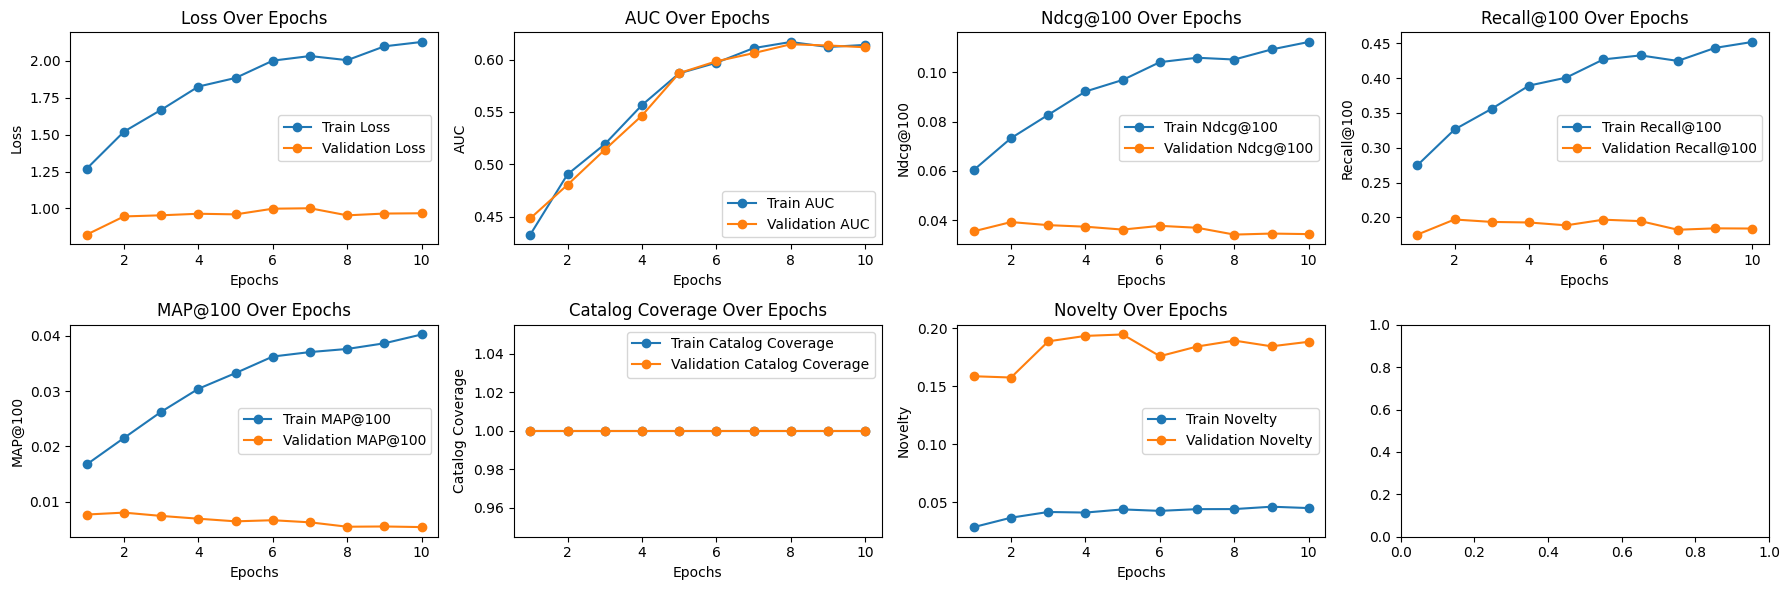

In [194]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


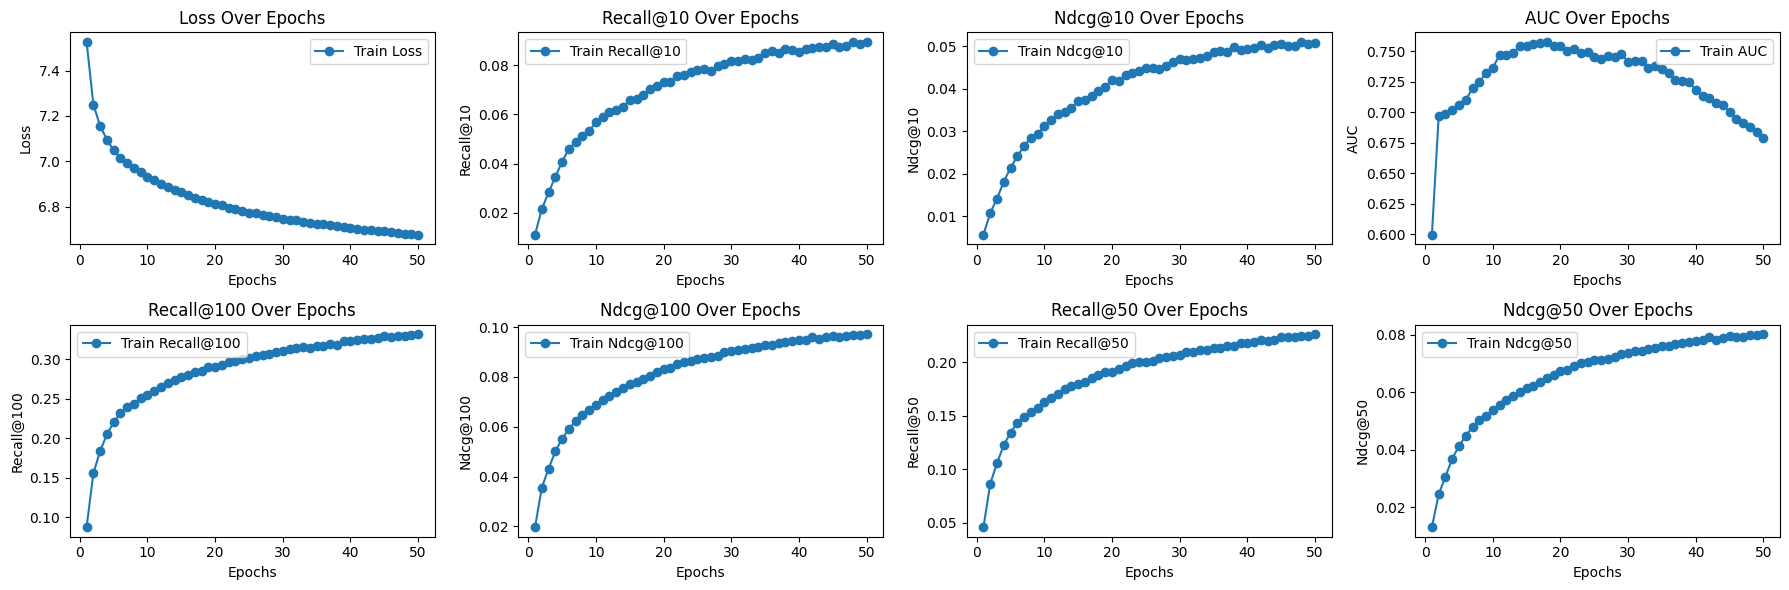

In [195]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [ ]:
# (model.evaluate(train, batch_size=2048, return_dict=True),
#  model.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model, train, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.8865 - auc_21: 0.4858 - recall_at_100: 0.3987 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0950 - map_at_100: 0.0316 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9057
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 1.8864508867263794,
 'auc_21': 0.4857785701751709,
 'recall_at_100': 0.3994045853614807,
 'mrr_at_100': 0.03349835425615311,
 'ndcg_at_100': 0.09687190502882004,
 'map_at_100': 0.03349835425615311,
 'precision_at_100': 0.003994045313447714,
 'regularization_loss': 0.0,
 'loss_batch': 2.818242073059082,
 'coverage': 1.0,
 'novelty': 0.04531693017444375}

In [ ]:
evaluate_model(model, valid, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.9953 - auc_22: 0.4727 - recall_at_100: 0.1899 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0358 - map_at_100: 0.0059 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0450
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 0.9952747225761414,
 'auc_22': 0.4727213978767395,
 'recall_at_100': 0.19292497634887695,
 'mrr_at_100': 0.006211184896528721,
 'ndcg_at_100': 0.0365414135158062,
 'map_at_100': 0.006211184896528721,
 'precision_at_100': 0.0019292497308924794,
 'regularization_loss': 0.0,
 'loss_batch': 1.5650469064712524,
 'coverage': 1.0,
 'novelty': 0.18732618196265396}

### model_v11

In [196]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = [128, 64] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size # @param
# _popularity_sampler = True
_validation_freq = 5 # @param
# _loss = 'categorical_crossentropy' # @param
_loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [197]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

###
model_v11 = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction
)

train_evaluation_clbk_v11 = EvaluationCallback(period=5, topk=100, data=train, type_='Train')
valid_evaluation_clbk_v11 = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation')
history_v11 = []
###

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=[
        tf.keras.metrics.AUC(),
        topKMetricsAggregator(TOP_K)
        ],
    loss=_loss,
)



In [198]:
sampling_prob = model._output.post.candidate_probs.numpy()
import seaborn as sns
sns.lineplot(x=range(1,sampling_prob.shape[0]+1), y=sampling_prob)


AttributeError: ignored

In [199]:
VERSION = 'v11'

#### model

In [200]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

In [201]:
# %pdb on
# _epochs = 10
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 24s 242ms/step - loss: 8.4083 - auc_52: 0.5829 - auc: 0.6113 - recall_at_100: 0.0673 - mrr_at_100: 0.0044 - ndcg_at_100: 0.0149 - map_at_100: 0.0044 - precision_at_100: 6.7327e-04 - recall_at_50: 0.0347 - mrr_at_50: 0.0040 - ndcg_at_50: 0.0097 - map_at_50: 0.0040 - precision_at_50: 6.9443e-04 - recall_at_10: 0.0078 - mrr_at_10: 0.0029 - ndcg_at_10: 0.0040 - map_at_10: 0.0029 - precision_at_10: 7.7774e-04 - regularization_loss: 0.0000e+00 - loss_batch: 8.3485
Epoch 2/50
35/35 [==============================] - 9s 234ms/step - loss: 8.3653 - auc_52: 0.7058 - auc: 0.7376 - recall_at_100: 0.1671 - mrr_at_100: 0.0122 - ndcg_at_100: 0.0383 - map_at_100: 0.0122 - precision_at_100: 0.0017 - recall_at_50: 0.0928 - mrr_at_50: 0.0111 - ndcg_at_50: 0.0264 - map_at_50: 0.0111 - precision_at_50: 0.0019 - recall_at_10: 0.0230 - mrr_at_10: 0.0083 - ndcg_at_10: 0.0117 - map_at_10: 0.0083 - precision_at_10: 0.0023 - regularization_loss: 0.0000e+00 - lo

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 20ms/step - loss: 1.3104 - auc: 0.5209 - recall_at_100: 0.2861 - mrr_at_100: 0.0169 - ndcg_at_100: 0.0624 - map_at_100: 0.0169 - precision_at_100: 0.0029 - recall_at_10: 0.0338 - mrr_at_10: 0.0101 - ndcg_at_10: 0.0155 - map_at_10: 0.0101 - precision_at_10: 0.0034 - regularization_loss: 0.0000e+00 - loss_batch: 1.3185


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.310448169708252, 'auc': 0.5208725929260254, 'recall_at_100': 0.2849491536617279, 'mrr_at_100': 0.017134668305516243, 'ndcg_at_100': 0.06238150969147682, 'map_at_100': 0.017134668305516243, 'precision_at_100': 0.002849490847438574, 'recall_at_10': 0.03478533402085304, 'mrr_at_10': 0.01040999311953783, 'ndcg_at_10': 0.015990043058991432, 'map_at_10': 0.01040999311953783, 'precision_at_10': 0.003478533122688532, 'regularization_loss': 0.0, 'loss_batch': 1.6994572877883911, 'coverage': 1.0, 'novelty': 0.029682090022033362}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 23ms/step - loss: 0.8647 - auc: 0.5178 - recall_at_100: 0.1831 - mrr_at_100: 0.0079 - ndcg_at_100: 0.0368 - map_at_100: 0.0079 - precision_at_100: 0.0018 - recall_at_10: 0.0152 - mrr_at_10: 0.0038 - ndcg_at_10: 0.0064 - map_at_10: 0.0038 - precision_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 0.9305
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8647401928901672, 'auc': 0.5178298354148865, 'recall_at_100': 0.187240868806839, 'mrr_at_100': 0.008334271609783173, 'ndcg_at_100': 0.03791574761271477, 'map_at_100': 0.008334271609783173, 'precision_at_100': 0.0018724086694419384, 'recall_at_10': 0.01591547392308712, 'mrr_at_10': 0.004060786683112383, 'ndcg_at_10': 0.006755775306373835, 'map_at_10': 0.004060786683112383, 'precision_at_10': 0.0015915475087240338, 'regularization_loss': 0.0, 'loss_batch': 1.6182748079299927, 'coverage': 0.9992790194664743, 'novelty': 0.16141732283464566}
35/35 [=================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 92ms/step - loss: 8.3344 - auc_52: 0.7546 - auc: 0.7896 - recall_at_100: 0.2529 - mrr_at_100: 0.0261 - ndcg_at_100: 0.0655 - map_at_100: 0.0261 - precision_at_100: 0.0025 - recall_at_50: 0.1590 - mrr_at_50: 0.0247 - ndcg_at_50: 0.0503 - map_at_50: 0.0247 - precision_at_50: 0.0032 - recall_at_10: 0.0514 - mrr_at_10: 0.0202 - ndcg_at_10: 0.0274 - map_at_10: 0.0202 - precision_at_10: 0.0051 - regularization_loss: 0.0000e+00 - loss_batch: 8.2746
Epoch 7/50
35/35 [==============================] - 4s 86ms/step - loss: 8.3308 - auc_52: 0.7572 - auc: 0.7937 - recall_at_100: 0.2591 - mrr_at_100: 0.0280 - ndcg_at_100: 0.0682 - map_at_100: 0.0280 - precision_at_100: 0.0026 - recall_at_50: 0.1637 - mrr_at_50: 0.0266 - ndcg_at_50: 0.0528 - map_at_50: 0.0266 - precision_at_50: 0.0033 - recall_at_10: 0.0531 - mrr_at_10: 0.0220 - ndcg_at_10: 0.0292 - map_at_10: 0.0220 - precision_at_10: 0.0053 - regularization_loss: 0.0000e+00 - loss_batch: 8.2709
Epoch 8/5

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 20ms/step - loss: 1.5012 - auc: 0.5333 - recall_at_100: 0.3263 - mrr_at_100: 0.0215 - ndcg_at_100: 0.0735 - map_at_100: 0.0215 - precision_at_100: 0.0033 - recall_at_10: 0.0448 - mrr_at_10: 0.0137 - ndcg_at_10: 0.0208 - map_at_10: 0.0137 - precision_at_10: 0.0045 - regularization_loss: 0.0000e+00 - loss_batch: 1.5146
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.5011564493179321, 'auc': 0.5332525968551636, 'recall_at_100': 0.32756900787353516, 'mrr_at_100': 0.02177245542407036, 'ndcg_at_100': 0.07393669337034225, 'map_at_100': 0.02177245542407036, 'precision_at_100': 0.003275690134614706, 'recall_at_10': 0.04556850343942642, 'mrr_at_10': 0.01391423586755991, 'ndcg_at_10': 0.021161893382668495, 'map_at_10': 0.01391423586755991, 'precision_at_10': 0.0045568495988845825, 'regularization_loss': 0.0, 'loss_batch': 2.1528708934783936, 'coverage': 1.0, 'novelty': 0.03633211327297245}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 31ms/step - loss: 0.8887 - auc: 0.5224 - recall_at_100: 0.1880 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0376 - map_at_100: 0.0078 - precision_at_100: 0.0019 - recall_at_10: 0.0164 - mrr_at_10: 0.0036 - ndcg_at_10: 0.0065 - map_at_10: 0.0036 - precision_at_10: 0.0016 - regularization_loss: 0.0000e+00 - loss_batch: 0.9619
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8887419700622559, 'auc': 0.5224335193634033, 'recall_at_100': 0.19205564260482788, 'mrr_at_100': 0.008278770372271538, 'ndcg_at_100': 0.03864118456840515, 'map_at_100': 0.008278770372271538, 'precision_at_100': 0.0019205561839044094, 'recall_at_10': 0.01631670445203781, 'mrr_at_10': 0.003947714809328318, 'ndcg_at_10': 0.0067429495975375175, 'map_at_10': 0.003947714809328318, 'precision_at_10': 0.0016316703986376524, 'regularization_loss': 0.0, 'loss_batch': 1.727156639099121, 'coverage': 0.996395097332372, 'novelty': 0.185593387128518}
35/35 [==================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 78ms/step - loss: 8.3226 - auc_52: 0.7692 - auc: 0.8047 - recall_at_100: 0.2784 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0746 - map_at_100: 0.0316 - precision_at_100: 0.0028 - recall_at_50: 0.1767 - mrr_at_50: 0.0302 - ndcg_at_50: 0.0582 - map_at_50: 0.0302 - precision_at_50: 0.0035 - recall_at_10: 0.0618 - mrr_at_10: 0.0254 - ndcg_at_10: 0.0338 - map_at_10: 0.0254 - precision_at_10: 0.0062 - regularization_loss: 0.0000e+00 - loss_batch: 8.2621
Epoch 12/50
35/35 [==============================] - 4s 77ms/step - loss: 8.3215 - auc_52: 0.7714 - auc: 0.8058 - recall_at_100: 0.2837 - mrr_at_100: 0.0335 - ndcg_at_100: 0.0772 - map_at_100: 0.0335 - precision_at_100: 0.0028 - recall_at_50: 0.1836 - mrr_at_50: 0.0321 - ndcg_at_50: 0.0611 - map_at_50: 0.0321 - precision_at_50: 0.0037 - recall_at_10: 0.0635 - mrr_at_10: 0.0269 - ndcg_at_10: 0.0354 - map_at_10: 0.0269 - precision_at_10: 0.0064 - regularization_loss: 0.0000e+00 - loss_batch: 8.2609
Epoch 13

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 6s 19ms/step - loss: 1.6098 - auc: 0.5435 - recall_at_100: 0.3502 - mrr_at_100: 0.0249 - ndcg_at_100: 0.0807 - map_at_100: 0.0249 - precision_at_100: 0.0035 - recall_at_10: 0.0535 - mrr_at_10: 0.0166 - ndcg_at_10: 0.0250 - map_at_10: 0.0166 - precision_at_10: 0.0053 - regularization_loss: 0.0000e+00 - loss_batch: 1.6248
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.609797477722168, 'auc': 0.5434591770172119, 'recall_at_100': 0.3519273102283478, 'mrr_at_100': 0.025288717821240425, 'ndcg_at_100': 0.0812920406460762, 'map_at_100': 0.025288717821240425, 'precision_at_100': 0.003519273130223155, 'recall_at_10': 0.053858865052461624, 'mrr_at_10': 0.01690594106912613, 'ndcg_at_10': 0.025365089997649193, 'map_at_10': 0.01690594106912613, 'precision_at_10': 0.005385886412113905, 'regularization_loss': 0.0, 'loss_batch': 2.3392481803894043, 'coverage': 1.0, 'novelty': 0.036427550507976976}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.8675 - auc: 0.5061 - recall_at_100: 0.1796 - mrr_at_100: 0.0067 - ndcg_at_100: 0.0351 - map_at_100: 0.0067 - precision_at_100: 0.0018 - recall_at_10: 0.0121 - mrr_at_10: 0.0027 - ndcg_at_10: 0.0048 - map_at_10: 0.0027 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 0.9335
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8675433993339539, 'auc': 0.5060603022575378, 'recall_at_100': 0.187240868806839, 'mrr_at_100': 0.0077497148886322975, 'ndcg_at_100': 0.03733350336551666, 'map_at_100': 0.0077497148886322975, 'precision_at_100': 0.0018724086694419384, 'recall_at_10': 0.014511168003082275, 'mrr_at_10': 0.0035227343905717134, 'ndcg_at_10': 0.006028777454048395, 'map_at_10': 0.0035227343905717134, 'precision_at_10': 0.0014511167537420988, 'regularization_loss': 0.0, 'loss_batch': 1.6231193542480469, 'coverage': 0.9992790194664743, 'novelty': 0.1738889913332104}
35/35 [=============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 77ms/step - loss: 8.3161 - auc_52: 0.7793 - auc: 0.8124 - recall_at_100: 0.2962 - mrr_at_100: 0.0366 - ndcg_at_100: 0.0821 - map_at_100: 0.0366 - precision_at_100: 0.0030 - recall_at_50: 0.1944 - mrr_at_50: 0.0352 - ndcg_at_50: 0.0657 - map_at_50: 0.0352 - precision_at_50: 0.0039 - recall_at_10: 0.0697 - mrr_at_10: 0.0299 - ndcg_at_10: 0.0391 - map_at_10: 0.0299 - precision_at_10: 0.0070 - regularization_loss: 0.0000e+00 - loss_batch: 8.2551
Epoch 17/50
35/35 [==============================] - 3s 73ms/step - loss: 8.3150 - auc_52: 0.7802 - auc: 0.8144 - recall_at_100: 0.2975 - mrr_at_100: 0.0378 - ndcg_at_100: 0.0834 - map_at_100: 0.0378 - precision_at_100: 0.0030 - recall_at_50: 0.1963 - mrr_at_50: 0.0363 - ndcg_at_50: 0.0671 - map_at_50: 0.0363 - precision_at_50: 0.0039 - recall_at_10: 0.0713 - mrr_at_10: 0.0311 - ndcg_at_10: 0.0404 - map_at_10: 0.0311 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 8.2539
Epoch 18

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 19ms/step - loss: 1.6803 - auc: 0.5431 - recall_at_100: 0.3653 - mrr_at_100: 0.0273 - ndcg_at_100: 0.0854 - map_at_100: 0.0273 - precision_at_100: 0.0037 - recall_at_10: 0.0575 - mrr_at_10: 0.0185 - ndcg_at_10: 0.0274 - map_at_10: 0.0185 - precision_at_10: 0.0057 - regularization_loss: 0.0000e+00 - loss_batch: 1.6973


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6802754402160645, 'auc': 0.5431281328201294, 'recall_at_100': 0.3679097592830658, 'mrr_at_100': 0.027552369982004166, 'ndcg_at_100': 0.08613020926713943, 'map_at_100': 0.027552369982004166, 'precision_at_100': 0.0036790964659303427, 'recall_at_10': 0.05831742659211159, 'mrr_at_10': 0.01868082396686077, 'ndcg_at_10': 0.02776622585952282, 'map_at_10': 0.01868082396686077, 'precision_at_10': 0.005831741727888584, 'regularization_loss': 0.0, 'loss_batch': 2.5050346851348877, 'coverage': 1.0, 'novelty': 0.04007820136852395}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 31ms/step - loss: 0.8519 - auc: 0.5048 - recall_at_100: 0.1768 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0344 - map_at_100: 0.0065 - precision_at_100: 0.0018 - recall_at_10: 0.0106 - mrr_at_10: 0.0024 - ndcg_at_10: 0.0042 - map_at_10: 0.0024 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.9154
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8519132733345032, 'auc': 0.5048479437828064, 'recall_at_100': 0.18349605798721313, 'mrr_at_100': 0.0073664626106619835, 'ndcg_at_100': 0.036330483853816986, 'map_at_100': 0.0073664626106619835, 'precision_at_100': 0.0018349604215472937, 'recall_at_10': 0.012705630622804165, 'mrr_at_10': 0.0031260151881724596, 'ndcg_at_10': 0.005290846340358257, 'map_at_10': 0.0031260151881724596, 'precision_at_10': 0.0012705631088465452, 'regularization_loss': 0.0, 'loss_batch': 1.5797278881072998, 'coverage': 1.0, 'novelty': 0.1671985815602837}
35/35 [=========================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 85ms/step - loss: 8.3119 - auc_52: 0.7838 - auc: 0.8169 - recall_at_100: 0.3057 - mrr_at_100: 0.0381 - ndcg_at_100: 0.0851 - map_at_100: 0.0381 - precision_at_100: 0.0031 - recall_at_50: 0.2002 - mrr_at_50: 0.0366 - ndcg_at_50: 0.0680 - map_at_50: 0.0366 - precision_at_50: 0.0040 - recall_at_10: 0.0728 - mrr_at_10: 0.0312 - ndcg_at_10: 0.0408 - map_at_10: 0.0312 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 8.2505
Epoch 22/50
35/35 [==============================] - 3s 70ms/step - loss: 8.3113 - auc_52: 0.7856 - auc: 0.8188 - recall_at_100: 0.3081 - mrr_at_100: 0.0388 - ndcg_at_100: 0.0862 - map_at_100: 0.0388 - precision_at_100: 0.0031 - recall_at_50: 0.2024 - mrr_at_50: 0.0374 - ndcg_at_50: 0.0691 - map_at_50: 0.0374 - precision_at_50: 0.0040 - recall_at_10: 0.0750 - mrr_at_10: 0.0320 - ndcg_at_10: 0.0419 - map_at_10: 0.0320 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 8.2498
Epoch 23

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 19ms/step - loss: 1.7413 - auc: 0.5538 - recall_at_100: 0.3785 - mrr_at_100: 0.0291 - ndcg_at_100: 0.0894 - map_at_100: 0.0291 - precision_at_100: 0.0038 - recall_at_10: 0.0639 - mrr_at_10: 0.0200 - ndcg_at_10: 0.0301 - map_at_10: 0.0200 - precision_at_10: 0.0064 - regularization_loss: 0.0000e+00 - loss_batch: 1.7600
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7412787675857544, 'auc': 0.5537593960762024, 'recall_at_100': 0.3817555010318756, 'mrr_at_100': 0.02960006333887577, 'ndcg_at_100': 0.0904063880443573, 'map_at_100': 0.02960006333887577, 'precision_at_100': 0.003817555494606495, 'recall_at_10': 0.06360217928886414, 'mrr_at_10': 0.020445268601179123, 'ndcg_at_10': 0.030350053682923317, 'map_at_10': 0.020445268601179123, 'precision_at_10': 0.006360217463225126, 'regularization_loss': 0.0, 'loss_batch': 2.651355028152466, 'coverage': 1.0, 'novelty': 0.03427969028318005}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.8336 - auc: 0.4999 - recall_at_100: 0.1751 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0345 - map_at_100: 0.0069 - precision_at_100: 0.0018 - recall_at_10: 0.0113 - mrr_at_10: 0.0030 - ndcg_at_10: 0.0049 - map_at_10: 0.0030 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.8980
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8335771560668945, 'auc': 0.4998713433742523, 'recall_at_100': 0.17948375642299652, 'mrr_at_100': 0.007326825987547636, 'ndcg_at_100': 0.035614486783742905, 'map_at_100': 0.007326825987547636, 'precision_at_100': 0.001794837531633675, 'recall_at_10': 0.012839374132454395, 'mrr_at_10': 0.003258458338677883, 'ndcg_at_10': 0.005420183762907982, 'map_at_10': 0.003258458338677883, 'precision_at_10': 0.0012839374830946326, 'regularization_loss': 0.0, 'loss_batch': 1.5717123746871948, 'coverage': 1.0, 'novelty': 0.16451500348918352}
35/35 [=============================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 86ms/step - loss: 8.3093 - auc_52: 0.7889 - auc: 0.8210 - recall_at_100: 0.3136 - mrr_at_100: 0.0404 - ndcg_at_100: 0.0884 - map_at_100: 0.0404 - precision_at_100: 0.0031 - recall_at_50: 0.2068 - mrr_at_50: 0.0389 - ndcg_at_50: 0.0711 - map_at_50: 0.0389 - precision_at_50: 0.0041 - recall_at_10: 0.0769 - mrr_at_10: 0.0334 - ndcg_at_10: 0.0434 - map_at_10: 0.0334 - precision_at_10: 0.0077 - regularization_loss: 0.0000e+00 - loss_batch: 8.2475
Epoch 27/50
35/35 [==============================] - 3s 63ms/step - loss: 8.3088 - auc_52: 0.7872 - auc: 0.8206 - recall_at_100: 0.3115 - mrr_at_100: 0.0408 - ndcg_at_100: 0.0885 - map_at_100: 0.0408 - precision_at_100: 0.0031 - recall_at_50: 0.2064 - mrr_at_50: 0.0393 - ndcg_at_50: 0.0715 - map_at_50: 0.0393 - precision_at_50: 0.0041 - recall_at_10: 0.0777 - mrr_at_10: 0.0338 - ndcg_at_10: 0.0440 - map_at_10: 0.0338 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 8.2470
Epoch 28

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.7317 - auc: 0.5636 - recall_at_100: 0.3760 - mrr_at_100: 0.0290 - ndcg_at_100: 0.0889 - map_at_100: 0.0290 - precision_at_100: 0.0038 - recall_at_10: 0.0608 - mrr_at_10: 0.0198 - ndcg_at_10: 0.0292 - map_at_10: 0.0198 - precision_at_10: 0.0061 - regularization_loss: 0.0000e+00 - loss_batch: 1.7510


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7316744327545166, 'auc': 0.5635812282562256, 'recall_at_100': 0.37996068596839905, 'mrr_at_100': 0.02962258830666542, 'ndcg_at_100': 0.09015651047229767, 'map_at_100': 0.02962258830666542, 'precision_at_100': 0.0037996068131178617, 'recall_at_10': 0.06303238868713379, 'mrr_at_10': 0.020424002781510353, 'ndcg_at_10': 0.030206941068172455, 'map_at_10': 0.020424002781510353, 'precision_at_10': 0.006303238682448864, 'regularization_loss': 0.0, 'loss_batch': 2.669635057449341, 'coverage': 1.0, 'novelty': 0.04229078841151673}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 22ms/step - loss: 0.8158 - auc: 0.5110 - recall_at_100: 0.1699 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0330 - map_at_100: 0.0063 - precision_at_100: 0.0017 - recall_at_10: 0.0100 - mrr_at_10: 0.0025 - ndcg_at_10: 0.0042 - map_at_10: 0.0025 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 0.8777
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8158268332481384, 'auc': 0.5110412836074829, 'recall_at_100': 0.1754714399576187, 'mrr_at_100': 0.006963667925447226, 'ndcg_at_100': 0.034619469195604324, 'map_at_100': 0.006963667925447226, 'precision_at_100': 0.001754714292474091, 'recall_at_10': 0.011702554300427437, 'mrr_at_10': 0.0029647001065313816, 'ndcg_at_10': 0.004949038382619619, 'map_at_10': 0.0029647001065313816, 'precision_at_10': 0.0011702555930241942, 'regularization_loss': 0.0, 'loss_batch': 1.5251632928848267, 'coverage': 0.9985580389329488, 'novelty': 0.19065911847957948}
35/35 [=============

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 67ms/step - loss: 8.3071 - auc_52: 0.7903 - auc: 0.8232 - recall_at_100: 0.3199 - mrr_at_100: 0.0418 - ndcg_at_100: 0.0909 - map_at_100: 0.0418 - precision_at_100: 0.0032 - recall_at_50: 0.2136 - mrr_at_50: 0.0403 - ndcg_at_50: 0.0737 - map_at_50: 0.0403 - precision_at_50: 0.0043 - recall_at_10: 0.0810 - mrr_at_10: 0.0347 - ndcg_at_10: 0.0454 - map_at_10: 0.0347 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 8.2452
Epoch 32/50
35/35 [==============================] - 3s 61ms/step - loss: 8.3063 - auc_52: 0.7920 - auc: 0.8244 - recall_at_100: 0.3192 - mrr_at_100: 0.0423 - ndcg_at_100: 0.0911 - map_at_100: 0.0423 - precision_at_100: 0.0032 - recall_at_50: 0.2140 - mrr_at_50: 0.0408 - ndcg_at_50: 0.0741 - map_at_50: 0.0408 - precision_at_50: 0.0043 - recall_at_10: 0.0795 - mrr_at_10: 0.0351 - ndcg_at_10: 0.0454 - map_at_10: 0.0351 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 8.2444
Epoch 33

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 19ms/step - loss: 1.7878 - auc: 0.5471 - recall_at_100: 0.3914 - mrr_at_100: 0.0304 - ndcg_at_100: 0.0929 - map_at_100: 0.0304 - precision_at_100: 0.0039 - recall_at_10: 0.0659 - mrr_at_10: 0.0209 - ndcg_at_10: 0.0313 - map_at_10: 0.0209 - precision_at_10: 0.0066 - regularization_loss: 0.0000e+00 - loss_batch: 1.8075


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7878429889678955, 'auc': 0.5471367239952087, 'recall_at_100': 0.3925244212150574, 'mrr_at_100': 0.03106391616165638, 'ndcg_at_100': 0.09366114437580109, 'map_at_100': 0.03106391616165638, 'precision_at_100': 0.00392524478957057, 'recall_at_10': 0.06683570146560669, 'mrr_at_10': 0.02156330645084381, 'ndcg_at_10': 0.03195943683385849, 'map_at_10': 0.02156330645084381, 'precision_at_10': 0.0066835698671638966, 'regularization_loss': 0.0, 'loss_batch': 2.7405428886413574, 'coverage': 1.0, 'novelty': 0.03764020277012733}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 30ms/step - loss: 0.8026 - auc: 0.4711 - recall_at_100: 0.1653 - mrr_at_100: 0.0057 - ndcg_at_100: 0.0317 - map_at_100: 0.0057 - precision_at_100: 0.0017 - recall_at_10: 0.0106 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0040 - map_at_10: 0.0021 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.8653
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8025963306427002, 'auc': 0.4711303114891052, 'recall_at_100': 0.17239534854888916, 'mrr_at_100': 0.006537274457514286, 'ndcg_at_100': 0.033661648631095886, 'map_at_100': 0.006537274457514286, 'precision_at_100': 0.001723953173495829, 'recall_at_10': 0.0111007085070014, 'mrr_at_10': 0.002663246588781476, 'ndcg_at_10': 0.004561466630548239, 'map_at_10': 0.002663246588781476, 'precision_at_10': 0.0011100709671154618, 'regularization_loss': 0.0, 'loss_batch': 1.520867943763733, 'coverage': 0.9992790194664743, 'novelty': 0.16702089975203682}
35/35 [=================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 4s 80ms/step - loss: 8.3049 - auc_52: 0.7936 - auc: 0.8254 - recall_at_100: 0.3243 - mrr_at_100: 0.0415 - ndcg_at_100: 0.0914 - map_at_100: 0.0415 - precision_at_100: 0.0032 - recall_at_50: 0.2154 - mrr_at_50: 0.0400 - ndcg_at_50: 0.0738 - map_at_50: 0.0400 - precision_at_50: 0.0043 - recall_at_10: 0.0802 - mrr_at_10: 0.0342 - ndcg_at_10: 0.0448 - map_at_10: 0.0342 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 8.2428
Epoch 37/50
35/35 [==============================] - 3s 64ms/step - loss: 8.3050 - auc_52: 0.7925 - auc: 0.8233 - recall_at_100: 0.3222 - mrr_at_100: 0.0427 - ndcg_at_100: 0.0920 - map_at_100: 0.0427 - precision_at_100: 0.0032 - recall_at_50: 0.2154 - mrr_at_50: 0.0412 - ndcg_at_50: 0.0748 - map_at_50: 0.0412 - precision_at_50: 0.0043 - recall_at_10: 0.0818 - mrr_at_10: 0.0355 - ndcg_at_10: 0.0462 - map_at_10: 0.0355 - precision_at_10: 0.0082 - regularization_loss: 0.0000e+00 - loss_batch: 8.2429
Epoch 38

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 19ms/step - loss: 1.7684 - auc: 0.5540 - recall_at_100: 0.3877 - mrr_at_100: 0.0310 - ndcg_at_100: 0.0926 - map_at_100: 0.0310 - precision_at_100: 0.0039 - recall_at_10: 0.0669 - mrr_at_10: 0.0219 - ndcg_at_10: 0.0322 - map_at_10: 0.0219 - precision_at_10: 0.0067 - regularization_loss: 0.0000e+00 - loss_batch: 1.7874


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7683906555175781, 'auc': 0.554034411907196, 'recall_at_100': 0.3881513476371765, 'mrr_at_100': 0.031111838296055794, 'ndcg_at_100': 0.0928581953048706, 'map_at_100': 0.031111838296055794, 'precision_at_100': 0.0038815136067569256, 'recall_at_10': 0.06710635125637054, 'mrr_at_10': 0.021862125024199486, 'ndcg_at_10': 0.03224968537688255, 'map_at_10': 0.021862125024199486, 'precision_at_10': 0.0067106373608112335, 'regularization_loss': 0.0, 'loss_batch': 2.692195415496826, 'coverage': 1.0, 'novelty': 0.040168682910206165}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 5s 35ms/step - loss: 0.7387 - auc: 0.4997 - recall_at_100: 0.1498 - mrr_at_100: 0.0055 - ndcg_at_100: 0.0292 - map_at_100: 0.0055 - precision_at_100: 0.0015 - recall_at_10: 0.0085 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0035 - map_at_10: 0.0020 - precision_at_10: 8.4753e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8030
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7387127876281738, 'auc': 0.49970772862434387, 'recall_at_100': 0.15888725221157074, 'mrr_at_100': 0.006262517999857664, 'ndcg_at_100': 0.0313720703125, 'map_at_100': 0.006262517999857664, 'precision_at_100': 0.0015888724010437727, 'recall_at_10': 0.01083322148770094, 'mrr_at_10': 0.0025835579726845026, 'ndcg_at_10': 0.004441341385245323, 'map_at_10': 0.0025835579726845026, 'precision_at_10': 0.001083322218619287, 'regularization_loss': 0.0, 'loss_batch': 1.4747791290283203, 'coverage': 1.0, 'novelty': 0.17531139617029187}
35/35 [============================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 70ms/step - loss: 8.3038 - auc_52: 0.7941 - auc: 0.8252 - recall_at_100: 0.3272 - mrr_at_100: 0.0439 - ndcg_at_100: 0.0939 - map_at_100: 0.0439 - precision_at_100: 0.0033 - recall_at_50: 0.2179 - mrr_at_50: 0.0424 - ndcg_at_50: 0.0762 - map_at_50: 0.0424 - precision_at_50: 0.0044 - recall_at_10: 0.0826 - mrr_at_10: 0.0366 - ndcg_at_10: 0.0473 - map_at_10: 0.0366 - precision_at_10: 0.0083 - regularization_loss: 0.0000e+00 - loss_batch: 8.2418
Epoch 42/50
35/35 [==============================] - 3s 72ms/step - loss: 8.3036 - auc_52: 0.7963 - auc: 0.8260 - recall_at_100: 0.3310 - mrr_at_100: 0.0440 - ndcg_at_100: 0.0947 - map_at_100: 0.0440 - precision_at_100: 0.0033 - recall_at_50: 0.2210 - mrr_at_50: 0.0424 - ndcg_at_50: 0.0769 - map_at_50: 0.0424 - precision_at_50: 0.0044 - recall_at_10: 0.0840 - mrr_at_10: 0.0365 - ndcg_at_10: 0.0475 - map_at_10: 0.0365 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 8.2415
Epoch 43

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 5s 31ms/step - loss: 1.8249 - auc: 0.5640 - recall_at_100: 0.3992 - mrr_at_100: 0.0309 - ndcg_at_100: 0.0948 - map_at_100: 0.0309 - precision_at_100: 0.0040 - recall_at_10: 0.0684 - mrr_at_10: 0.0211 - ndcg_at_10: 0.0320 - map_at_10: 0.0211 - precision_at_10: 0.0068 - regularization_loss: 0.0000e+00 - loss_batch: 1.8445


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8249216079711914, 'auc': 0.5640208125114441, 'recall_at_100': 0.4010569453239441, 'mrr_at_100': 0.03237510472536087, 'ndcg_at_100': 0.09637610614299774, 'map_at_100': 0.03237510472536087, 'precision_at_100': 0.004010568838566542, 'recall_at_10': 0.07061052322387695, 'mrr_at_10': 0.022689828649163246, 'ndcg_at_10': 0.033690039068460464, 'map_at_10': 0.022689828649163246, 'precision_at_10': 0.007061054464429617, 'regularization_loss': 0.0, 'loss_batch': 2.7744033336639404, 'coverage': 1.0, 'novelty': 0.037199211045364895}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.7739 - auc: 0.5036 - recall_at_100: 0.1608 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0312 - map_at_100: 0.0058 - precision_at_100: 0.0016 - recall_at_10: 0.0090 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0036 - map_at_10: 0.0020 - precision_at_10: 9.0063e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8375
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7739211320877075, 'auc': 0.5036103129386902, 'recall_at_100': 0.16631001234054565, 'mrr_at_100': 0.006272934377193451, 'ndcg_at_100': 0.03253772854804993, 'map_at_100': 0.006272934377193451, 'precision_at_100': 0.0016631000908091664, 'recall_at_10': 0.010699477978050709, 'mrr_at_10': 0.002465524012222886, 'ndcg_at_10': 0.0043403287418186665, 'map_at_10': 0.002465524012222886, 'precision_at_10': 0.0010699478443711996, 'regularization_loss': 0.0, 'loss_batch': 1.5029371976852417, 'coverage': 0.9992790194664743, 'novelty': 0.1778574122972463}
35/35 [==========

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


35/35 [==============================] - 3s 67ms/step - loss: 8.3027 - auc_52: 0.7975 - auc: 0.8261 - recall_at_100: 0.3282 - mrr_at_100: 0.0443 - ndcg_at_100: 0.0945 - map_at_100: 0.0443 - precision_at_100: 0.0033 - recall_at_50: 0.2199 - mrr_at_50: 0.0428 - ndcg_at_50: 0.0770 - map_at_50: 0.0428 - precision_at_50: 0.0044 - recall_at_10: 0.0841 - mrr_at_10: 0.0370 - ndcg_at_10: 0.0479 - map_at_10: 0.0370 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 8.2405
Epoch 47/50
35/35 [==============================] - 3s 68ms/step - loss: 8.3024 - auc_52: 0.7983 - auc: 0.8266 - recall_at_100: 0.3287 - mrr_at_100: 0.0440 - ndcg_at_100: 0.0944 - map_at_100: 0.0440 - precision_at_100: 0.0033 - recall_at_50: 0.2214 - mrr_at_50: 0.0425 - ndcg_at_50: 0.0770 - map_at_50: 0.0425 - precision_at_50: 0.0044 - recall_at_10: 0.0833 - mrr_at_10: 0.0366 - ndcg_at_10: 0.0475 - map_at_10: 0.0366 - precision_at_10: 0.0083 - regularization_loss: 0.0000e+00 - loss_batch: 8.2402
Epoch 48

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 7s 30ms/step - loss: 1.8485 - auc: 0.5646 - recall_at_100: 0.4006 - mrr_at_100: 0.0318 - ndcg_at_100: 0.0957 - map_at_100: 0.0318 - precision_at_100: 0.0040 - recall_at_10: 0.0683 - mrr_at_10: 0.0221 - ndcg_at_10: 0.0327 - map_at_10: 0.0221 - precision_at_10: 0.0068 - regularization_loss: 0.0000e+00 - loss_batch: 1.8698


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8484752178192139, 'auc': 0.5645921230316162, 'recall_at_100': 0.4059286117553711, 'mrr_at_100': 0.03238169476389885, 'ndcg_at_100': 0.09708406776189804, 'map_at_100': 0.03238169476389885, 'precision_at_100': 0.00405928585678339, 'recall_at_10': 0.06941397488117218, 'mrr_at_10': 0.022556139156222343, 'ndcg_at_10': 0.033312682062387466, 'map_at_10': 0.022556139156222343, 'precision_at_10': 0.0069413986057043076, 'regularization_loss': 0.0, 'loss_batch': 2.881143808364868, 'coverage': 1.0, 'novelty': 0.03982095350703095}
Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 3s 21ms/step - loss: 0.7875 - auc: 0.5156 - recall_at_100: 0.1654 - mrr_at_100: 0.0061 - ndcg_at_100: 0.0322 - map_at_100: 0.0061 - precision_at_100: 0.0017 - recall_at_10: 0.0103 - mrr_at_10: 0.0023 - ndcg_at_10: 0.0041 - map_at_10: 0.0023 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 0.8469
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7874972820281982, 'auc': 0.515616774559021, 'recall_at_100': 0.16925238072872162, 'mrr_at_100': 0.006620658095926046, 'ndcg_at_100': 0.03333276882767677, 'map_at_100': 0.006620658095926046, 'precision_at_100': 0.0016925237141549587, 'recall_at_10': 0.011635682545602322, 'mrr_at_10': 0.0027856326196342707, 'ndcg_at_10': 0.004792040679603815, 'map_at_10': 0.0027856326196342707, 'precision_at_10': 0.0011635682312771678, 'regularization_loss': 0.0, 'loss_batch': 1.4686634540557861, 'coverage': 1.0, 'novelty': 0.1783957623912221}
35/35 [=============================

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


#### analysis

In [202]:
history = globals()[f'history_{VERSION}']
model = globals()[f'model_{VERSION}']
train_evaluation_clbk = globals()[f'train_evaluation_clbk_{VERSION}']
valid_evaluation_clbk = globals()[f'valid_evaluation_clbk_{VERSION}']

Plot for model v11


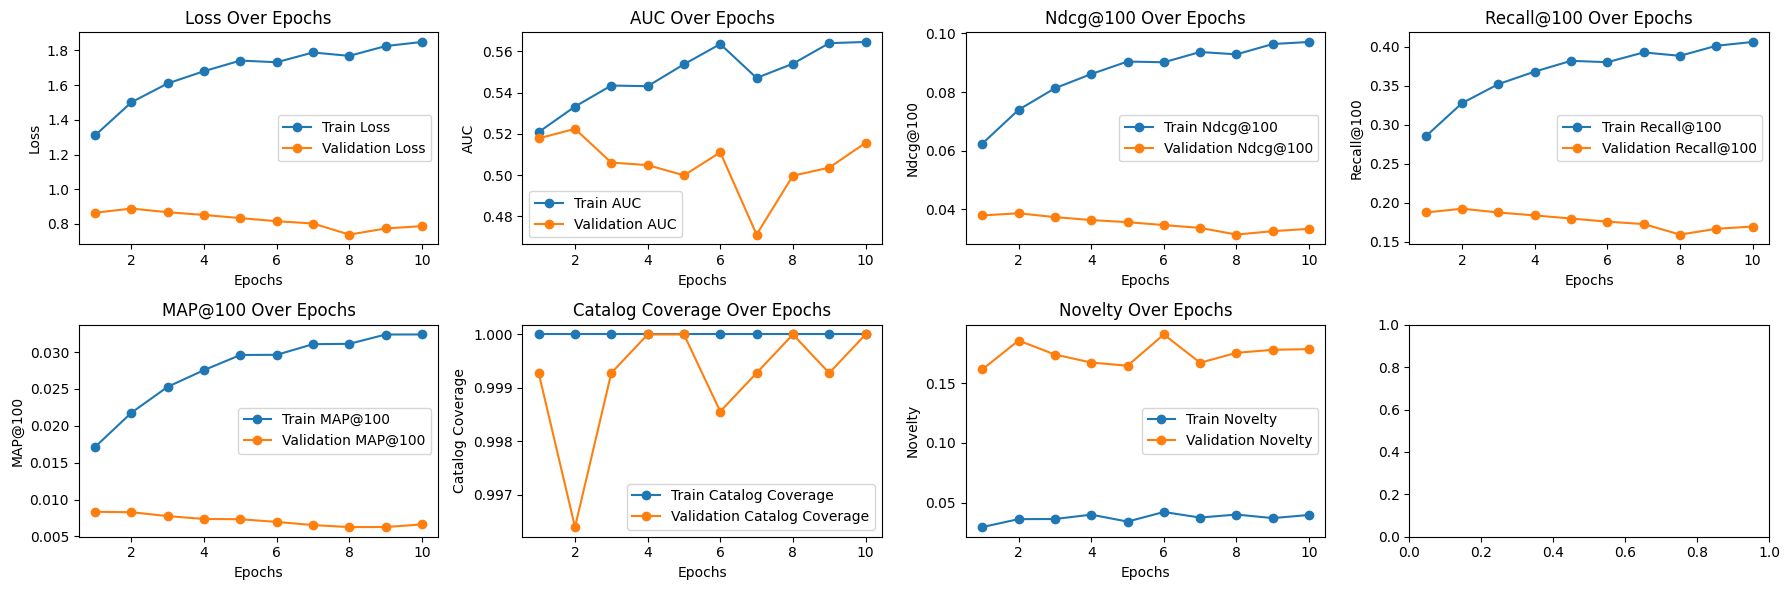

In [203]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


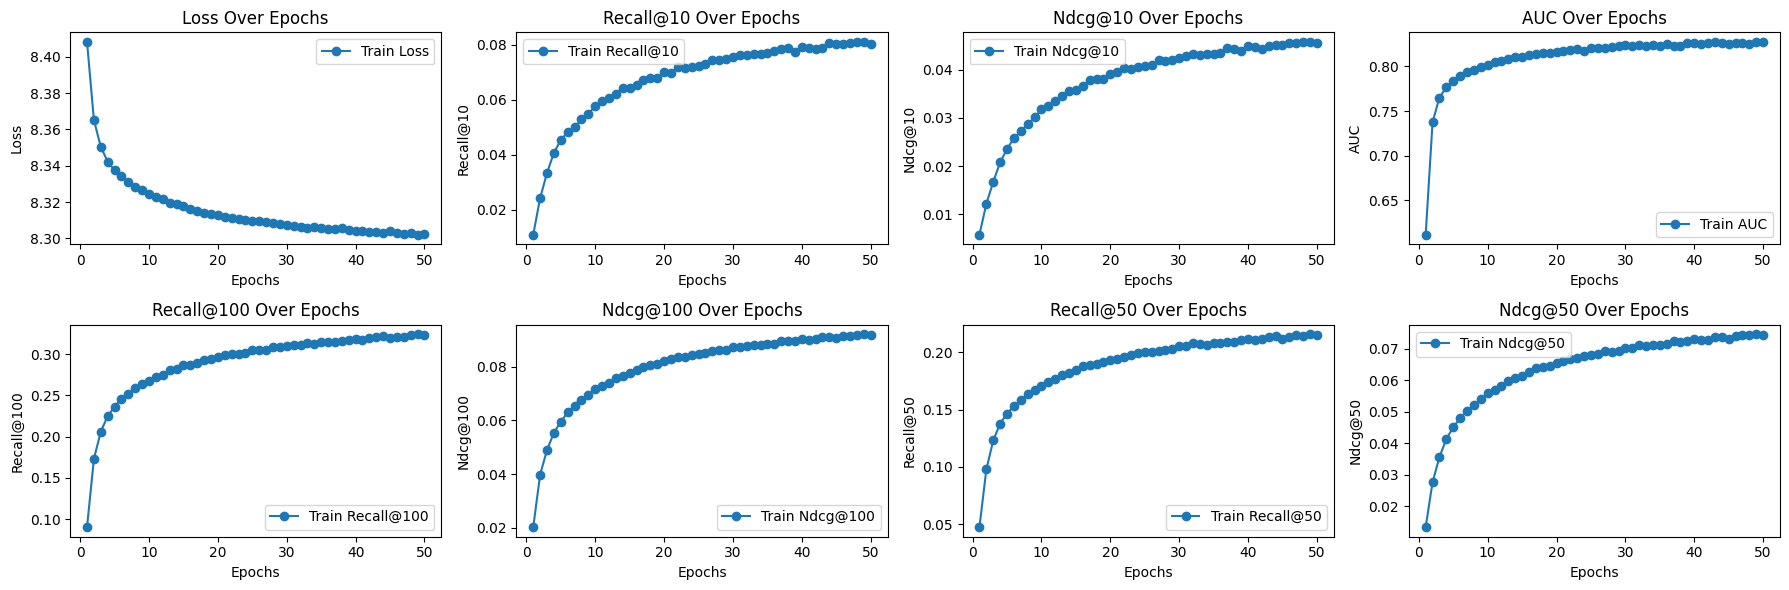

In [204]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [ ]:
# (model.evaluate(train, batch_size=2048, return_dict=True),
#  model.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model, train, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


69/69 [==============================] - 4s 20ms/step - loss: 1.8865 - auc_21: 0.4858 - recall_at_100: 0.3987 - mrr_at_100: 0.0316 - ndcg_at_100: 0.0950 - map_at_100: 0.0316 - precision_at_100: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 1.9057
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 1.8864508867263794,
 'auc_21': 0.4857785701751709,
 'recall_at_100': 0.3994045853614807,
 'mrr_at_100': 0.03349835425615311,
 'ndcg_at_100': 0.09687190502882004,
 'map_at_100': 0.03349835425615311,
 'precision_at_100': 0.003994045313447714,
 'regularization_loss': 0.0,
 'loss_batch': 2.818242073059082,
 'coverage': 1.0,
 'novelty': 0.04531693017444375}

In [ ]:
evaluate_model(model, valid, topk=100)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 4s 33ms/step - loss: 0.9953 - auc_22: 0.4727 - recall_at_100: 0.1899 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0358 - map_at_100: 0.0059 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 1.0450
Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'loss': 0.9952747225761414,
 'auc_22': 0.4727213978767395,
 'recall_at_100': 0.19292497634887695,
 'mrr_at_100': 0.006211184896528721,
 'ndcg_at_100': 0.0365414135158062,
 'map_at_100': 0.006211184896528721,
 'precision_at_100': 0.0019292497308924794,
 'regularization_loss': 0.0,
 'loss_batch': 1.5650469064712524,
 'coverage': 1.0,
 'novelty': 0.18732618196265396}

### model_v10

In [ ]:
_tower_dim = (128, 256) # @param
_learning_rate = 0.02 # @param
_batch_size = 256 # @param
_epochs = 15 # @param
_validation_batch_size = 256 # @param


#### model

In [ ]:
model_v10 = build_towers(tower_dim=_tower_dim)
TOP_K = [10]
model_v10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K), tf.keras.metrics.AUC()],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
history_v10 = []

In [ ]:
history_v10.append(model_v10.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs, validation_batch_size=_validation_batch_size))

In [ ]:
history_v10.append(model_v10.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs, validation_batch_size=_validation_batch_size))

#### result

In [ ]:
_history = merge_model_history(*history_v10)
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc_4'})

In [ ]:
_history = merge_model_history(*history_v10)
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc_2'})

## Evaluate the Model top-k results

### exp1

In [26]:
train_df = train.to_ddf().compute()

In [36]:
from merlin.models.tf import PopularityBasedSamplerV2
from merlin.models.tf.outputs.base import DotProduct, ModelOutput
from merlin.models.tf.outputs.contrastive import ContrastiveOutput
from merlin.models.tf.core.combinators import ParallelBlock, SequentialBlock


In [88]:
candidate_id_tag=Tags.ITEM_ID
model = model_v6


outputs = ContrastiveOutput(
            to_call=DotProduct(),
            negative_samplers=sampler,
            logits_temperature=1.0,
            schema=model.candidate_encoder._schema.select_by_tag(candidate_id_tag),
        )

In [92]:
# https://github.com/NVIDIA-Merlin/models/blob/stable/merlin/models/tf/models/base.py#L2328C23-L2328C29
output = outputs
query_name = output.query_name
candidate_name = output.candidate_name

if query and candidate:
            encoder = ParallelBlock({query_name: query, candidate_name: candidate})
else:
    encoder = query

IndentationError: ignored

In [96]:
model.built

True

In [79]:
sampler.sample()

Candidate([[   1]
 [  27]
 [1245]
 [  23]
 [  14]
 [  85]
 [ 345]
 [  10]
 [   6]
 [  25]
 [  46]
 [ 482]
 [  15]
 [  21]
 [ 213]
 [   3]
 [ 136]
 [ 467]
 [   5]
 [   2]], None, {})

### Sampling Definitons

#### InBatchSamplerV2

In [19]:
#
# Copyright (c) 2021, NVIDIA CORPORATION.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
from typing import Optional

import tensorflow as tf

from merlin.models.tf.outputs.sampling.base import Candidate, CandidateSampler


# @CandidateSampler.registry.register("in-batch")
# @tf.keras.utils.register_keras_serializable(package="merlin.models")
class InBatchSamplerV2(CandidateSampler):
    """Provides in-batch sampling [1]_ for two-tower item retrieval
    models. The implementation is very simple, as it
    just returns the current item embeddings and metadata, but it is necessary to have
    `InBatchSampler` under the same interface of other more advanced samplers
    (e.g. `CachedCrossBatchSampler`).
    In a nutshell, for a given (user,item) embeddings pair, the other in-batch item
    embeddings are used as negative items, rather than computing different embeddings
    exclusively for negative items.
    This is a popularity-biased sampling     as popular items are observed more often
    in training batches.
    P.s. Ignoring the false negatives (negative items equal to the positive ones) is
    managed by `ItemRetrievalScorer(..., sampling_downscore_false_negatives=True)`
    References
    ----------
    .. [1] Yi, Xinyang, et al. "Sampling-bias-corrected neural modeling for large corpus item
       recommendations." Proceedings of the 13th ACM Conference on Recommender Systems. 2019.
    Parameters
    ----------
    batch_size : int, optional
        The batch size. If not set it is inferred when the layer is built (first call())
    """

    def __init__(self, batch_size: Optional[int] = None, **kwargs):
        super().__init__(max_num_samples=batch_size, **kwargs)
        self._last_batch: Optional[Candidate] = None  # type: ignore
        self.set_batch_size(batch_size)

    @property
    def batch_size(self) -> int:
        return self._batch_size

    def set_batch_size(self, value):
        self._batch_size = value
        if value is not None:
            self.set_max_num_samples(value)

    def build(self, items: Candidate) -> None:
        if isinstance(items, dict):
            items = Candidate.from_config(items)
        if self._batch_size is None:
            if isinstance(items, Candidate):
                self.set_batch_size(items.id[0])
            else:
                self.set_batch_size(items[0])

    def add(self, items: Candidate):
        self._last_batch = items

    def call(
        self, items: Candidate, features=None, targets=None, training=False, testing=False
    ) -> Candidate:
        """Returns the item embeddings and item ids from
        the current batch.

        Parameters
        ----------
        items : Items
            The items ids and their embeddings from the current batch
        features : optional
            The metadata with raw input features, by default None
        targets : _type_, optional
            The tensor of targets, by default None
        training : bool, optional
            Flag indicating if on training mode, by default False
        testing : bool, optional
             Flag indicating if on evaluation mode, by default False

        Returns
        -------
        Items
            NamedTuple with the sampled item ids and item metadata
        """
        self.add(items)
        items = self.sample()

        return items

    def sample(self) -> Candidate:
        return self._last_batch

    def get_config(self):
        config = super().get_config()
        config["batch_size"] = self._batch_size

        # TODO: This is a side-effect, could this lead to problems?
        self._last_batch = None

        return config

#### PopularityBasedSamplerV2

In [20]:
#
# Copyright (c) 2021, NVIDIA CORPORATION.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
from typing import Optional

import tensorflow as tf

from merlin.models.tf.outputs.sampling.base import Candidate, CandidateSampler


# @tf.keras.utils.register_keras_serializable(package="merlin.models")
class PopularityBasedSamplerV2(CandidateSampler):
    """
    Provides a popularity-based negative sampling for sampled softmax [1]_ [2]_.
    to ensure training efficiency when the catalog of items is very large.
    Items are sampled from the whole catalog. It also allows saving
    the sampling probabilities for both positive and negative candidates,
    that are required by the logQ sampling correction of sampled softmax.
    This class do not require the actual frequency of items. It assumes that
    item ids are sorted by frequency and follow a long tail distribution and
    uses tf.random.log_uniform_candidate_sampler() for sampling the candidate ids.

    References
    ----------
    .. [1] Yoshua Bengio and Jean-Sébastien Sénécal. 2003. Quick Training of Probabilistic
       Neural Nets by Importance Sampling. In Proceedings of the conference on Artificial
       Intelligence and Statistics (AISTATS).

    .. [2] Y. Bengio and J. S. Senecal. 2008. Adaptive Importance Sampling to Accelerate
       Training of a Neural Probabilistic Language Model. Trans. Neur. Netw. 19, 4 (April
       2008), 713–722. https://doi.org/10.1109/TNN.2007.912312


    Parameters
    ----------
    max_id: int
        The maximum id value to be sampled. It should be equal to the
        categorical feature cardinality
    min_id: int
        The minimum id value to be sampled. Useful to ignore the first categorical
        encoded ids, which are usually reserved for <nulls>, out-of-vocabulary or padding.
        Defaults to 0.
    max_num_samples: int
        The number of unique negatives to sample at each batch.
    unique: True
        Whether to return unique candidate ids or allow for repeated ones
    seed: int
        Fix the random values returned by the sampler to ensure reproducibility
        Defaults to None
    """

    def __init__(
        self,
        max_id: int,
        min_id: int = 0,
        max_num_samples: int = 10,
        unique: Optional[bool] = True,
        seed: Optional[int] = None,
        **kwargs,
    ):
        super().__init__(max_num_samples=max_num_samples, **kwargs)
        self.max_id = max_id
        self.min_id = min_id
        self.seed = seed
        self.unique = unique

        self.sampling_dist = self.get_sampling_distribution()

        assert (
            self.max_num_samples <= self.max_id
        ), f"Number of items to sample `{self.max_num_samples}`"
        f"should be less than total number of ids `{self.max_id}`"

    def add(self, items: Candidate):
        pass

    def call(
        self,
        positive_items: Candidate = None,
        features=None,
        targets=None,
        training=False,
        testing=False,
    ) -> Candidate:
        return self.sample()

    def sample(self) -> Candidate:
        """
        Method to sample `max_num_samples` unique negatives.
        This implementation does not require the actual item frequencies/probabilities
        distribution, but instead tries to approximate the item
        probabilities using the log_uniform (zipfisan) distribution.
        The only requirement is that the item ids are decreasingly sorted by their count frequency.
        We use the default log-uniform (zipfian) sampler given by Tensorflow:
        [log_uniform_candidate_sampler](https://www.tensorflow.org/api_docs/python/tf/random/log_uniform_candidate_sampler)
        We note that the `Categorify` op provided by nvtabular supports
        the frequency-based encoding as default.

        Returns
        -------
        Items
            The negative items ids
        """
        (
            sampled_ids,
            _,
            _,
        ) = tf.random.log_uniform_candidate_sampler(
            # This is just a placeholder for true_classestrue classes.
            # It should be provided the positive ids here if wanted to
            # get the expected count probs returned.
            # We rather make usage of CandidateSampler.with_sampling_probs()
            # method to get the sampling probs from positives and negatives
            true_classes=tf.ones((1, 1), dtype=tf.int64),
            num_true=1,
            num_sampled=self.max_num_samples,
            unique=self.unique,
            range_max=self.max_id - self.min_id,
            seed=self.seed,
        )
        # Shifting the sampled ids to ignore the first ids (usually reserved for nulls, OOV)
        sampled_ids += self.min_id
        sampled_ids = tf.expand_dims(sampled_ids, -1)

        sampled_ids = tf.stop_gradient(sampled_ids)
        print('PopularityBasedSamplerV2 generated samples:', sampled_ids.shape)

        return Candidate(id=sampled_ids, metadata={})

    def get_sampling_distribution(self) -> tf.Tensor:
        """Returns the approximated distribution used to sample items
        by using tf.random.log_uniform_candidate_sampler()

        Returns
        -------
        tf.Tensor
            Probabilities of each item to be sampled
        """
        log_indices = tf.math.log(tf.range(1.0, self.max_id - self.min_id + 3.0, 1.0))
        sampling_probs = (log_indices[1:] - log_indices[:-1]) / log_indices[-1]

        if self.unique:
            # Below is a more numerically stable implementation of the probability of
            # sampling an item at least once (suitable for sampling unique items)
            # P(item is sampled at least once) = 1 - P(item is not sampled)^num_trials
            # where P(item is not sampled) = 1-p and p is the
            # probability to be sampled
            sampling_probs = -tf.math.expm1(self.max_num_samples * tf.math.log1p(-sampling_probs))

        # Shifting probs if first values of item id mapping table are reserved
        if self.min_id > 0:
            sampling_probs = tf.concat(
                [tf.zeros([self.min_id], dtype=sampling_probs.dtype), sampling_probs], axis=0
            )

        sampling_probs = tf.stop_gradient(sampling_probs)

        return sampling_probs

    def with_sampling_probs(self, items: Candidate) -> Candidate:
        """Returns a copy of the Candidate named tuple with
        the sampling_probs set,

        Parameters
        ----------
        items : Candidate
            Positive or negative candidate items

        Returns
        -------
        Candidate
            Candidate items with sampling probability set
        """
        sampling_probs = tf.gather(self.sampling_dist, items.id)
        items_with_sampling_prob = items.with_sampling_prob(sampling_probs)
        return items_with_sampling_prob

    def get_config(self):
        config = super().get_config()
        config["max_id"] = self.max_id
        config["min_id"] = self.min_id
        config["max_num_samples"] = self.max_num_samples
        config["seed"] = self.seed
        return config

#### ContrastiveOutput

In [30]:
def rescore_false_negatives(
    positive_item_ids: tf.Tensor,
    neg_samples_item_ids: tf.Tensor,
    negative_scores: tf.Tensor,
    false_negatives_score: float,
):
    """
    Zeroes the logits of accidental negatives.
    """
    # Removing dimensions of size 1 from the shape of the item ids, if applicable
    positive_item_ids = tf.cast(tf.squeeze(positive_item_ids), neg_samples_item_ids.dtype)
    neg_samples_item_ids = tf.squeeze(neg_samples_item_ids)

    # Reshapes positive and negative ids so that false_negatives_mask matches the scores shape
    false_negatives_mask = tf.equal(
        tf.expand_dims(positive_item_ids, -1), tf.expand_dims(neg_samples_item_ids, 0)
    )

    # Setting a very small value for false negatives (accidental hits) so that it has
    # negligicle effect on the loss functions
    #hack ####################################
    # ipdb.set_trace(context=6)
    ##########################################
    negative_scores = tf.where(
        false_negatives_mask,
        tf.ones_like(negative_scores) * false_negatives_score,
        negative_scores,
    )

    valid_negatives_mask = tf.logical_not(false_negatives_mask)

    return tf.squeeze(negative_scores), valid_negatives_mask

In [55]:
#
# Copyright (c) 2021, NVIDIA CORPORATION.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
import logging
import warnings
from typing import List, Optional, Protocol, Tuple, Union, runtime_checkable

import tensorflow as tf
from tensorflow.keras.layers import Layer

import merlin.io
from merlin.models.tf.core.prediction import Prediction
from merlin.models.tf.inputs.embedding import EmbeddingTable
from merlin.models.tf.outputs.base import DotProduct, MetricsFn, ModelOutput
from merlin.models.tf.outputs.classification import (
    CategoricalTarget,
    EmbeddingTablePrediction,
    default_categorical_prediction_metrics,
)
from merlin.models.tf.outputs.sampling.base import (
    Candidate,
    ItemSamplersType,
    parse_negative_samplers,
)
from merlin.models.tf.typing import TabularData
from merlin.models.tf.utils import tf_utils
from merlin.models.utils import schema_utils
from merlin.models.utils.constants import MIN_FLOAT
from merlin.schema import ColumnSchema, Schema

LOG = logging.getLogger("merlin_models")


# @tf.keras.utils.register_keras_serializable(package="merlin.models")
class ContrastiveOutputV2(ModelOutput):
    """Categorical output

    Parameters
    ----------
    to_call: Union[Schema, ColumnSchema,
                EmbeddingTable, 'CategoricalTarget',
                'EmbeddingTablePrediction', 'DotProduct']
        The target feature to predict. To perform weight-tying [1] technique, you should provide
        the `EmbeddingTable` or `EmbeddingTablePrediction` related to the
        target feature.
    negative_samplers: ItemSamplersType
        List of samplers for negative sampling,
        by default None
    pre: Optional[Block], optional
        Optional block to transform predictions before computing the binary logits,
        by default None
    post: Optional[Block], optional
        Optional block to transform the binary logits,
        by default None
    logits_temperature: float, optional
        Parameter used to reduce model overconfidence, so that logits / T.
        by default 1
    name: str, optional
        The name of the task, by default None
    default_loss: Union[str, tf.keras.losses.Loss], optional
        Default loss to use for categorical-classification
        by default 'categorical_crossentropy'
    get_default_metrics: Callable, optional
        A function returning the list of default metrics
        to use for categorical-classification
    store_negative_ids: bool, optional
        Whether to store negative ids for post-processing
        by default False
    logq_sampling_correction: bool, optional
        The LogQ correction is a standard technique for
        sampled softmax and popularity-biased sampling.
        It subtracts from the logits the
        log expected count/prob of the positive and
        negative samples in order to not overpenalize the
        popular items for being sampled more often as negatives.
        It can be enabled if a single negative sampler is provided
        and if it provides the sampler provides the
        sampling probabilities (i.e. implements with_sampling_probs()).
        Another alternative for performing logQ correction is using
        ContrastiveOutput(..., post=PopularityLogitsCorrection(item_frequencies)),
        where you need to provide the items frequency probability distribution (prior).
        Default is False.

    References:
    ----------
    [1] Hakan Inan, Khashayar Khosravi, and Richard Socher. 2016. Tying word vectors
    and word classifiers: A loss framework for language modeling. arXiv preprint
    arXiv:1611.01462 (2016).

    Notes:
    ----------
    In case `to_call` is set as `DotProduct()`, schema of target couldn't be inferred
    therefore, the user should feed a schema only with ITEM_ID feature as schema arg,
    which is treated as a `kwargs` arg below.

    Example usage::
        outputs=mm.ContrastiveOutput(
            to_call=DotProduct(),
            negative_samplers="in-batch",
            schema=schema.select_by_tag(Tags.ITEM_ID),
            logits_temperature = 0.2,
        )

    The schema arg is not needed when we pass the schema to `to_call` arg.

    Example usage::
        outputs=mm.ContrastiveOutput(
            to_call=schema.select_by_tag(Tags.ITEM_ID),
            negative_samplers="in-batch",
            logits_temperature = 0.2,
        )

    """

    def __init__(
        self,
        to_call: Union[
            Schema,
            ColumnSchema,
            EmbeddingTable,
            CategoricalTarget,
            EmbeddingTablePrediction,
            DotProduct,
        ],
        negative_samplers: ItemSamplersType,
        target_name: str = None,
        pre: Optional[Layer] = None,
        post: Optional[Layer] = None,
        logits_temperature: float = 1.0,
        name: Optional[str] = None,
        default_loss: Union[str, tf.keras.losses.Loss] = "categorical_crossentropy",
        default_metrics_fn: MetricsFn = default_categorical_prediction_metrics,
        downscore_false_negatives=True,
        false_negative_score: float = MIN_FLOAT,
        query_name: str = "query",
        candidate_name: str = "candidate",
        store_negative_ids: bool = False,
        logq_sampling_correction: Optional[bool] = False,
        **kwargs,
    ):
        self.col_schema = None
        _to_call = None
        if to_call is not None:
            if isinstance(to_call, (Schema, ColumnSchema)):
                if isinstance(to_call, Schema):
                    if len(to_call) == 1:
                        to_call = to_call.first
                    else:
                        raise ValueError("to_call must be a single column schema")

                self.col_schema = to_call
                _to_call = CategoricalTarget(to_call)
                target_name = target_name or to_call.name
            elif isinstance(to_call, EmbeddingTable):
                _to_call = EmbeddingTablePrediction(to_call)
                target_name = _to_call.table.col_schema.name
                self.col_schema = _to_call.table.col_schema
            else:
                _to_call = to_call

        if "schema" in kwargs:
            self.col_schema = kwargs.pop("schema").first

        if not self.col_schema:
            raise ValueError(
                "schema of target couldn't be inferred, please provide ", "`schema=...`"
            )

        self.negative_samplers = parse_negative_samplers(negative_samplers)
        self.downscore_false_negatives = downscore_false_negatives
        self.false_negative_score = false_negative_score
        self.query_name = query_name
        self.candidate_name = candidate_name
        self.store_negative_ids = store_negative_ids
        self.logq_sampling_correction = logq_sampling_correction

        self.target_name = kwargs.pop("target", target_name)
        super().__init__(
            to_call=_to_call,
            default_loss=default_loss,
            default_metrics_fn=default_metrics_fn,
            name=name,
            target=self.target_name,
            pre=pre,
            post=post,
            logits_temperature=logits_temperature,
            **kwargs,
        )

    def build(self, input_shape):
        if (
            isinstance(input_shape, dict)
            and all(key in input_shape for key in self.keys)
            and not isinstance(self.to_call, DotProduct)
        ):
            self.to_call = DotProduct(*self.keys)

        super().build(input_shape)

    def call(self, inputs, features=None, targets=None, training=False, testing=False):
        call_kwargs = dict(features=features, targets=targets, training=training, testing=testing)

        if training or testing:
            if self.has_candidate_weights and targets is None:
                return tf_utils.call_layer(self.to_call, inputs, **call_kwargs)

            return self.call_contrastive(inputs, **call_kwargs)

        return tf_utils.call_layer(self.to_call, inputs, **call_kwargs)

    def call_contrastive(self, inputs, features, targets, training=False, testing=False):
        if isinstance(inputs, dict) and self.query_name in inputs:
            query_embedding = inputs[self.query_name]
        elif isinstance(inputs, (tf.Tensor, tf.RaggedTensor)):
            query_embedding = inputs
        else:
            raise ValueError("Couldn't infer query embedding")

        is_ragged = isinstance(query_embedding, tf.RaggedTensor)
        if is_ragged:
            # Get flat values of the ragged tensor
            original_query_embedding = query_embedding
            query_embedding = query_embedding.flat_values

        if self.has_candidate_weights:
            positive_id = targets
            if isinstance(targets, dict):
                positive_id = targets[self.col_schema.name]
            positive_embedding = self.embedding_lookup(positive_id)
        else:
            positive_id = features[self.col_schema.name]
            positive_embedding = inputs[self.candidate_name]

        if isinstance(positive_id, tf.RaggedTensor):
            # Select positive candidates at masked positions
            target_mask = positive_id._keras_mask.with_row_splits_dtype(
                positive_id.row_splits.dtype
            )
            # Flatten target tensor to have the same shape as the query tensor
            positive_id = tf.ragged.boolean_mask(positive_id, target_mask)
            original_target = positive_id
            positive_id = positive_id.flat_values
            positive_embedding = tf.ragged.boolean_mask(positive_embedding, target_mask).flat_values

        positive = Candidate(id=positive_id, metadata={**features}).with_embedding(
            positive_embedding
        )
        negative, positive = self.sample_negatives(
            positive, features, training=training, testing=testing
        )
        #hack ##########################
        negative.id._shape_val =  tf.TensorShape([None, 1])
        negative = Candidate(negative.id, positive.metadata)
        # negative_config = negative.get_config() | {'metadata': positive.metadata}
        # negative = negative.from_config({'config': negative_config})
        # print(self.has_candidate_weights, positive.id.shape != negative.id.shape, positive != negative)
        # ipdb.set_trace(context=6)

        ############################
        if self.has_candidate_weights and (
            positive.id.shape != negative.id.shape or positive != negative
        ):
            negative = negative.with_embedding(self.embedding_lookup(negative.id))

        logits = self.outputs(query_embedding, positive, negative)
        if is_ragged:
            logits.copy_with_updates(
                outputs=original_query_embedding.with_flat_values(logits.outputs),
                targets=original_target.with_flat_values(logits.targets),
            )
        return logits

    def outputs(
        self, query_embedding: tf.Tensor, positive: Candidate, negative: Candidate
    ) -> Prediction:
        """Method to compute the dot product between the query embeddings and
        positive/negative candidates

        Parameters
        ----------
        query_embedding : tf.Tensor
            tensor of query embeddings.
        positive : Candidate
            Store the ids and metadata (such as embeddings) of the positive candidates.
        negative : Candidate
            Store the ids and metadata (such as embeddings) of the sampled negative candidates.

        Returns
        -------
        Prediction
            a Prediction object with the prediction scores, the targets and
            the negative candidates ids if specified.
        """
        if not positive.has_embedding:
            raise ValueError("Positive candidate must have an embedding")
        if not negative.has_embedding:
            raise ValueError("Negative candidate must have an embedding")

        # Apply dot-product
        negative_scores = tf.linalg.matmul(query_embedding, negative.embedding, transpose_b=True)

        positive_scores = tf.reduce_sum(
            tf.multiply(query_embedding, positive.embedding), keepdims=True, axis=-1
        )

        if self.logq_sampling_correction:
            if positive.sampling_prob is None or negative.sampling_prob is None:
                warnings.warn(
                    "The logQ sampling correction is enabled, but sampling probs were not found "
                    "for both positive and negative candidates",
                    RuntimeWarning,
                )

            epsilon = 1e-16
            positive_scores -= tf.math.log(positive.sampling_prob + epsilon)
            negative_scores -= tf.math.log(tf.transpose(negative.sampling_prob + epsilon))

        # hack###############
        rescore_false_negatives = tf_utils.rescore_false_negatives
        # global rescore_false_negatives
        # rescore_false_negatives = rescore_false_negatives
        # ipdb.set_trace(context=3)
        ####################
        if self.downscore_false_negatives:
            negative_scores, _ = rescore_false_negatives(
                positive.id, negative.id, negative_scores, self.false_negative_score
            )

        outputs = tf.concat([positive_scores, negative_scores], axis=-1)

        # To ensure that the output is always fp32, avoiding numerical
        # instabilities with mixed_float16 policy
        outputs = tf.cast(outputs, tf.float32)

        targets = tf.concat(
            [
                tf.ones([tf.shape(outputs)[0], 1], dtype=outputs.dtype),
                tf.zeros(
                    [tf.shape(outputs)[0], tf.shape(outputs)[1] - 1],
                    dtype=outputs.dtype,
                ),
            ],
            axis=1,
        )
        if self.store_negative_ids:
            return Prediction(outputs, targets, negative_candidate_ids=negative.id)
        return Prediction(outputs, targets)

    def sample_negatives(
        self,
        positive: Candidate,
        features: TabularData,
        training=False,
        testing=False,
    ) -> Tuple[Candidate, Candidate]:
        """Method to sample negatives from `self.negative_samplers`

        Parameters
        ----------
        positive_items : Items
            Positive items (ids and metadata)
        features : TabularData
            Dictionary of input raw tensors
        training : bool, optional
            Flag for train mode, by default False
        testing : bool, optional
            Flag for test mode, by default False

        Returns
        -------
        Tuple[Candidate, Candidate]
            Tuple of candidates with sampled negative ids and the provided positive ids
            added with the sampling probability
        """
        sampling_kwargs = {"training": training, "testing": testing, "features": features}
        candidates: List[Candidate] = []

        if self.logq_sampling_correction and len(self.negative_samplers) > 1:
            raise ValueError(
                "It is only possible to apply logQ sampling correction "
                "(logq_sampling_correction=True) when only one negative sampler is provided."
            )

        for sampler in self.negative_samplers:
            neg_samples: Candidate = tf_utils.call_layer(sampler, positive, **sampling_kwargs)

            # Adds to the positive and negative candidates their sampling probs from the sampler
            positive = sampler.with_sampling_probs(positive)
            neg_samples = sampler.with_sampling_probs(neg_samples)

            if neg_samples.id is not None:
                candidates.append(neg_samples)
            else:
                LOG.warn(
                    f"The sampler {type(sampler).__name__} returned no samples for this batch."
                )

        if len(candidates) == 0:
            raise Exception(
                f"No negative items where sampled from samplers {self.negative_samplers}"
            )

        negatives = candidates[0]
        if len(candidates) > 1:
            for neg in candidates[1:]:
                negatives += neg

        return negatives, positive

    def embedding_lookup(self, ids: tf.Tensor):
        return self.to_call.embedding_lookup(tf.squeeze(ids, axis=-1))

    def to_dataset(self, gpu=None) -> merlin.io.Dataset:
        return merlin.io.Dataset(tf_utils.tensor_to_df(self.to_call.embeddings, gpu=gpu))

    @property
    def has_candidate_weights(self) -> bool:
        if isinstance(self.to_call, DotProduct):
            return False

        return isinstance(self.to_call, LookUpProtocol)

    @property
    def keys(self) -> List[str]:
        return [self.query_name, self.candidate_name]

    def set_negative_samplers(self, negative_samplers: ItemSamplersType):
        if negative_samplers is not None:
            negative_samplers = parse_negative_samplers(negative_samplers)
        self.negative_samplers = negative_samplers

    def get_config(self):
        config = super().get_config()

        config = tf_utils.maybe_serialize_keras_objects(self, config, ["negative_samplers"])

        config["target"] = self.target_name
        config["downscore_false_negatives"] = self.downscore_false_negatives
        config["false_negative_score"] = self.false_negative_score
        config["query_name"] = self.query_name
        config["candidate_name"] = self.candidate_name
        config["store_negative_ids"] = self.store_negative_ids

        config["schema"] = schema_utils.schema_to_tensorflow_metadata_json(
            Schema([self.col_schema])
        )

        return config

    @classmethod
    def from_config(cls, config):
        config["schema"] = schema_utils.tensorflow_metadata_json_to_schema(config["schema"])

        config = tf_utils.maybe_deserialize_keras_objects(config, ["negative_samplers"])

        return super().from_config(config)


@runtime_checkable
class LookUpProtocol(Protocol):
    """Protocol for embedding lookup layers"""

    @property
    def embeddings(self):
        pass

    def embedding_lookup(self, inputs, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        pass

#### TwoTowerModelV3

In [30]:
from merlin.models.tf.core.encoder import EmbeddingEncoder, Encoder
from merlin.models.tf.models.base import Model, RetrievalModel, RetrievalModelV2
from merlin.models.tf.outputs.base import DotProduct, MetricsFn, ModelOutput
from merlin.models.tf.outputs.classification import BinaryOutput
from merlin.models.tf.outputs.contrastive import ContrastiveOutput




def TwoTowerModelV3(
    query_tower,
    candidate_tower,
    candidate_id_tag=Tags.ITEM_ID,
    outputs= None,
    logits_temperature: float = 1.0,
    negative_samplers = None,
    schema: Schema = None,
    **kwargs,
):
    """Builds the Two-tower architecture, as proposed in [1].

    Example Usage::
        query = mm.Encoder(user_schema, mm.MLPBlock([128]))
        candidate = mm.Encoder(item_schema, mm.MLPBlock([128]))
        model = TwoTowerModel(query, candidate)
        two_tower.compile(optimizer="adam")
        two_tower.fit(train_data, epochs=10)

    References
    ----------
    [1] Yi, Xinyang, et al.
        "Sampling-bias-corrected neural modeling for large corpus item recommendations."
        Proceedings of the 13th ACM Conference on Recommender Systems. 2019.

    Parameters
    ----------
    query_tower: Encoder
        The layer that encodes query features
    candidate_tower: Encoder
        The  layer that encodes candidates features
    candidate_id_tag: Tag, optional
        The tag to select candidate-id feature, by default `Tags.ITEM_ID`
    outputs:  Union[ModelOutput, List[ModelOutput]], optional
        The optional `ModelOutput` or list of `ModelOutput` to apply on the model.
    logits_temperature: float
        Parameter used to reduce model overconfidence, so that logits / T.
        Defaults to 1.
    negative_samplers: List[ItemSampler]
        List of samplers for negative sampling, by default None
        If the `outputs` and `negative_samplers` are not specified the two tower model
        is trained with contrastive learning and `in-batch` negative sampling strategy.
    schema: Schema
        A schema with all input features fed to the two-tower model.

    Returns
    -------
    RetrievalModelV2
    """
    assert isinstance(query_tower, Encoder), ValueError(
        "The query tower should be an instance of `Encoder` class"
    )
    assert isinstance(candidate_tower, Encoder), ValueError(
        "The query tower should be an instance of `Encoder` class"
    )

    if not outputs:
        if not negative_samplers:
            negative_samplers = ["in-batch"]
        outputs = ContrastiveOutput(
            to_call=DotProduct(),
            negative_samplers=negative_samplers,
            logits_temperature=logits_temperature,
            schema=candidate_tower._schema.select_by_tag(candidate_id_tag),
            downscore_false_negatives = False,
            **kwargs,
        )

    if isinstance(outputs, list):
        outputs = ParallelBlock(*outputs)

    model = RetrievalModelV2(
        query=query_tower,
        candidate=candidate_tower,
        output=outputs,
        schema=schema,
    )

    return model


In [38]:
def build_towersV2(schema=schema, tower_dim = (128, 64), neg_sampler=['in-batch'], max_num_samples=1028):
    if not neg_sampler:
        neg_sampler = ['in-batch']
    # create user schema using USER tag
    user_schema = schema.select_by_tag(Tags.USER)
    # create user (query) tower input block
    user_inputs = mm.InputBlockV2(user_schema)
    # create user (query) encoder block
    query = mm.Encoder(user_inputs, mm.MLPBlock(tower_dim, no_activation_last_layer=True))

    # create item schema using ITEM tag
    item_schema = schema.select_by_tag(Tags.ITEM)
    # create item (candidate) tower input block
    item_inputs = mm.InputBlockV2(item_schema)
    # create item (candidate) encoder block
    candidate = mm.Encoder(item_inputs, mm.MLPBlock(tower_dim, no_activation_last_layer=True))

    from merlin.models.utils.schema_utils import categorical_cardinalities
    _candidate = schema.select_by_tag(Tags.ITEM_ID)

    max_id = categorical_cardinalities(_candidate)[_candidate.column_names[0]]
    min_sampled_id = 1

    _candidate = _candidate.first
    candidate_table = candidate.first["categorical"][_candidate.name]

    outputs = ContrastiveOutput(
            to_call=candidate_table,
            logits_temperature=1,
            # post=post,
            negative_samplers=PopularityBasedSamplerV2(
                max_num_samples=max_num_samples,
                max_id=max_id - 1, min_id=min_sampled_id
            ),
            logq_sampling_correction=True,
        )

    return TwoTowerModelV3(query, candidate,
                            #   negative_samplers=neg_sampler,
                            outputs=outputs
                              )


In [35]:
# create item schema using ITEM tag
item_schema = schema.select_by_tag(Tags.ITEM)
# create item (candidate) tower input block
item_inputs = mm.InputBlockV2(item_schema)
# create item (candidate) encoder block
candidate = mm.Encoder(item_inputs, mm.MLPBlock([64, 64], no_activation_last_layer=True))

In [36]:
from merlin.models.utils.schema_utils import categorical_cardinalities
_candidate = schema.select_by_tag(Tags.ITEM_ID)

max_id = categorical_cardinalities(_candidate)[_candidate.column_names[0]]
min_sampled_id = 1

_candidate = _candidate.first
candidate_table = candidate.first["categorical"][_candidate.name]


In [37]:
candidate_table

EmbeddingTable(
  (features): Dict(
    (movie_id): ColumnSchema(name='movie_id', tags={<Tags.ITEM: 'item'>, <Tags.ID: 'id'>, <Tags.CATEGORICAL: 'categorical'>}, properties={'embedding_sizes': {'cardinality': 1665.0, 'dimension': 102.0}, 'cat_path': './/categories/unique.movie_id.parquet', 'num_buckets': None, 'start_index': 0.0, 'freq_threshold': 0.0, 'max_size': 0.0, 'domain': {'min': 0, 'max': 1664, 'name': 'movie_id'}}, dtype=DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), is_list=False, is_ragged=False)
  )
  (table): Embedding()
)

### exp sampling

In [ ]:
# outputs = ContrastiveOutput(
#             to_call=candidate_table,
#             logits_temperature=logits_temperature,
#             post=post,
#             negative_samplers=PopularityBasedSamplerV2(
#                 max_num_samples=num_sampled, max_id=num_classes - 1, min_id=min_sampled_id
#             ),
#             logq_sampling_correction=True,
#         )

In [33]:
# model_v6 = mm.YoutubeDNNRetrievalModelV2(schema, top_block=mm.MLPBlock([16]), num_sampled=100, min_sampled_id=1)
# TOP_K = [100, 10]

# model_v6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
#                  run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
#                                              mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
#                                             ],
#                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# )
# history_v6 = []

In [39]:
# sampler = [PopularityBasedSamplerV2(
#     max_id=train.schema['movie_id'].properties['embedding_sizes']['cardinality'] - 1,
#     min_id=1,
#     max_num_samples=1024
# )]

# sampler = [InBatchSamplerV2(100)]
sampler = []

model_v6 = build_towersV2(train.schema, tower_dim=(32,16), neg_sampler=sampler)
TOP_K = [100, 10]
model_v6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
history_v6 = []

In [40]:
%pdb off
# ipdb.set_trace = lambda: None
history_v6.append(
    model_v6.fit(train,
                 validation_data=valid,
                 batch_size=1024, epochs=30, validation_batch_size=1024)
)

Automatic pdb calling has been turned OFF
Epoch 1/30
PopularityBasedSamplerV2 generated samples: (1028, 1)


ValueError: ignored

#### analysis

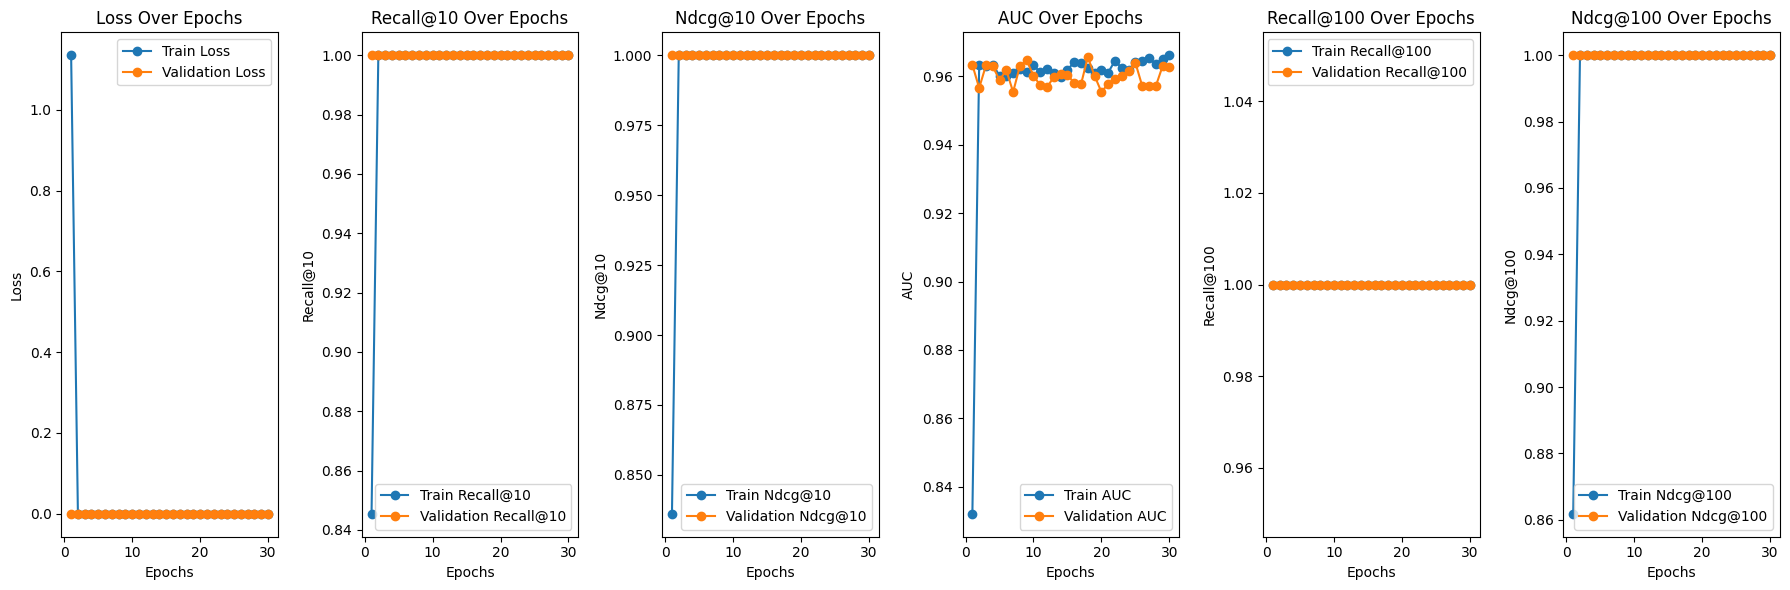

In [179]:
_history = merge_model_history(*history_v6)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': AUC_TERM, **METRIC_AT})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [180]:
(model_v6.evaluate(train, batch_size=2048, return_dict=True),
 model_v6.evaluate(valid, batch_size=2048, return_dict=True))

8/8 [==============================] - 0s 26ms/step - loss: 7.6101e-08 - auc_34: 0.9695 - recall_at_100: 1.0000 - mrr_at_100: 1.0000 - ndcg_at_100: 1.0000 - map_at_100: 1.0000 - precision_at_100: 0.0100 - recall_at_10: 1.0000 - mrr_at_10: 1.0000 - ndcg_at_10: 1.0000 - map_at_10: 1.0000 - precision_at_10: 0.1000 - regularization_loss: 0.0000e+00 - loss_batch: 6.1851e-08


({'loss': 2.137360866072413e-08,
  'auc_34': 0.9669455289840698,
  'recall_at_100': 1.0,
  'mrr_at_100': 1.0,
  'ndcg_at_100': 1.0,
  'map_at_100': 1.0,
  'precision_at_100': 0.009999998845160007,
  'recall_at_10': 1.0,
  'mrr_at_10': 1.0,
  'ndcg_at_10': 1.0,
  'map_at_10': 1.0,
  'precision_at_10': 0.09999997168779373,
  'regularization_loss': 0.0,
  'loss_batch': 8.365558024081565e-09},
 {'loss': 7.610132968238759e-08,
  'auc_34': 0.9695402979850769,
  'recall_at_100': 1.0,
  'mrr_at_100': 1.0,
  'ndcg_at_100': 1.0,
  'map_at_100': 1.0,
  'precision_at_100': 0.009999998845160007,
  'recall_at_10': 1.0,
  'mrr_at_10': 1.0,
  'ndcg_at_10': 1.0,
  'map_at_10': 1.0,
  'precision_at_10': 0.10000001639127731,
  'regularization_loss': 0.0,
  'loss_batch': 5.786858214840152e-10})

In [181]:
evaluate_model(model_v6, train, topk=100)

Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


ValueError: ignored

In [147]:
evaluate_model(model_v6, valid, topk=100)

Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


15/15 [==============================] - 2s 20ms/step - loss: 0.9426 - auc_25: 0.5255 - recall_at_100: 0.1869 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0363 - map_at_100: 0.0069 - precision_at_100: 0.0019 - regularization_loss: 0.0000e+00 - loss_batch: 0.9920


{'loss': 0.9425756335258484,
 'auc_25': 0.5254902243614197,
 'recall_at_100': 0.19272436201572418,
 'mrr_at_100': 0.007468328345566988,
 'ndcg_at_100': 0.037826042622327805,
 'map_at_100': 0.007468328345566988,
 'precision_at_100': 0.0019272435456514359,
 'regularization_loss': 0.0,
 'loss_batch': 1.508877158164978}

## Evaluate the Model top-k results

In [142]:
test = merlin.io.Dataset(
    TEST_PATHS, engine="parquet"
)
test_df = test.to_ddf().compute()
train_df = train.to_ddf().compute()
valid_df = valid.to_ddf().compute()

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [143]:
all_df = pd.concat((train_df, valid_df, test_df ), axis=0, ignore_index=True).reset_index(drop=True)
all_ds = merlin.io.Dataset(all_df)
all_ds.schema = schema

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [144]:
data = valid
data_df = valid_df

### Cold Start

In [116]:
candidate_features = get_candidates(all_ds)
topk = 100
batch_size=2048
model = model_v6

topk_model = to_top_k_encoder(model, candidate_features, k=topk, batch_size=batch_size)
topk_model.compile(run_eagerly=False, metrics=[
    mm.RecallAt(topk), mm.NDCGAt(topk), mm.MRRAt(topk)
])

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1664


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [145]:
catalog = data_df['movie_id'].value_counts(ascending=False)
catalog

127     65
59      57
94      56
117     55
41      55
        ..
1113     1
1157     1
1221     1
1209     1
1070     1
Name: movie_id, Length: 1387, dtype: int64

In [153]:
recommendation_centric_metrics(topk_model, test, catalog.to_dict(), batch_size=1024 )

Candidate set rows: 943


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


{'coverage': 1.0, 'novelty': 0.1755608799825746}

In [ ]:
def prediction_coverage(predicted_ratings, total_users, total_items):
    # Count the number of user-item pairs for which the recommendation system can make predictions
    predicted_pairs = sum(len(ratings) for ratings in predicted_ratings)

    # Calculate the total number of possible user-item pairs
    total_possible_pairs = total_users * total_items

    # Calculate the prediction coverage
    coverage = predicted_pairs / total_possible_pairs
    return coverage

In [121]:
cold_movies = list(set(data_df['movie_id'].unique()).difference(set(train_df['movie_id'].unique())))
len(cold_movies)

50

In [122]:
hot_movies = list(train_df['movie_id'].value_counts(ascending=False)[:50])
len(hot_movies)

50

In [123]:
target_movies = cold_movies
eval_loader = mm.Loader(data, batch_size=2048, shuffle=False)
_iter = iter(eval_loader)

In [124]:
from collections import defaultdict
movie_count = defaultdict(set)

for batch, _ in _iter:
    r = topk_model(batch)[1].numpy()
    for mid in target_movies:
        mask = np.any(r == mid, axis=1)
        movie_count[mid] |= set(tf.boolean_mask(batch['user_id'], mask).numpy())
    # count_user_recommended += np.sum(np.any(np.isin(r, target_movies), axis=1))

In [125]:
_table = []
for k,v in movie_count.items():
    user_watched = set(data_df[data_df['movie_id'] == k]['user_id'])
    actual_watched = (data_df['movie_id'] == k).sum()
    _table.append([k, len(v), len(user_watched.intersection(v)), actual_watched])
    # print(k, len(v), len(user_watched.intersection(v)), actual_watched)

In [126]:
total_watched = 0
total_rec = 0
for x in _table:
    total_watched += x[2]
    total_rec += x[1]
total_watched/total_rec

0.00037757221068529355

In [127]:
from tabulate import tabulate
print(tabulate(_table, headers=('movie_id', '#users recommended', '#users watched', '#actual watches')))

  movie_id    #users recommended    #users watched    #actual watches
----------  --------------------  ----------------  -----------------
      1536                    67                 0                  1
      1540                   117                 0                  1
      1414                    87                 0                  1
      1549                   130                 0                  1
      1423                   118                 0                  1
      1551                    90                 0                  1
      1560                   105                 0                  1
      1436                   129                 0                  1
      1565                   104                 0                  1
      1567                    89                 0                  1
      1570                    82                 0                  1
      1571                   137                 0                  1
      1572          

### Previous

In [54]:
from tabulate import tabulate
print(tabulate(_table, headers=('movie_id', '#users recommended', '#users watched', '#actual watches')))

  movie_id    #users recommended    #users watched    #actual watches
----------  --------------------  ----------------  -----------------
      1664                   140                 0                  1
      1538                   113                 0                  1
      1539                   141                 0                  1
      1414                   103                 0                  2
      1655                   186                 0                  1
      1544                   104                 0                  1
      1547                    96                 0                  1
      1423                   151                 0                  2
      1552                   135                 0                  1
      1553                   145                 0                  1
      1426                   146                 0                  3
      1555                    84                 0                  1
      1558          

## generate recommendations

In [122]:
valid_df = valid.to_ddf().compute()
train_df = train.to_ddf().compute()


In [123]:
def recommend_for_user_id(uid, data, topk_model):
    prepare_ds = merlin.io.Dataset(data[data['user_id'] == uid])
    # prepare_ds.schema = valid.schema
    eval_loader = mm.Loader(prepare_ds, batch_size=1)

    batch = next(iter(eval_loader))
    recs = topk_model(inputs=batch[0], return_dict=True)[1].numpy()[0]
    return recs

def recommend_for_movie_id(mid, data, topk_model):
    prepare_ds = merlin.io.Dataset(data[data['movie_id'] == mid])
    # prepare_ds.schema = valid.schema
    eval_loader = mm.Loader(prepare_ds, batch_size=1)

    batch = next(iter(eval_loader))
    recs = topk_model(inputs=batch[0], return_dict=True)[1].numpy()[0]
    return recs

In [124]:
candidate_features = get_candidates(valid)
topk = 100
batch_size=1024
model = model_v6

topk_model = to_top_k_encoder(model, candidate_features, k=topk, batch_size=batch_size)
topk_model.compile(run_eagerly=False, metrics=[
    mm.RecallAt(topk), mm.NDCGAt(topk), mm.MRRAt(topk)
])

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1387


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [125]:
# uids = range(1,10)

# for uid in uids:
#     watched_movies = valid_df[valid_df['user_id'] == uid]['movie_id'].unique()
#     new_movies = set(watched_movies).difference(train_df[train_df['user_id'] == uid]['movie_id'].unique())
#     # print(f'User {uid} watched {len(watched_movies)} movies')
#     recs = recommend_for_user_id(uid, valid_df, topk_model)
#     # if len(set(watched_movies).intersection(set(recs))) > 10:
#     print(f'UID: {uid},Recall', len(set(watched_movies).intersection(set(recs))))

In [126]:
cold_movies = list(set(valid_df['movie_id'].unique()).difference(set(train_df['movie_id'].unique())))
len(cold_movies)

50

In [127]:
cold_movie = cold_movies[2]
cold_movie

1414

In [128]:
user_watched_cold_movie = valid_df[valid_df['movie_id'] == cold_movie]['user_id']
user_watched_cold_movie

14704    1
Name: user_id, dtype: int64

In [129]:
user_features = get_candidates(valid, candidate_id=Tags.USER)
topk = 100
batch_size=1024
model = model_v6

topk_user_model = to_top_k_encoder(model, user_features, k=topk, batch_size=batch_size, candidate_id=Tags.USER_ID)
topk_user_model.compile(run_eagerly=False, metrics=[
    mm.RecallAt(topk), mm.NDCGAt(topk), mm.MRRAt(topk)
])

TypeError: ignored

In [ ]:
recommend_for_movie_id(cold_movie, valid_df, topk_user_model)

In [ ]:
# for cmid in cold_movies:
#     recs = recommend_for_movie_id(cmid, valid_df, topk_user_model)
#     uid_who_watched = valid_df[valid_df['movie_id'] == cmid]['user_id']
#     uid_rec = set(recs).intersection(set(uid_who_watched))
#     print(f'MID: {cmid} People who watched {len(uid_who_watched)}, who were recommneded {len(uid_rec)}')

In [ ]:
test = merlin.io.Dataset(
    TEST_PATHS, engine="parquet"
)
test_df = test.to_ddf().compute()

In [ ]:
cold_movies = list(set(test_df['movie_id'].unique()).difference(set(train_df['movie_id'].unique())))
len(cold_movies)

In [ ]:
candidate_features = get_candidates(test)
topk = 100
batch_size=1024
model = model_v6

topk_model = to_top_k_encoder(model, candidate_features, k=topk, batch_size=batch_size)
topk_model.compile(run_eagerly=False, metrics=[
    mm.RecallAt(topk), mm.NDCGAt(topk), mm.MRRAt(topk)
])

In [ ]:
eval_loader = mm.Loader(test, batch_size=2048, shuffle=False)
_iter = iter(eval_loader)

In [ ]:
count_user_recommended = 0
from collections import defaultdict
cold_movie_count = defaultdict(set)
ran = 0

for batch, _ in _iter:
    r = topk_model(batch)[1].numpy()
    for cmid in cold_movies:
        mask = np.any(r == cmid, axis=1)
        cold_movie_count[cmid] |= set(tf.boolean_mask(batch['user_id'], mask).numpy())
    # count_user_recommended += np.sum(np.any(np.isin(r, cold_movies), axis=1))


In [ ]:
for k,v in cold_movie_count.items():
    user_watched = set(test_df[test_df['movie_id'] == k]['user_id'])
    actual_watched = (test_df['movie_id'] == k).sum()
    print(k, len(v), len(user_watched.intersection(v)), actual_watched)

In [ ]:
ran

In [ ]:
valid_df['user_id'].nunique()

In [ ]:
array_2d = np.array([[1, 2, 3, 1],
                     [4, 5, 6, 5],
                     [7, 8, 8, 9]])

# Set of values to count occurrences of
values_to_count = [5, 8]

# Count occurrences of the set in each row
np.sum(np.any(np.isin(array_2d, values_to_count), axis=1))

In [ ]:
np.any(np.isin(array_2d, values_to_count), axis=1)

In [ ]:
(count_per_row).sum()

In [ ]:
r = topk_model(batch[0])[1].numpy()
for i, u in enumerate(batch[0]['user_id'].numpy()):
    _m = set(valid_df[valid_df['user_id'] == u]['movie_id'])
    _r = set(r[i])

    print(len(_r.intersection(_m))/len(_r), len(_r.intersection(_m))/len(_m))

## TMP

In [ ]:
# model = mm.DLRMModel(
#     train.schema,
#     embedding_dim=64,
#     bottom_block=mm.MLPBlock([128, 64]),
#     top_block=mm.MLPBlock([128, 64, 32]),
#     prediction_tasks=mm.BinaryOutput(
#         train.schema.select_by_tag(Tags.TARGET).column_names[0]
#     ),
# )
# model.compile(optimizer="adam")
# model.fit(train, batch_size=1024)

In [ ]:
schema

,name,tags,dtype,is_list,is_ragged,properties.start_index,properties.cat_path,properties.max_size,properties.num_buckets,properties.freq_threshold,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.domain.min,properties.domain.max,properties.domain.name
0,movie_id,"(Tags.ITEM, Tags.ID, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.movie_id.parquet,0.0,None,0.0,1562.0,98.0,0,1561,movie_id
1,user_id,"(Tags.USER, Tags.ID, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.user_id.parquet,0.0,None,0.0,944.0,74.0,0,943,user_id
2,gender,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.gender.parquet,0.0,None,0.0,3.0,16.0,0,2,gender
3,occupation,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.occupation.parquet,0.0,None,0.0,22.0,16.0,0,21,occupation


In [ ]:
# Define Model
import tensorflow as tf
QUERY_DROPOUT = 0.1
ITEM_DROPOUT = 0.1

model_v0 = mm.TwoTowerModel(
    schema,
    query_tower=mm.MLPBlock(
        [128,256],
        kernel_regularizer=tf.keras.regularizers.l1(3.9e-06),
        bias_regularizer=tf.keras.regularizers.l1(3.9e-06),
        no_activation_last_layer=True,
        # dropout=QUERY_DROPOUT
     ),
     item_tower=mm.MLPBlock(
         [128,256],
         kernel_regularizer=tf.keras.regularizers.l1(3.9e-06),
         bias_regularizer=tf.keras.regularizers.l1(3.9e-06),
         no_activation_last_layer=True,
        #  dropout=ITEM_DROPOUT
     ),
     samplers=[mm.InBatchSampler()] # default value
)

In [ ]:
TOP_K = [10]

model_v0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    run_eagerly=False,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.AUC(),
        mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K),

            #  tfr.keras.metrics.MRRMetric(topn=4)
             ],
)
model_v0.fit(
    train,
    validation_data=valid,
    schema=schema,
    batch_size=32,
    epochs=10,
    # shuffle = False
)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/138 [==============================] - ETA: 0s - loss: 6.2522 - recall_at_10: 0.0212 - mrr_at_10: 0.0068 - ndcg_at_10: 0.0101 - map_at_10: 0.0068 - precision_at_10: 0.0021 - auc_23: 0.4996 - regularization_loss: 0.0159 - loss_batch: 6.2382

138/138 [==============================] - 34s 171ms/step - loss: 6.2522 - recall_at_10: 0.0212 - mrr_at_10: 0.0068 - ndcg_at_10: 0.0101 - map_at_10: 0.0068 - precision_at_10: 0.0021 - auc_23: 0.4996 - regularization_loss: 0.0158 - loss_batch: 6.2225 - val_loss: 6.2307 - val_recall_at_10: 0.0217 - val_mrr_at_10: 0.0069 - val_ndcg_at_10: 0.0103 - val_map_at_10: 0.0069 - val_precision_at_10: 0.0022 - val_auc_23: 0.5000 - val_regularization_loss: 0.0054 - val_loss_batch: 4.6038
Epoch 2/10
138/138 [==============================] - 7s 47ms/step - loss: 6.2393 - recall_at_10: 0.0214 - mrr_at_10: 0.0069 - ndcg_at_10: 0.0102 - map_at_10: 0.0069 - precision_at_10: 0.0021 - auc_23: 0.5031 - regularization_loss: 0.0044 - loss_batch: 6.2098 - val_loss: 6.2298 - val_recall_at_10: 0.0207 - val_mrr_at_10: 0.0061 - val_ndcg_at_10: 0.0095 - val_map_at_10: 0.0061 - val_precision_at_10: 0.0021 - val_auc_23: 0.5003 - val_regularization_loss: 0.0045 - val_loss_batch: 4.6036
Epoch 3/10
138/138 [===========

In [ ]:
train_df = train.to_ddf().compute()
val_df = valid.to_ddf().compute()

In [ ]:
train_df

,movie_id,user_id,gender,occupation,genres,rating,movie_id_raw
0,121,13,1,1,[1],1.0,134
1,196,33,1,18,"[1, 4, 8]",1.0,31
2,451,901,1,1,"[2, 5]",1.0,354
3,48,88,2,8,"[2, 5]",0.0,202
4,330,30,1,4,[1],0.0,708
...,...,...,...,...,...,...,...
70197,60,232,1,1,"[1, 13]",0.0,289
70198,89,80,1,1,"[4, 3, 9]",0.0,273
70199,180,253,1,11,[1],1.0,285
70200,507,111,1,15,[1],1.0,468


In [ ]:
assert train_df['user_id'].nunique() == val_df['user_id'].nunique()

In [ ]:
train_df['movie_id'].nunique(), val_df['movie_id'].nunique()

(1561, 1387)

In [ ]:
len(set(train_df['movie_id'].unique()).intersection(set(val_df['movie_id'].unique())))

1337

In [ ]:
# missing
len(set(train_df['movie_id'].unique()).difference(set(val_df['movie_id'].unique())))

224

In [ ]:
# cold start
len(set(val_df['movie_id'].unique()).difference(set(train_df['movie_id'].unique())))

50

In [ ]:
train_df['rating'].nunique()

2

In [ ]:
schema

,name,tags,dtype,is_list,is_ragged,properties.max_size,properties.embedding_sizes.dimension,properties.embedding_sizes.cardinality,properties.freq_threshold,properties.num_buckets,properties.cat_path,properties.start_index,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.ID, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,0.0,98.0,1562.0,0.0,NaN,.//categories/unique.movie_id.parquet,0.0,0.0,1561.0,movie_id,NaN,NaN
1,user_id,"(Tags.ID, Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,74.0,944.0,0.0,NaN,.//categories/unique.user_id.parquet,0.0,0.0,943.0,user_id,NaN,NaN
2,gender,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,16.0,3.0,0.0,NaN,.//categories/unique.gender.parquet,0.0,0.0,2.0,gender,NaN,NaN
3,occupation,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,16.0,22.0,0.0,NaN,.//categories/unique.occupation.parquet,0.0,0.0,21.0,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,0.0,16.0,20.0,0.0,NaN,.//categories/unique.genres.parquet,0.0,0.0,19.0,genres,0.0,NaN
5,rating,"(Tags.TARGET, Tags.BINARY_CLASSIFICATION)","DType(name='float32', element_type=<ElementTyp...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
model = mm.DLRMModel(
    train.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryOutput(
        train.schema.select_by_tag(Tags.TARGET).column_names[0]
    ),
)

In [ ]:
batch_size = 1024
LR = 0.03

In [ ]:
opt = tf.keras.optimizers.legacy.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False,
              metrics=[tf.keras.metrics.AUC(), mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)])


In [ ]:
history = [history]

In [ ]:
history.append(model.fit(train, validation_data=valid, batch_size=batch_size, epochs=50))

Epoch 1/50
69/69 [==============================] - 3s 29ms/step - loss: 0.5212 - auc_7: 0.8074 - recall_at_10: 0.9569 - mrr_at_10: 0.9692 - ndcg_at_10: 0.9564 - map_at_10: 0.9281 - precision_at_10: 0.9569 - regularization_loss: 0.0000e+00 - loss_batch: 0.5201 - val_loss: 0.5999 - val_auc_7: 0.7578 - val_recall_at_10: 0.9600 - val_mrr_at_10: 1.0000 - val_ndcg_at_10: 0.9681 - val_map_at_10: 0.9417 - val_precision_at_10: 0.9600 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.6320
Epoch 2/50
69/69 [==============================] - 3s 29ms/step - loss: 0.5204 - auc_7: 0.8081 - recall_at_10: 0.9652 - mrr_at_10: 0.9786 - ndcg_at_10: 0.9658 - map_at_10: 0.9421 - precision_at_10: 0.9652 - regularization_loss: 0.0000e+00 - loss_batch: 0.5193 - val_loss: 0.6002 - val_auc_7: 0.7576 - val_recall_at_10: 0.9667 - val_mrr_at_10: 1.0000 - val_ndcg_at_10: 0.9729 - val_map_at_10: 0.9510 - val_precision_at_10: 0.9667 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.6333
Epoch 3/50
69/

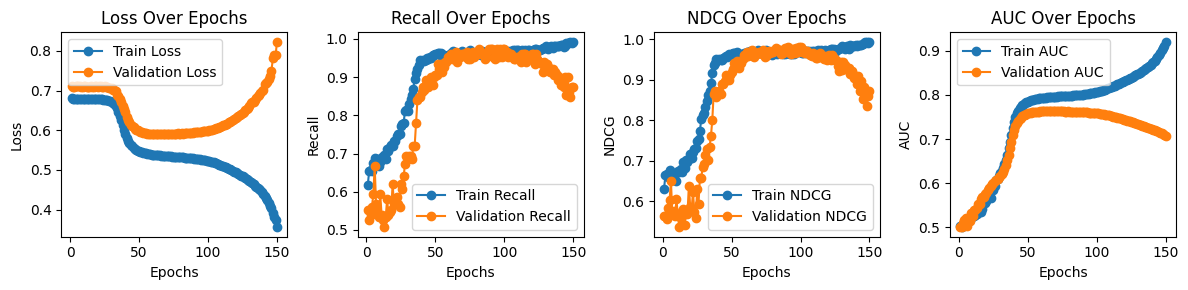

In [ ]:
_history = merge_model_history(*history)
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc_7'})

In [ ]:
model_v9.candidate_embedding

## Evaluate the Model top-k results

In [99]:
train_df = train.to_ddf().compute()

In [100]:
test = merlin.io.Dataset(
    TEST_PATHS, engine="parquet"
)
test_df = test.to_ddf().compute()

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [101]:
data = test
data_df = test_df

### Cold Start

In [102]:
candidate_features = get_candidates(data)
topk = 100
batch_size=2048
model = model_v6

topk_model = to_top_k_encoder(model, candidate_features, k=topk, batch_size=batch_size)
topk_model.compile(run_eagerly=False, metrics=[
    mm.RecallAt(topk), mm.NDCGAt(topk), mm.MRRAt(topk)
])

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Candidate set rows: 1432


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [103]:
cold_movies = list(set(data_df['movie_id'].unique()).difference(set(train_df['movie_id'].unique())))
len(cold_movies)

72

In [104]:
hot_movies = list(train_df['movie_id'].value_counts(ascending=False)[:50])
len(hot_movies)

50

In [105]:
target_movies = cold_movies
eval_loader = mm.Loader(data, batch_size=2048, shuffle=False)
_iter = iter(eval_loader)

In [106]:
from collections import defaultdict
movie_count = defaultdict(set)

for batch, _ in _iter:
    r = topk_model(batch)[1].numpy()
    for mid in target_movies:
        mask = np.any(r == mid, axis=1)
        movie_count[mid] |= set(tf.boolean_mask(batch['user_id'], mask).numpy())
    # count_user_recommended += np.sum(np.any(np.isin(r, target_movies), axis=1))

In [107]:
_table = []
for k,v in movie_count.items():
    user_watched = set(data_df[data_df['movie_id'] == k]['user_id'])
    actual_watched = (data_df['movie_id'] == k).sum()
    _table.append([k, len(v), len(user_watched.intersection(v)), actual_watched])
    # print(k, len(v), len(user_watched.intersection(v)), actual_watched)

In [108]:
total_watched = 0
total_rec = 0
for x in _table:
    total_watched += x[2]
    total_rec += x[1]
total_watched/total_rec

0.0

In [109]:
from tabulate import tabulate
print(tabulate(_table, headers=('movie_id', '#users recommended', '#users watched', '#actual watches')))

  movie_id    #users recommended    #users watched    #actual watches
----------  --------------------  ----------------  -----------------
      1664                    12                 0                  1
      1538                     7                 0                  1
      1539                    43                 0                  1
      1414                    11                 0                  2
      1655                    14                 0                  1
      1544                    25                 0                  1
      1547                    45                 0                  1
      1423                    17                 0                  2
      1552                    33                 0                  1
      1553                    17                 0                  1
      1426                    13                 0                  3
      1555                    25                 0                  1
      1558          

### Previous

In [110]:
# from tabulate import tabulate
# print(tabulate(_table, headers=('movie_id', '#users recommended', '#users watched', '#actual watches')))